In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from scipy import stats, signal
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, silhouette_samples
from sklearn.preprocessing import StandardScaler
from pathlib import Path
import json
import warnings
import re
from typing import Dict, List, Tuple, Optional
from collections import defaultdict
import itertools
from tqdm.notebook import tqdm
import gc

In [2]:
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print("✅ Environment setup complete")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")

✅ Environment setup complete
NumPy version: 2.0.2
Pandas version: 2.2.2
Matplotlib version: 3.10.0


In [3]:
class Config:
    """Global configuration and constants"""
    # Timing constants (5G NR specification)
    SYMBOL_DURATION_US = 35.714285714  # microseconds (500us / 14)
    SYMBOL_DURATION_S = 500e-6 / 14    # seconds
    SLOT_DURATION_US = 500.0
    SLOT_DURATION_S = 500e-6
    N_SYMBOLS_PER_SLOT = 14

    # Network parameters
    N_CELLS = 24
    N_EXPECTED_LINKS = 3

    # Loss detection threshold
    LOSS_THRESHOLD = 0.01  # 1% loss rate to flag congestion

    # Alignment parameters
    MAX_ALIGNMENT_LAG = 5  # slots

    # Correlation weights
    CORRELATION_WEIGHTS = {
        'pearson': 0.4,
        'spearman': 0.3,
        'jaccard': 0.3
    }

    # Clustering parameters
    CLUSTERING_METHOD = 'hierarchical'
    LINKAGE_TYPE = 'average'

    # Validation
    N_BOOTSTRAP_SAMPLES = 100
    N_TIME_WINDOWS = 5

    # Random seed
    RANDOM_SEED = 42

    # File paths - UPDATE THIS TO YOUR DATA DIRECTORY
    DATA_DIR = '/content/drive/MyDrive/HackathonFronthaulNetworkOptimization-20260202T123737Z-3-001/HackathonFronthaulNetworkOptimization'  # Update if needed
    OUTPUT_DIR = './results'

    # Throughput outlier threshold (Gbps) - detect measurement errors
    THROUGHPUT_OUTLIER_THRESHOLD = 30.0  # Gbps (anything above is likely error)

config = Config()

# Create output directory
Path(config.OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

print(f"📁 Data directory: {config.DATA_DIR}")
print(f"📁 Output directory: {config.OUTPUT_DIR}")
print(f"🔢 Expected cells: {config.N_CELLS}")
print(f"🔢 Expected links: {config.N_EXPECTED_LINKS}")

📁 Data directory: /content/drive/MyDrive/HackathonFronthaulNetworkOptimization-20260202T123737Z-3-001/HackathonFronthaulNetworkOptimization
📁 Output directory: ./results
🔢 Expected cells: 24
🔢 Expected links: 3


In [4]:
class NokiaDataLoader:
    """
    Nokia-grade loader for:
    - throughput-cell-<id>.dat (symbol-level DU logs)
    - pkt-stats-cell-<id>.dat (slot-level RU logs)
    """

    def __init__(self, data_directory: str, config):
        self.data_dir = Path(data_directory)
        self.config = config

    # --------------------------------------------------
    # File discovery
    # --------------------------------------------------
    def find_data_files(self) -> Tuple[List[Path], List[Path]]:
        print("🔍 Scanning for data files...")
        throughput = sorted(self.data_dir.glob("throughput-cell-*.dat"))
        pkt_stats = sorted(self.data_dir.glob("pkt-stats-cell-*.dat"))
        print(f"   Found {len(throughput)} throughput files")
        print(f"   Found {len(pkt_stats)} packet stats files")
        return throughput, pkt_stats

    def extract_cell_id_from_filename(self, path: Path) -> Optional[int]:
        m = re.search(r"cell-(\d+)", path.name)
        return int(m.group(1)) if m else None

    # --------------------------------------------------
    # Throughput loading (symbol-level)
    # --------------------------------------------------
    def load_throughput_file(self, path: Path) -> pd.DataFrame:
        """
        Format:
        <timestamp_s> <kilobits>
        """
        df = pd.read_csv(
            path,
            sep=r"\s+",
            names=["timestamp_s", "kilobits"],
            comment="#",
            engine="python"
        )

        # Force numeric (prevents TypeError)
        df["timestamp_s"] = pd.to_numeric(df["timestamp_s"], errors="coerce")
        df["kilobits"] = pd.to_numeric(df["kilobits"], errors="coerce")
        df = df.dropna()

        # Sort (README requirement)
        df = df.sort_values("timestamp_s")

        # Merge duplicate symbol timestamps (same symbol logged twice)
        df = (
            df.groupby("timestamp_s", as_index=False)
              .agg({"kilobits": "sum"})
        )

        # Compute throughput (Gbps)
        df["throughput_gbps"] = (
            df["kilobits"] * 1000 / self.config.SYMBOL_DURATION_US
        )

        # Remove measurement errors
        mask = df["throughput_gbps"] > self.config.THROUGHPUT_OUTLIER_THRESHOLD
        if mask.any():
            print(f"      ⚠️ Removing {mask.sum()} throughput outliers")
            df.loc[mask, ["kilobits", "throughput_gbps"]] = 0

        # Symbol & slot indexing
        df = df.reset_index(drop=True)
        df["symbol_id"] = df.index
        df["slot_id"] = df["symbol_id"] // self.config.N_SYMBOLS_PER_SLOT

        return df

    # --------------------------------------------------
    # Packet stats loading (slot-level)
    # --------------------------------------------------
    def load_pkt_stats_file(self, path: Path) -> pd.DataFrame:
        """
        Nokia pkt-stats format (CONFIRMED):

        <slotStart_timestamp_s> <txPackets> <rxPackets> <tooLateRxPackets>

        Header line may be present:
        <slot> <slotStart> <txPackets> <rxPackets> <tooLateRxPackets>
        """

        # 🔥 Skip header line explicitly
        df = pd.read_csv(
            path,
            sep=r"\s+",
            comment="#",
            header=None,
            engine="python",
            skiprows=1   # <<< THIS IS THE KEY
        )

        if df.shape[1] != 4:
            raise ValueError(
                f"Unexpected pkt-stats format in {path}: "
                f"{df.shape[1]} columns found, expected 4"
            )

        df.columns = [
            "timestamp_s",
            "tx_packets",
            "rx_packets",
            "too_late_packets"
        ]

        # Force numeric (strict now — should NOT fail)
        df["timestamp_s"] = pd.to_numeric(df["timestamp_s"], errors="raise")
        df["tx_packets"] = pd.to_numeric(df["tx_packets"], errors="raise")
        df["rx_packets"] = pd.to_numeric(df["rx_packets"], errors="raise")
        df["too_late_packets"] = pd.to_numeric(df["too_late_packets"], errors="raise")

        # Sort by slot start time
        df = df.sort_values("timestamp_s").reset_index(drop=True)

        # Slot index (authoritative)
        df["slot_id"] = df.index

        # Packet loss calculation
        df["packets_received_valid"] = (
            df["rx_packets"] - df["too_late_packets"]
        ).clip(lower=0)

        df["packets_lost"] = (
            df["tx_packets"] - df["packets_received_valid"]
        ).clip(lower=0)

        df["loss_rate"] = (
            df["packets_lost"] /
            df["tx_packets"].replace(0, 1)
        ).clip(0, 1)

        return df






    # --------------------------------------------------
    # Load all cells
    # --------------------------------------------------
    def load_all_data(self) -> Dict[str, Dict[int, pd.DataFrame]]:
        throughput_files, pkt_files = self.find_data_files()
        data = {"throughput": {}, "pkt_stats": {}}

        for f in tqdm(throughput_files, desc="Throughput"):
            cid = self.extract_cell_id_from_filename(f)
            if cid is not None:
                data["throughput"][cid] = self.load_throughput_file(f)

        for f in tqdm(pkt_files, desc="Packet Stats"):
            cid = self.extract_cell_id_from_filename(f)
            if cid is not None:
                data["pkt_stats"][cid] = self.load_pkt_stats_file(f)

        return data

    # --------------------------------------------------
    # Timestamp-aligned merge (CRITICAL)
    # --------------------------------------------------
    def combine_datasets(self, data: Dict) -> pd.DataFrame:
        print("\n🔄 Combining datasets using slot-index alignment...")
        all_cells = []

        SLOT_DURATION_S = (
            self.config.SYMBOL_DURATION_US * self.config.N_SYMBOLS_PER_SLOT / 1e6
        )

        common_cells = set(data["throughput"]) & set(data["pkt_stats"])

        for cid in tqdm(sorted(common_cells), desc="Combining"):
            tput = data["throughput"][cid]
            pkt = data["pkt_stats"][cid]

            # -----------------------------
            # Prepare packet stats (authoritative slots)
            # -----------------------------
            pkt = pkt.sort_values("timestamp_s").reset_index(drop=True)
            pkt["slot_id"] = pkt.index

            # -----------------------------
            # Aggregate throughput to slot level
            # -----------------------------
            tput_slot = (
                tput.groupby("slot_id")
                    .agg(
                        throughput_gbps=("throughput_gbps", "mean"),
                        total_kilobits=("kilobits", "sum"),
                        slot_time=("timestamp_s", "min")
                    )
                    .reset_index()
            )

            if tput_slot.empty:
                continue

            # -----------------------------
            # 🔥 Compute SLOT offset (not timestamp join)
            # -----------------------------
            pkt_median = pkt["timestamp_s"].median()
            tput_median = tput_slot["slot_time"].median()

            if pd.isna(pkt_median) or pd.isna(tput_median):
                # Cannot estimate offset reliably
                slot_offset = 0
                print(f"⚠️ Cell {cid}: cannot estimate time offset, assuming 0")
            else:
                time_offset = pkt_median - tput_median
                slot_offset = int(round(time_offset / SLOT_DURATION_S))


            # Shift throughput slot index
            tput_slot["slot_id_aligned"] = (
                tput_slot["slot_id"] + slot_offset
            )

            # -----------------------------
            # Merge by SLOT INDEX (robust)
            # -----------------------------
            merged = pkt.merge(
                tput_slot[
                    ["slot_id_aligned", "throughput_gbps", "total_kilobits"]
                ],
                left_on="slot_id",
                right_on="slot_id_aligned",
                how="left"
            )

            merged["throughput_gbps"] = merged["throughput_gbps"].fillna(0)
            merged["total_kilobits"] = merged["total_kilobits"].fillna(0)
            merged["throughput_mbps"] = merged["throughput_gbps"] * 1000 # Add this line to create throughput_mbps
            merged["cell_id"] = cid

            merged = merged.drop(columns=["slot_id_aligned"], errors="ignore")

            all_cells.append(merged)

        if not all_cells:
            print("❌ No cells merged — check input data")
            return pd.DataFrame()

        combined = pd.concat(all_cells, ignore_index=True)
        combined = combined.sort_values(
            ["cell_id", "slot_id"]
        ).reset_index(drop=True)

        print(f"✅ Combined dataset: {len(combined)} rows")
        return combined





    # --------------------------------------------------
    # Validation
    # --------------------------------------------------
    def validate_data_quality(self, df: pd.DataFrame) -> Dict:
        print("\n🔍 Validating data quality...")
        metrics = {}

        for cid in sorted(df["cell_id"].unique()):
            cdf = df[df["cell_id"] == cid]
            metrics[cid] = {
                "slots": len(cdf),
                "mean_loss_rate": cdf["loss_rate"].mean(),
                "max_loss_rate": cdf["loss_rate"].max(),
                "loss_events": (
                    cdf["loss_rate"] > self.config.LOSS_THRESHOLD
                ).sum(),
                "mean_throughput_gbps": cdf["throughput_gbps"].mean()
            }

        return metrics

In [5]:
loader = NokiaDataLoader(config.DATA_DIR, config)

# Load all data
raw_data = loader.load_all_data()

# Combine datasets
df_raw = loader.combine_datasets(raw_data)

# Validate data quality
quality_metrics = loader.validate_data_quality(df_raw)

# Display sample data
print("\n📊 Sample of loaded data:")
print(df_raw.head(20))

print("\n📊 Data schema:")
print(df_raw.dtypes)

print("\n📊 Basic statistics:")
print(df_raw[['loss_rate', 'throughput_gbps', 'packets_lost']].describe())

🔍 Scanning for data files...
   Found 24 throughput files
   Found 24 packet stats files


Throughput:   0%|          | 0/24 [00:00<?, ?it/s]

      ⚠️ Removing 521104 throughput outliers
      ⚠️ Removing 726720 throughput outliers
      ⚠️ Removing 488814 throughput outliers
      ⚠️ Removing 504463 throughput outliers
      ⚠️ Removing 848933 throughput outliers
      ⚠️ Removing 478342 throughput outliers
      ⚠️ Removing 773204 throughput outliers
      ⚠️ Removing 825445 throughput outliers
      ⚠️ Removing 496622 throughput outliers
      ⚠️ Removing 689560 throughput outliers
      ⚠️ Removing 748413 throughput outliers
      ⚠️ Removing 749943 throughput outliers
      ⚠️ Removing 521197 throughput outliers
      ⚠️ Removing 486621 throughput outliers
      ⚠️ Removing 507109 throughput outliers
      ⚠️ Removing 778434 throughput outliers
      ⚠️ Removing 732287 throughput outliers
      ⚠️ Removing 498447 throughput outliers
      ⚠️ Removing 462833 throughput outliers
      ⚠️ Removing 386821 throughput outliers
      ⚠️ Removing 760961 throughput outliers
      ⚠️ Removing 750154 throughput outliers
      ⚠️ R

Packet Stats:   0%|          | 0/24 [00:00<?, ?it/s]


🔄 Combining datasets using slot-index alignment...


Combining:   0%|          | 0/24 [00:00<?, ?it/s]

✅ Combined dataset: 2198544 rows

🔍 Validating data quality...

📊 Sample of loaded data:
    timestamp_s  tx_packets  rx_packets  too_late_packets  slot_id  \
0       1.00001           0           0                 0        0   
1       1.00023           0           0                 0        1   
2       1.00065           0           0                 0        2   
3       1.00115           0           0                 0        3   
4       1.00215           0           0                 0        4   
5       1.00265           0           0                 0        5   
6       1.00315           0           0                 0        6   
7       1.00365           0           0                 0        7   
8       1.00465          16          16                 0        8   
9       1.00515          16          16                 0        9   
10      1.00565          20          20                 0       10   
11      1.00615           0           0                 0       11   
1

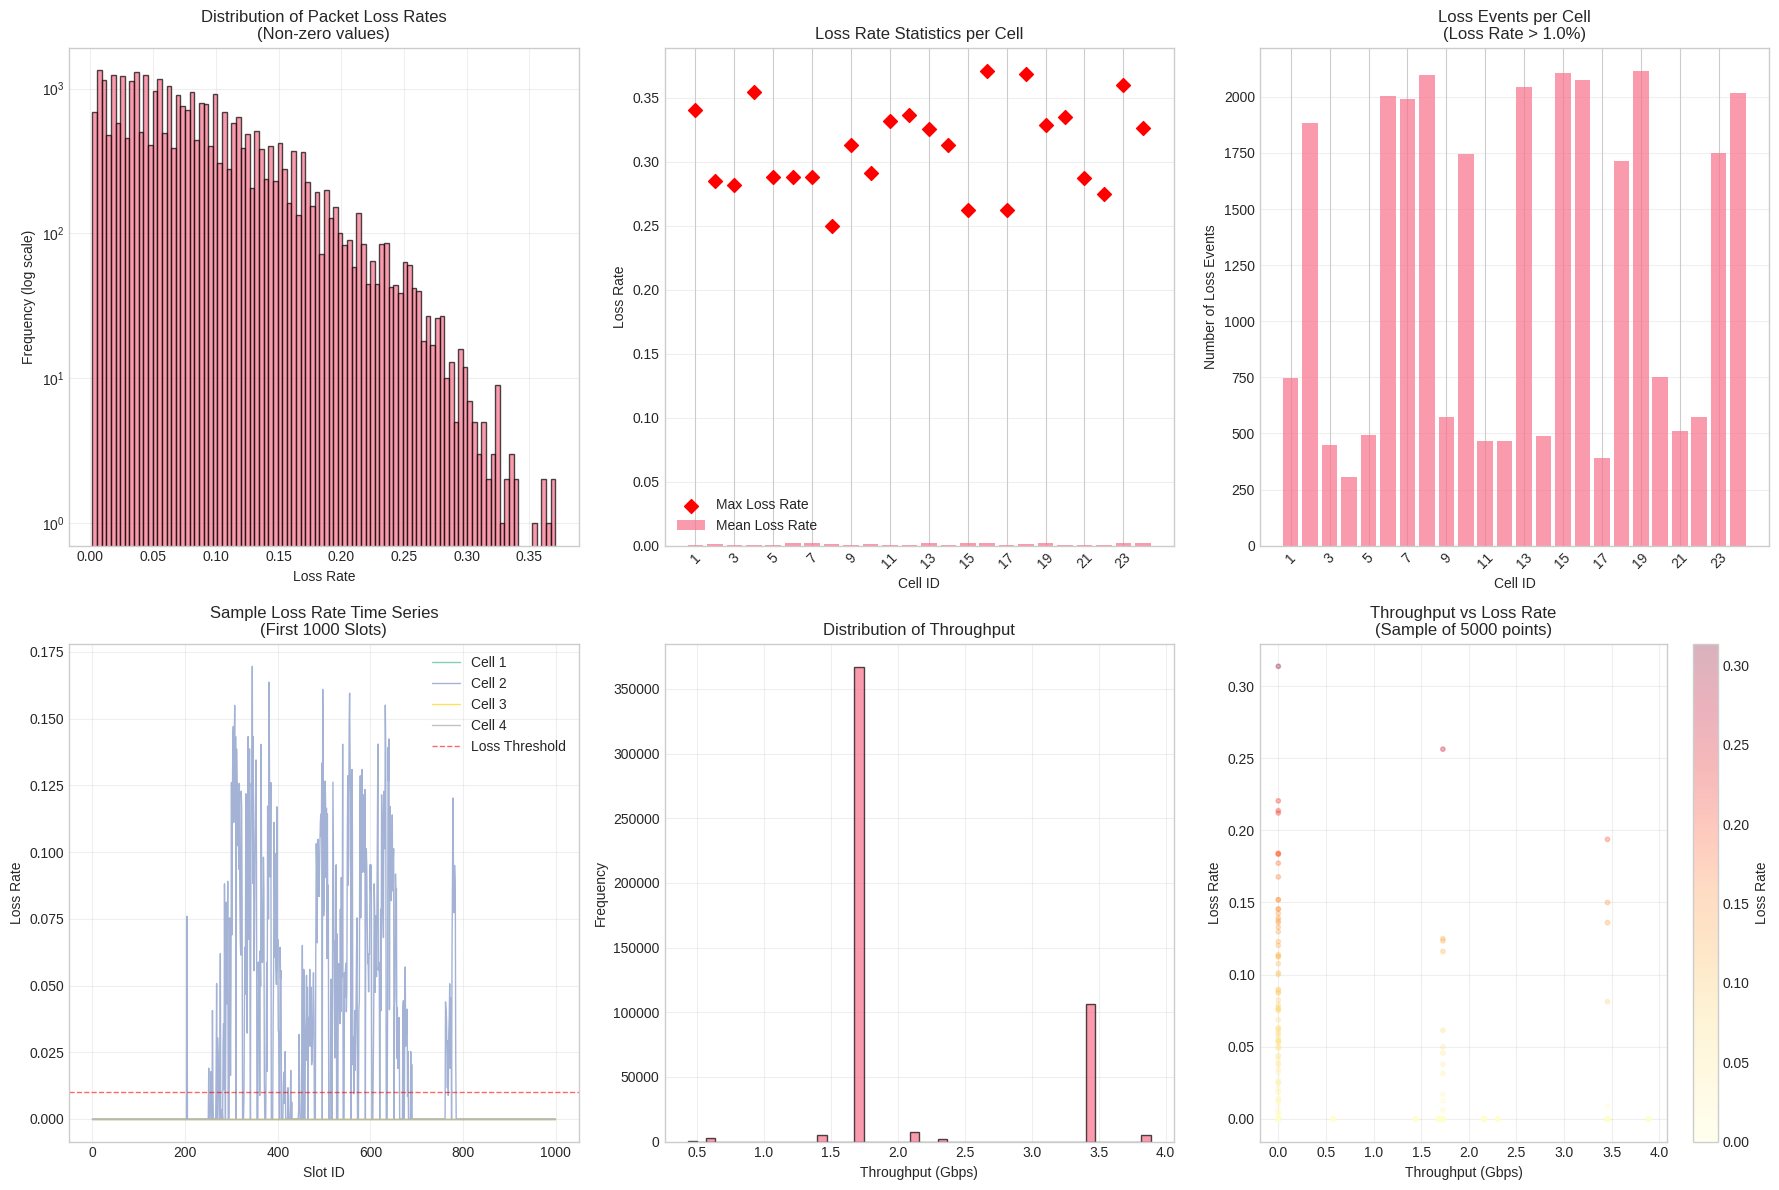

✅ EDA plots generated


In [8]:
cell_statistics = plot_eda(
    df_raw,
    config.OUTPUT_DIR,
    config.LOSS_THRESHOLD
)

In [11]:
preprocessor = SignalPreprocessor(config)

# Create binary loss signal
df_processed = preprocessor.create_binary_loss_signal(df_raw.copy())

# Engineer temporal features
df_processed = preprocessor.engineer_temporal_features(df_processed)

print(f"\n📊 Processed data shape: {df_processed.shape}")
print(f"📊 Columns: {df_processed.columns.tolist()}")


🔢 Creating binary loss signal...

   Binary loss events per cell:
      Cell  1:   729 events (threshold: 2.23%)
      Cell  2:  1581 events (threshold: 2.85%)
      Cell  3:   438 events (threshold: 1.63%)
      Cell  4:   302 events (threshold: 1.48%)
      Cell  5:   480 events (threshold: 1.45%)
      Cell  6:  1585 events (threshold: 3.17%)
      Cell  7:  1594 events (threshold: 3.16%)
      Cell  8:  1686 events (threshold: 2.62%)
      Cell  9:   562 events (threshold: 2.03%)
      Cell 10:  1423 events (threshold: 3.01%)
      Cell 11:   458 events (threshold: 1.80%)
      Cell 12:   458 events (threshold: 1.81%)
      Cell 13:  1606 events (threshold: 3.38%)
      Cell 14:   461 events (threshold: 1.95%)
      Cell 15:  1741 events (threshold: 2.84%)
      Cell 16:  1645 events (threshold: 3.33%)
      Cell 17:   380 events (threshold: 1.43%)
      Cell 18:  1447 events (threshold: 2.88%)
      Cell 19:  1655 events (threshold: 3.19%)
      Cell 20:   730 events (threshold: 

Processing cells:   0%|          | 0/24 [00:00<?, ?it/s]

✅ Added 8 new features: ['loss_lag1', 'loss_lag2', 'loss_lead1', 'loss_lead2', 'loss_rolling_mean', 'loss_rolling_max', 'loss_rolling_std', 'burst_duration']

📊 Processed data shape: (2198544, 23)
📊 Columns: ['timestamp_s', 'tx_packets', 'rx_packets', 'too_late_packets', 'slot_id', 'packets_received_valid', 'packets_lost', 'loss_rate', 'throughput_gbps', 'total_kilobits', 'throughput_mbps', 'cell_id', 'loss_threshold', 'loss_binary', 'loss_intensity', 'loss_lag1', 'loss_lag2', 'loss_lead1', 'loss_lead2', 'loss_rolling_mean', 'loss_rolling_max', 'loss_rolling_std', 'burst_duration']



⏱️  Aligning time series across cells...
   Creating loss signal matrix...
   Computing optimal lags between cell pairs...


Cells:   0%|          | 0/24 [00:00<?, ?it/s]


   Lags relative to Cell 1 (reference):
      Cell  1:  +0 slots
      Cell  2:  -3 slots
      Cell  3:  +3 slots
      Cell  4:  +0 slots
      Cell  5:  +0 slots
      Cell  6:  +5 slots
      Cell  7:  +4 slots
      Cell  8:  +0 slots
      Cell  9:  +0 slots
      Cell 10:  -4 slots
      Cell 11:  +5 slots
      Cell 12:  +0 slots
      Cell 13:  +4 slots
      Cell 14:  +0 slots
      Cell 15:  +4 slots
      Cell 16:  +5 slots
      Cell 17:  +0 slots
      Cell 18:  +0 slots
      Cell 19:  +1 slots
      Cell 20:  +0 slots
      Cell 21:  +0 slots
      Cell 22:  +0 slots
      Cell 23:  -3 slots
      Cell 24:  -2 slots

   Applying time alignment...
✅ Alignment complete


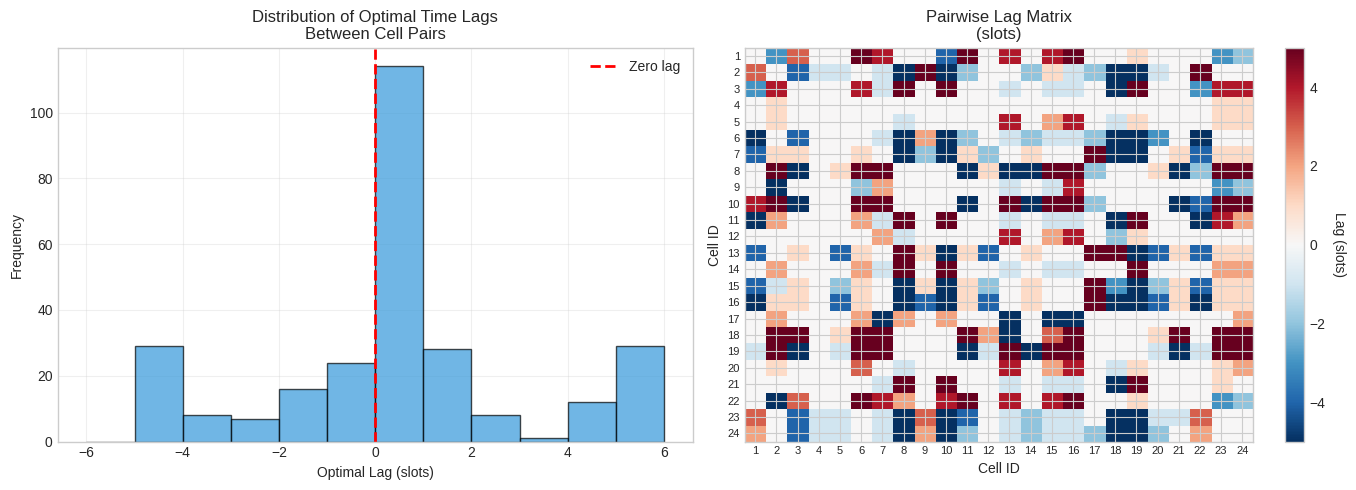


📊 Lag statistics:
   Mean absolute lag: 1.79 slots
   Max lag: 5 slots
   Std dev of lags: 2.68 slots


In [13]:
aligner = TimeSeriesAligner(config)
df_aligned, lag_matrix = aligner.align_all_cells(df_processed)

# Plot lag distribution
cells_list = sorted(df_aligned['cell_id'].unique())
aligner.plot_lag_distribution(cells_list, config.OUTPUT_DIR)

In [15]:
correlator = CorrelationAnalyzer(config)
correlation_matrix = correlator.analyze_all(df_aligned)

# Save correlation matrix
corr_df = pd.DataFrame(
    correlation_matrix,
    index=[int(c) for c in cells_list],
    columns=[int(c) for c in cells_list]
)
corr_df.to_csv(f'{config.OUTPUT_DIR}/correlation_matrix.csv')
print(f"\n💾 Correlation matrix saved to {config.OUTPUT_DIR}/correlation_matrix.csv")


🔬 Performing comprehensive correlation analysis...
📊 Computing Pearson correlation...
📊 Computing Spearman correlation...
📊 Computing Jaccard similarity...
📊 Computing ensemble correlation...
📊 Computing statistical significance...
   Bonferroni threshold: 3.62e-05
   Significant correlations: 152 out of 276

✅ Correlation analysis complete

   Metric Statistics:
   Metric          Min        Max        Mean       Std       
   -------------------------------------------------------
   Pearson         -0.013     0.951      0.088      0.230     
   Spearman        -0.013     0.931      0.085      0.221     
   Jaccard         0.000      0.797      0.066      0.168     
   Ensemble        -0.009     0.895      0.080      0.208     

💾 Correlation matrix saved to ./results/correlation_matrix.csv


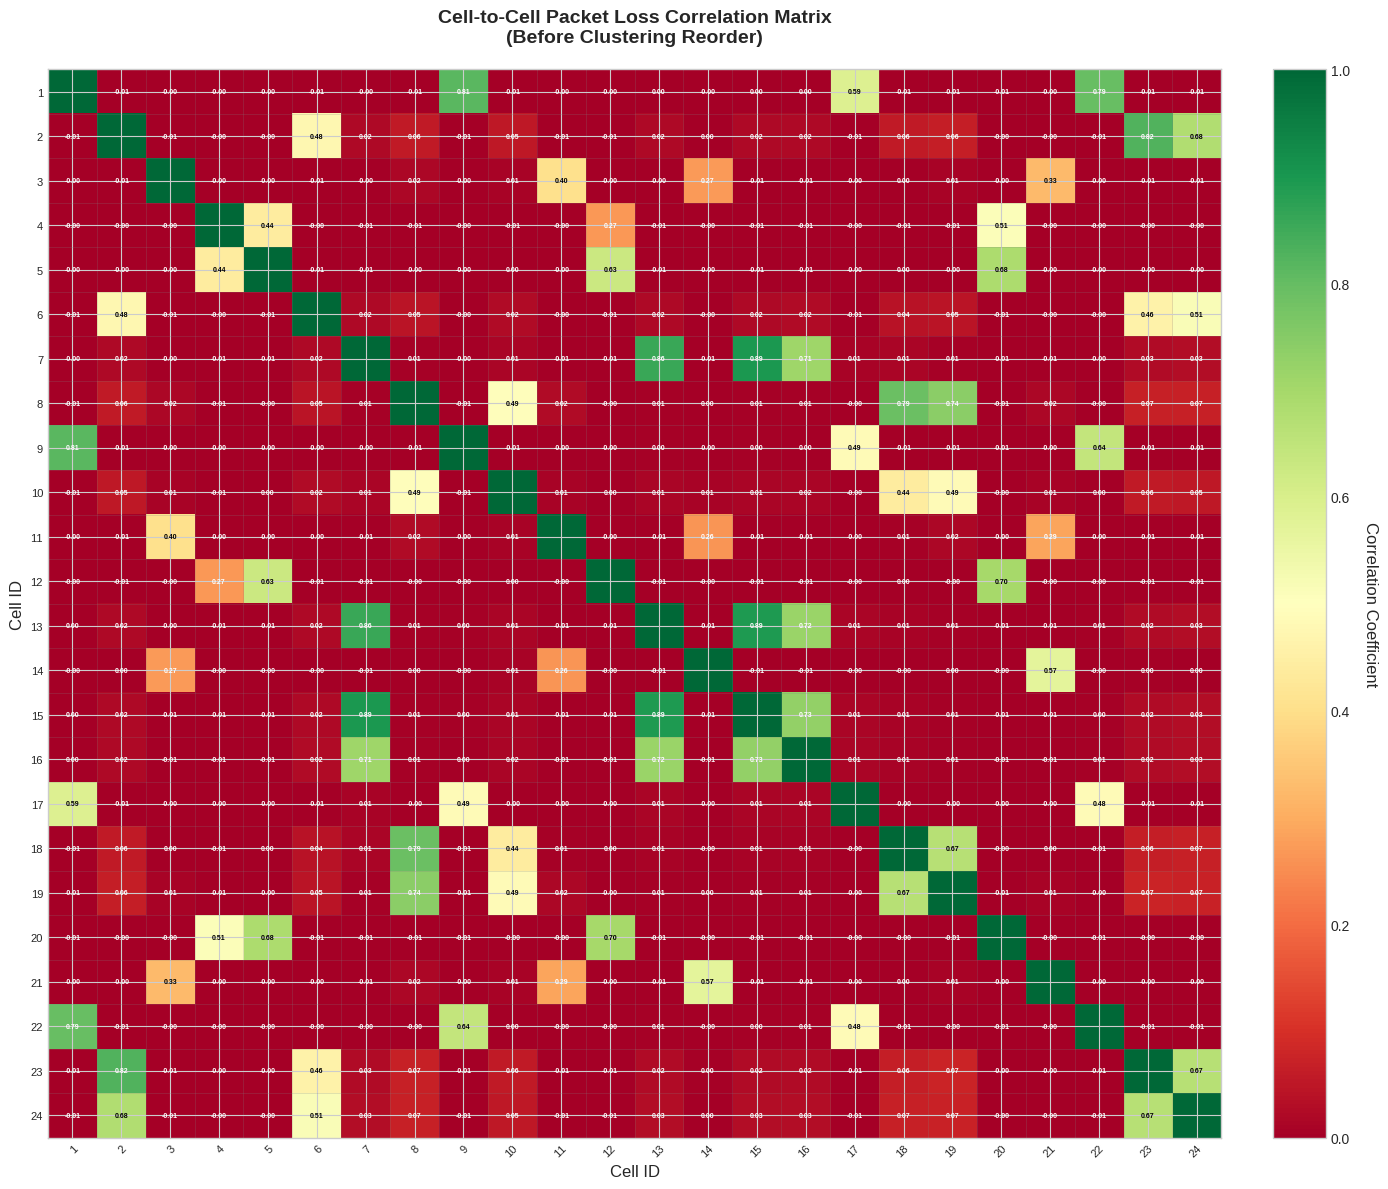

✅ Initial correlation heatmap saved


In [16]:
def plot_correlation_heatmap_initial(corr_matrix: np.ndarray, cells: List[int], output_dir: str):
    """Plot correlation heatmap without clustering reorder"""

    fig, ax = plt.subplots(figsize=(14, 12))

    # Create heatmap
    im = ax.imshow(corr_matrix, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)

    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Correlation Coefficient', rotation=270, labelpad=20, fontsize=12)

    # Set ticks
    n_cells = len(cells)
    tick_positions = np.arange(n_cells)
    ax.set_xticks(tick_positions)
    ax.set_yticks(tick_positions)
    ax.set_xticklabels([f'{int(c)}' for c in cells], fontsize=8)
    ax.set_yticklabels([f'{int(c)}' for c in cells], fontsize=8)

    # Rotate x labels
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Add minor grid
    ax.set_xticks(tick_positions - 0.5, minor=True)
    ax.set_yticks(tick_positions - 0.5, minor=True)
    ax.grid(which="minor", color="gray", linestyle='-', linewidth=0.5, alpha=0.3)

    # Annotate cells with values (only non-diagonal)
    for i in range(n_cells):
        for j in range(n_cells):
            if i != j:
                val = corr_matrix[i, j]
                color = "black" if 0.3 < val < 0.7 else "white"
                ax.text(j, i, f'{val:.2f}', ha="center", va="center",
                       color=color, fontsize=5, weight='bold')

    ax.set_title('Cell-to-Cell Packet Loss Correlation Matrix\n(Before Clustering Reorder)',
                fontsize=14, pad=20, weight='bold')
    ax.set_xlabel('Cell ID', fontsize=12)
    ax.set_ylabel('Cell ID', fontsize=12)

    plt.tight_layout()
    plt.savefig(f'{output_dir}/03_correlation_heatmap_initial.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("✅ Initial correlation heatmap saved")

plot_correlation_heatmap_initial(correlation_matrix, cells_list, config.OUTPUT_DIR)

In [18]:
clusterer = TopologyClusterer(config)

# Try hierarchical clustering
labels_hier, linkage_matrix = clusterer.hierarchical_clustering(
    correlation_matrix,
    n_clusters=config.N_EXPECTED_LINKS
)

# Try spectral clustering
labels_spectral = clusterer.spectral_clustering(
    correlation_matrix,
    n_clusters=config.N_EXPECTED_LINKS
)

# Compare methods
print("\n" + "="*80)
print("COMPARING CLUSTERING METHODS")
print("="*80)

quality_hier = clusterer.compute_cluster_quality(correlation_matrix, labels_hier)

print("\n" + "-"*80)

clusterer_spectral = TopologyClusterer(config)
quality_spectral = clusterer_spectral.compute_cluster_quality(correlation_matrix, labels_spectral)

print("\n" + "="*80)
print("METHOD COMPARISON SUMMARY")
print("="*80)
print(f"Hierarchical Silhouette Score: {quality_hier['silhouette_score']:.3f}")
print(f"Spectral Silhouette Score:     {quality_spectral['silhouette_score']:.3f}")

# Choose best method
if quality_hier['silhouette_score'] >= quality_spectral['silhouette_score']:
    print("\n✅ SELECTED METHOD: Hierarchical Clustering")
    final_labels = labels_hier
    final_quality = quality_hier
    final_clusterer = clusterer
else:
    print("\n✅ SELECTED METHOD: Spectral Clustering")
    final_labels = labels_spectral
    final_quality = quality_spectral
    final_clusterer = clusterer_spectral

print("="*80)


🌳 Performing hierarchical clustering...
   Method: average
   Target clusters: 3
✅ Clustering complete

   Cluster distribution:
      Cluster 0: 4 cells
      Cluster 1: 4 cells
      Cluster 2: 16 cells

🔮 Performing spectral clustering...
✅ Clustering complete

   Cluster distribution:
      Cluster 0: 16 cells
      Cluster 1: 4 cells
      Cluster 2: 4 cells

COMPARING CLUSTERING METHODS

📊 Computing cluster quality metrics...

   Quality Metrics:
   Metric                              Value          
   --------------------------------------------------
   Silhouette Score                    0.283          
   Davies-Bouldin Index                1.068          
   Within-Cluster Correlation          0.172          
   Between-Cluster Correlation         -0.004         
   Separation Ratio                    inf            

   Per-Cluster Statistics:
   Cluster    Size       Avg Corr        Min Corr        Max Corr       
   ------------------------------------------------------

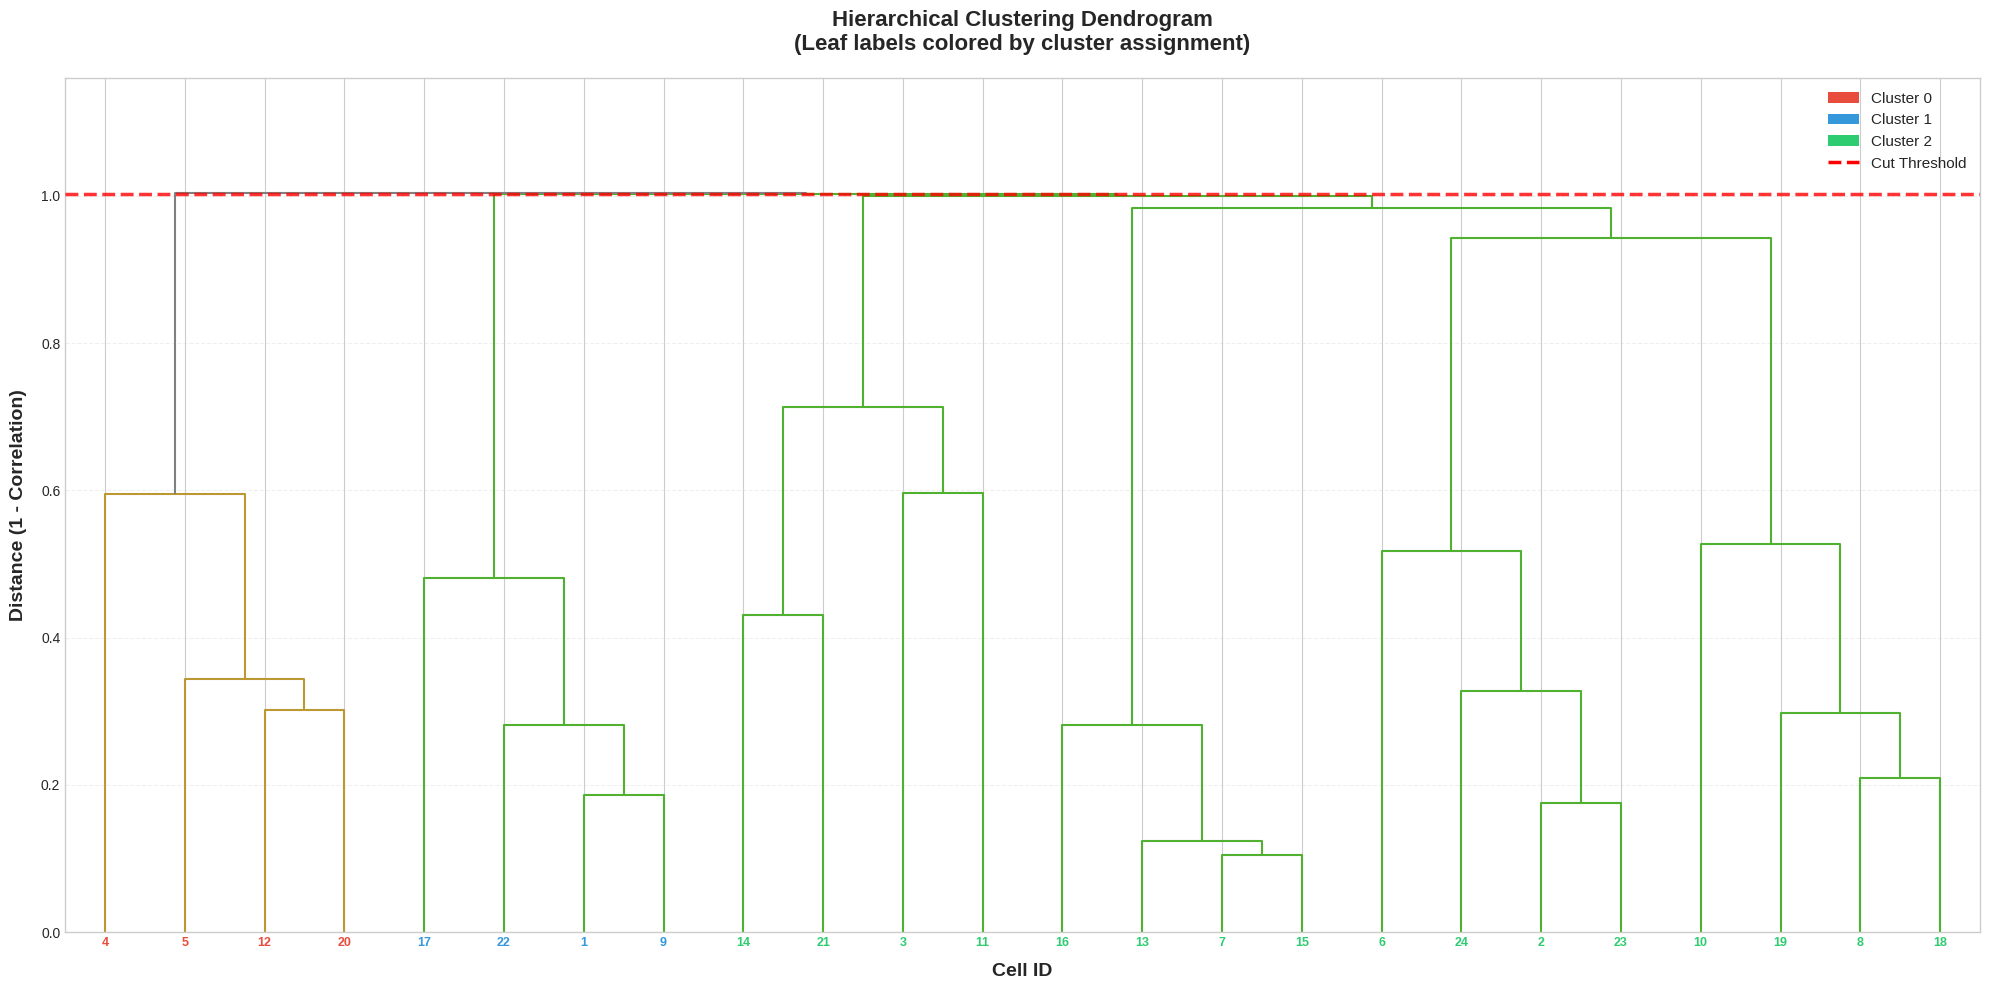

✅ Dendrogram saved

📊 Cluster composition (in dendrogram order):
   Cluster 0: [4, 5, 12, 20]
   Cluster 1: [1, 9, 17, 22]
   Cluster 2: [2, 3, 6, 7, 8, 10, 11, 13, 14, 15, 16, 18, 19, 21, 23, 24]


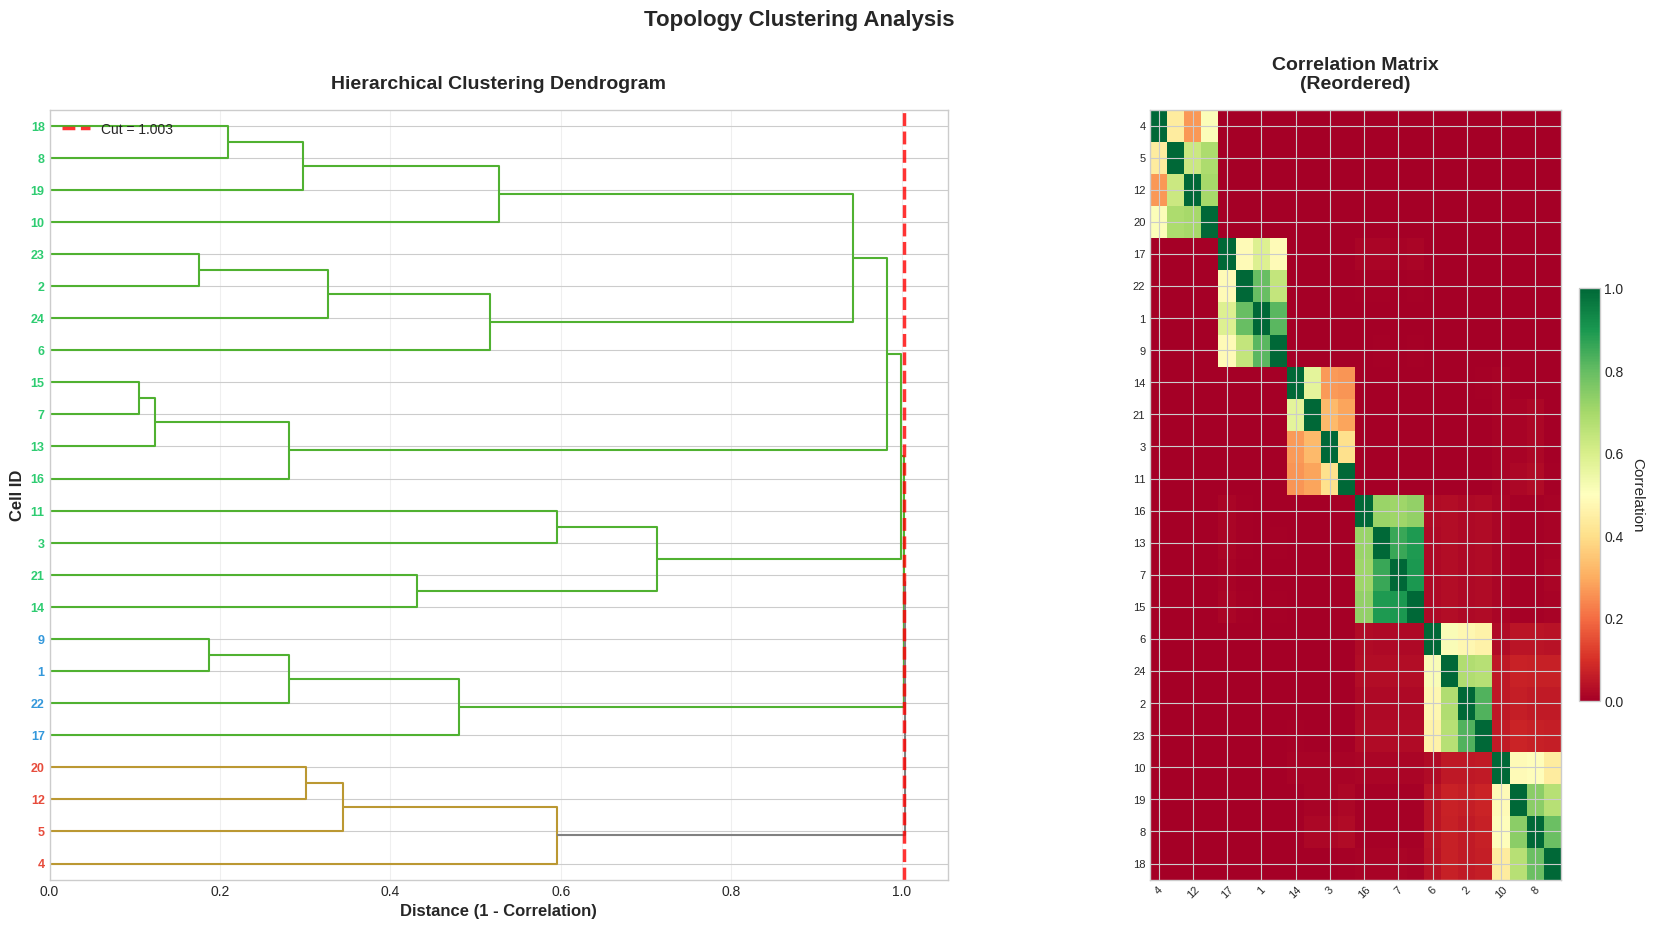

✅ Combined dendrogram and heatmap saved


In [19]:
# ============================================================================
# CELL 12: Dendrogram Visualization (CORRECTED)
# ============================================================================

def plot_dendrogram(linkage_matrix: np.ndarray, cells: List[int], labels: np.ndarray, output_dir: str):
    """Plot hierarchical clustering dendrogram with proper ordering"""

    fig, ax = plt.subplots(figsize=(20, 10))

    # Get number of clusters
    n_clusters = len(np.unique(labels))

    # Calculate color threshold to get desired number of clusters
    # The threshold should be between the (n_clusters-1)th and (n_clusters)th merge
    if linkage_matrix.shape[0] >= n_clusters - 1:
        # Get the merge distance for creating n_clusters
        cut_height = linkage_matrix[-(n_clusters-1), 2]
        color_threshold = cut_height + 0.001  # Slightly above cut height
    else:
        color_threshold = None

    # Create dendrogram with proper color threshold
    dendro = dendrogram(
        linkage_matrix,
        labels=[f'{int(c)}' for c in cells],
        ax=ax,
        color_threshold=color_threshold,
        above_threshold_color='#808080',
        leaf_font_size=10
    )

    # Get the order of leaves as they appear in the dendrogram
    leaf_order = dendro['leaves']

    # Create a mapping from dendrogram position to cluster color
    n_clusters = len(np.unique(labels))
    cluster_colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6', '#1abc9c'][:n_clusters]

    # Color the leaf labels by their actual cluster assignment
    xlbls = ax.get_xmajorticklabels()
    for i, lbl in enumerate(xlbls):
        try:
            cell_id = int(lbl.get_text())
            cell_idx = cells.index(cell_id)
            cluster_id = labels[cell_idx]
            lbl.set_color(cluster_colors[cluster_id])
            lbl.set_weight('bold')
            lbl.set_fontsize(9)
        except (ValueError, IndexError):
            pass

    # Rotate labels for better readability
    plt.setp(ax.get_xticklabels(), rotation=0, ha='center')

    ax.set_xlabel('Cell ID', fontsize=14, weight='bold', labelpad=10)
    ax.set_ylabel('Distance (1 - Correlation)', fontsize=14, weight='bold', labelpad=10)
    ax.set_title('Hierarchical Clustering Dendrogram\n(Leaf labels colored by cluster assignment)',
                fontsize=16, pad=20, weight='bold')
    ax.grid(True, axis='y', alpha=0.3, linestyle='--')

    # Add cut line
    if linkage_matrix.shape[0] >= n_clusters - 1:
        cut_height = linkage_matrix[-(n_clusters-1), 2]
        ax.axhline(y=cut_height, color='red', linestyle='--', linewidth=2.5,
                  label=f'Cut threshold = {cut_height:.3f}', alpha=0.8, zorder=10)

    # Add legend for clusters
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=cluster_colors[i], label=f'Cluster {i}')
                      for i in range(n_clusters)]
    legend_elements.append(plt.Line2D([0], [0], color='red', linewidth=2.5,
                                     linestyle='--', label='Cut Threshold'))

    ax.legend(handles=legend_elements, fontsize=11, loc='upper right',
             framealpha=0.9, edgecolor='black')

    # Set y-axis limits with some padding
    ymin, ymax = ax.get_ylim()
    ax.set_ylim(0, ymax * 1.1)

    plt.tight_layout()
    plt.savefig(f'{output_dir}/04_dendrogram.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("✅ Dendrogram saved")

    # Print cluster composition in dendrogram order
    print("\n📊 Cluster composition (in dendrogram order):")
    for cluster_id in range(n_clusters):
        cluster_cells = [int(cells[i]) for i, lbl in enumerate(labels) if lbl == cluster_id]
        print(f"   Cluster {cluster_id}: {cluster_cells}")

# Plot dendrogram
if linkage_matrix is not None:
    plot_dendrogram(linkage_matrix, cells_list, final_labels, config.OUTPUT_DIR)
else:
    print("⚠️  No linkage matrix available - skipping dendrogram")


# ============================================================================
# ALTERNATIVE: Side-by-side Dendrogram with Heatmap
# ============================================================================

def plot_dendrogram_with_heatmap(linkage_matrix: np.ndarray, corr_matrix: np.ndarray,
                                  cells: List[int], labels: np.ndarray, output_dir: str):
    """Plot dendrogram alongside correlation heatmap"""

    from scipy.cluster.hierarchy import dendrogram, leaves_list

    fig = plt.figure(figsize=(20, 10))

    # Create grid
    gs = fig.add_gridspec(1, 2, width_ratios=[2, 1], wspace=0.3)

    # LEFT: Dendrogram
    ax_dendro = fig.add_subplot(gs[0, 0])

    n_clusters = len(np.unique(labels))

    if linkage_matrix.shape[0] >= n_clusters - 1:
        cut_height = linkage_matrix[-(n_clusters-1), 2]
        color_threshold = cut_height + 0.001
    else:
        color_threshold = None

    dendro = dendrogram(
        linkage_matrix,
        labels=[f'{int(c)}' for c in cells],
        ax=ax_dendro,
        color_threshold=color_threshold,
        above_threshold_color='#808080',
        leaf_font_size=9,
        orientation='right'  # Horizontal dendrogram
    )

    # Color labels
    cluster_colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6'][:n_clusters]
    ylbls = ax_dendro.get_ymajorticklabels()

    for lbl in ylbls:
        try:
            cell_id = int(lbl.get_text())
            cell_idx = cells.index(cell_id)
            cluster_id = labels[cell_idx]
            lbl.set_color(cluster_colors[cluster_id])
            lbl.set_weight('bold')
        except (ValueError, IndexError):
            pass

    ax_dendro.set_xlabel('Distance (1 - Correlation)', fontsize=12, weight='bold')
    ax_dendro.set_ylabel('Cell ID', fontsize=12, weight='bold')
    ax_dendro.set_title('Hierarchical Clustering Dendrogram', fontsize=14, weight='bold', pad=15)
    ax_dendro.grid(True, axis='x', alpha=0.3)

    if linkage_matrix.shape[0] >= n_clusters - 1:
        ax_dendro.axvline(x=cut_height, color='red', linestyle='--', linewidth=2.5,
                         label=f'Cut = {cut_height:.3f}', alpha=0.8)
        ax_dendro.legend(fontsize=10)

    # RIGHT: Reordered correlation matrix
    ax_heatmap = fig.add_subplot(gs[0, 1])

    # Get dendrogram leaf order
    leaf_order = dendro['leaves']

    # Reorder correlation matrix
    corr_reordered = corr_matrix[leaf_order, :][:, leaf_order]
    cells_reordered = [cells[i] for i in leaf_order]

    # Plot heatmap
    im = ax_heatmap.imshow(corr_reordered, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)

    n_cells = len(cells_reordered)
    tick_positions = np.arange(n_cells)

    ax_heatmap.set_xticks(tick_positions[::2])
    ax_heatmap.set_yticks(tick_positions)
    ax_heatmap.set_xticklabels([f'{int(cells_reordered[i])}' for i in range(0, n_cells, 2)],
                               fontsize=8, rotation=45)
    ax_heatmap.set_yticklabels([f'{int(c)}' for c in cells_reordered], fontsize=8)

    ax_heatmap.set_title('Correlation Matrix\n(Reordered)', fontsize=14, weight='bold', pad=15)

    # Colorbar
    cbar = plt.colorbar(im, ax=ax_heatmap, fraction=0.046, pad=0.04)
    cbar.set_label('Correlation', rotation=270, labelpad=15, fontsize=11)

    plt.suptitle('Topology Clustering Analysis', fontsize=16, weight='bold', y=0.98)

    plt.savefig(f'{output_dir}/04b_dendrogram_with_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("✅ Combined dendrogram and heatmap saved")

# Plot combined visualization
if linkage_matrix is not None:
    plot_dendrogram_with_heatmap(linkage_matrix, correlation_matrix,
                                  cells_list, final_labels, config.OUTPUT_DIR)

In [22]:
# Extract topology
extractor = TopologyExtractor(config)
topology = extractor.assign_link_ids(final_labels, cells_list)
topology = extractor.compute_link_statistics(df_aligned, topology)

# Generate report
report_text = extractor.generate_text_report(topology, final_quality)
print("\n" + report_text)

# Save outputs
with open(f'{config.OUTPUT_DIR}/topology_report.txt', 'w') as f:
    f.write(report_text)
print(f"\n💾 Report saved to {config.OUTPUT_DIR}/topology_report.txt")

extractor.export_to_json(topology, final_quality, f'{config.OUTPUT_DIR}/topology.json')


🗺️  Extracting network topology...

   Inferred Topology:
   Link_A: [4, 5, 12, 20]
   Link_B: [1, 9, 17, 22]
   Link_C: [2, 3, 6, 7, 8, 10, 11, 13, 14, 15, 16, 18, 19, 21, 23, 24]

📊 Computing link statistics...

FRONTHAUL NETWORK TOPOLOGY INFERENCE REPORT

Analysis Date: 2026-02-03 17:27:37
Number of Cells Analyzed: 24
Number of Links Identified: 3

METHODOLOGY
--------------------------------------------------------------------------------
1. Data Loading:
   - Loaded throughput and packet statistics for all cells
   - Processed symbol-level throughput data
   - Calculated packet loss from RU-side statistics

2. Signal Processing:
   - Created binary loss indicators with adaptive thresholds
   - Engineered temporal features (lags, rolling statistics)
   - Applied time-series alignment using cross-correlation

3. Correlation Analysis:
   - Computed Pearson correlation (linear relationships)
   - Computed Spearman correlation (rank-based, robust)
   - Computed Jaccard similarity (eve

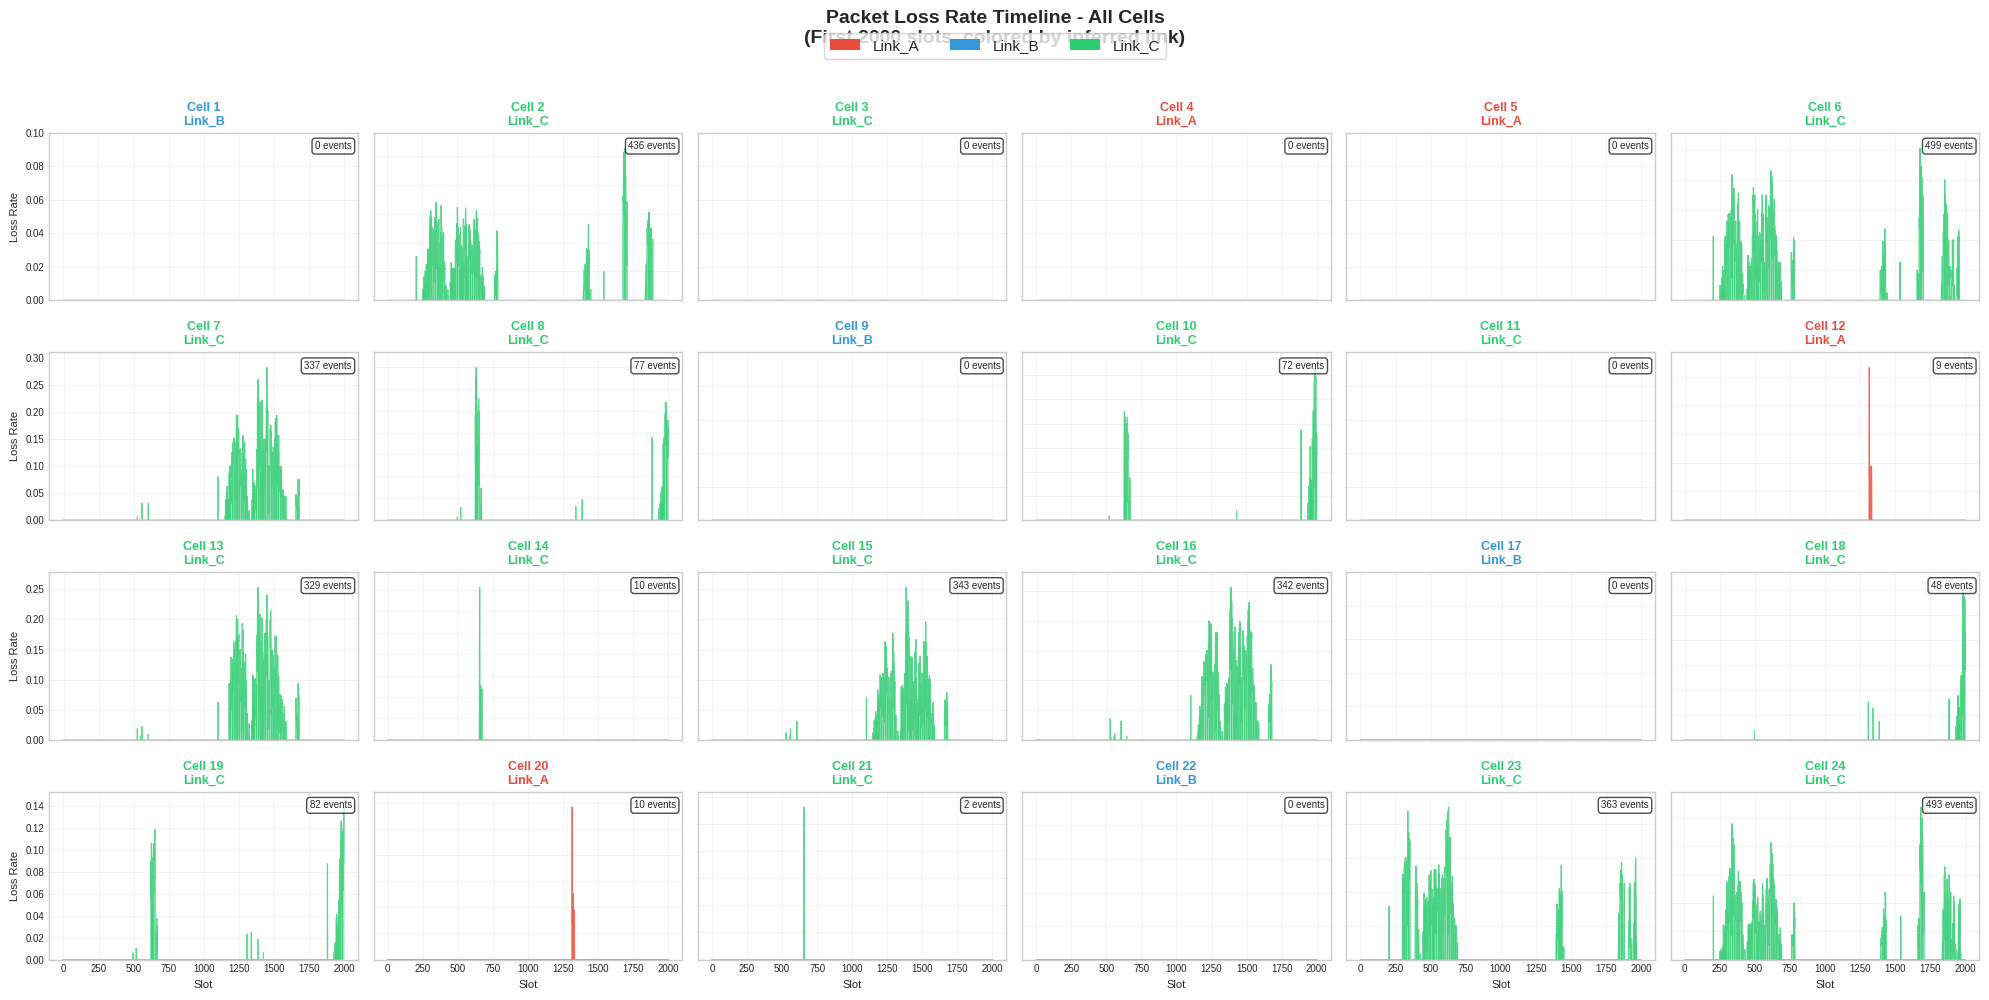

✅ Loss timeline visualization saved


In [23]:
def plot_loss_timeline_all_cells(df: pd.DataFrame, topology: Dict, output_dir: str):
    """Plot time series of loss rates for all cells, colored by cluster"""

    cells = sorted(df['cell_id'].unique())
    n_cells = len(cells)

    # Create cell-to-link mapping
    cell_to_link = {}
    link_colors = {'Link_A': '#e74c3c', 'Link_B': '#3498db', 'Link_C': '#2ecc71'}

    for link_name, link_data in topology.items():
        for cell_id in link_data['cells']:
            cell_to_link[cell_id] = link_name

    # Create figure with subplots
    n_cols = 6
    n_rows = int(np.ceil(n_cells / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 2.5))
    axes = axes.flatten()

    # Get time range (use first 2000 slots for clarity)
    slot_col = 'slot_id_aligned' if 'slot_id_aligned' in df.columns else 'slot_id'
    max_slots = min(2000, df[slot_col].max())

    for idx, cell_id in enumerate(cells):
        ax = axes[idx]

        # Get data for this cell
        cell_data = df[df['cell_id'] == cell_id].copy()
        cell_data = cell_data[cell_data[slot_col] <= max_slots].sort_values(slot_col)

        # Get link and color
        link_name = cell_to_link.get(cell_id, 'Unknown')
        color = link_colors.get(link_name, 'gray')

        # Plot loss rate
        ax.plot(cell_data[slot_col], cell_data['loss_rate'],
               color=color, linewidth=0.8, alpha=0.7)

        # Highlight congestion events (loss > threshold)
        congestion_mask = cell_data['loss_rate'] > config.LOSS_THRESHOLD
        if congestion_mask.any():
            ax.fill_between(cell_data[slot_col], 0, cell_data['loss_rate'],
                           where=congestion_mask, alpha=0.3, color=color)

        # Formatting
        ax.set_title(f'Cell {int(cell_id)}\n{link_name}',
                    fontsize=9, weight='bold', color=color)
        ax.set_ylim(0, cell_data['loss_rate'].max() * 1.1 if cell_data['loss_rate'].max() > 0 else 0.1)
        ax.grid(True, alpha=0.3, linewidth=0.5)
        ax.tick_params(labelsize=7)

        # Only show labels on edge subplots
        if idx >= n_cells - n_cols:  # Bottom row
            ax.set_xlabel('Slot', fontsize=8)
        else:
            ax.set_xticklabels([])

        if idx % n_cols == 0:  # Left column
            ax.set_ylabel('Loss Rate', fontsize=8)
        else:
            ax.set_yticklabels([])

        # Add congestion event count
        n_events = congestion_mask.sum()
        ax.text(0.98, 0.95, f'{n_events} events',
               transform=ax.transAxes, fontsize=7,
               ha='right', va='top',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

    # Hide unused subplots
    for idx in range(n_cells, len(axes)):
        axes[idx].axis('off')

    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=link_colors[link], label=link)
                      for link in sorted(topology.keys())]

    fig.legend(handles=legend_elements, loc='upper center',
              ncol=len(topology), fontsize=11, frameon=True,
              bbox_to_anchor=(0.5, 0.98))

    plt.suptitle('Packet Loss Rate Timeline - All Cells\n(First 2000 slots, colored by inferred link)',
                fontsize=14, weight='bold', y=0.995)

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.savefig(f'{output_dir}/06_loss_timeline_all_cells.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("✅ Loss timeline visualization saved")

# Generate loss timeline
plot_loss_timeline_all_cells(df_aligned, topology, config.OUTPUT_DIR)

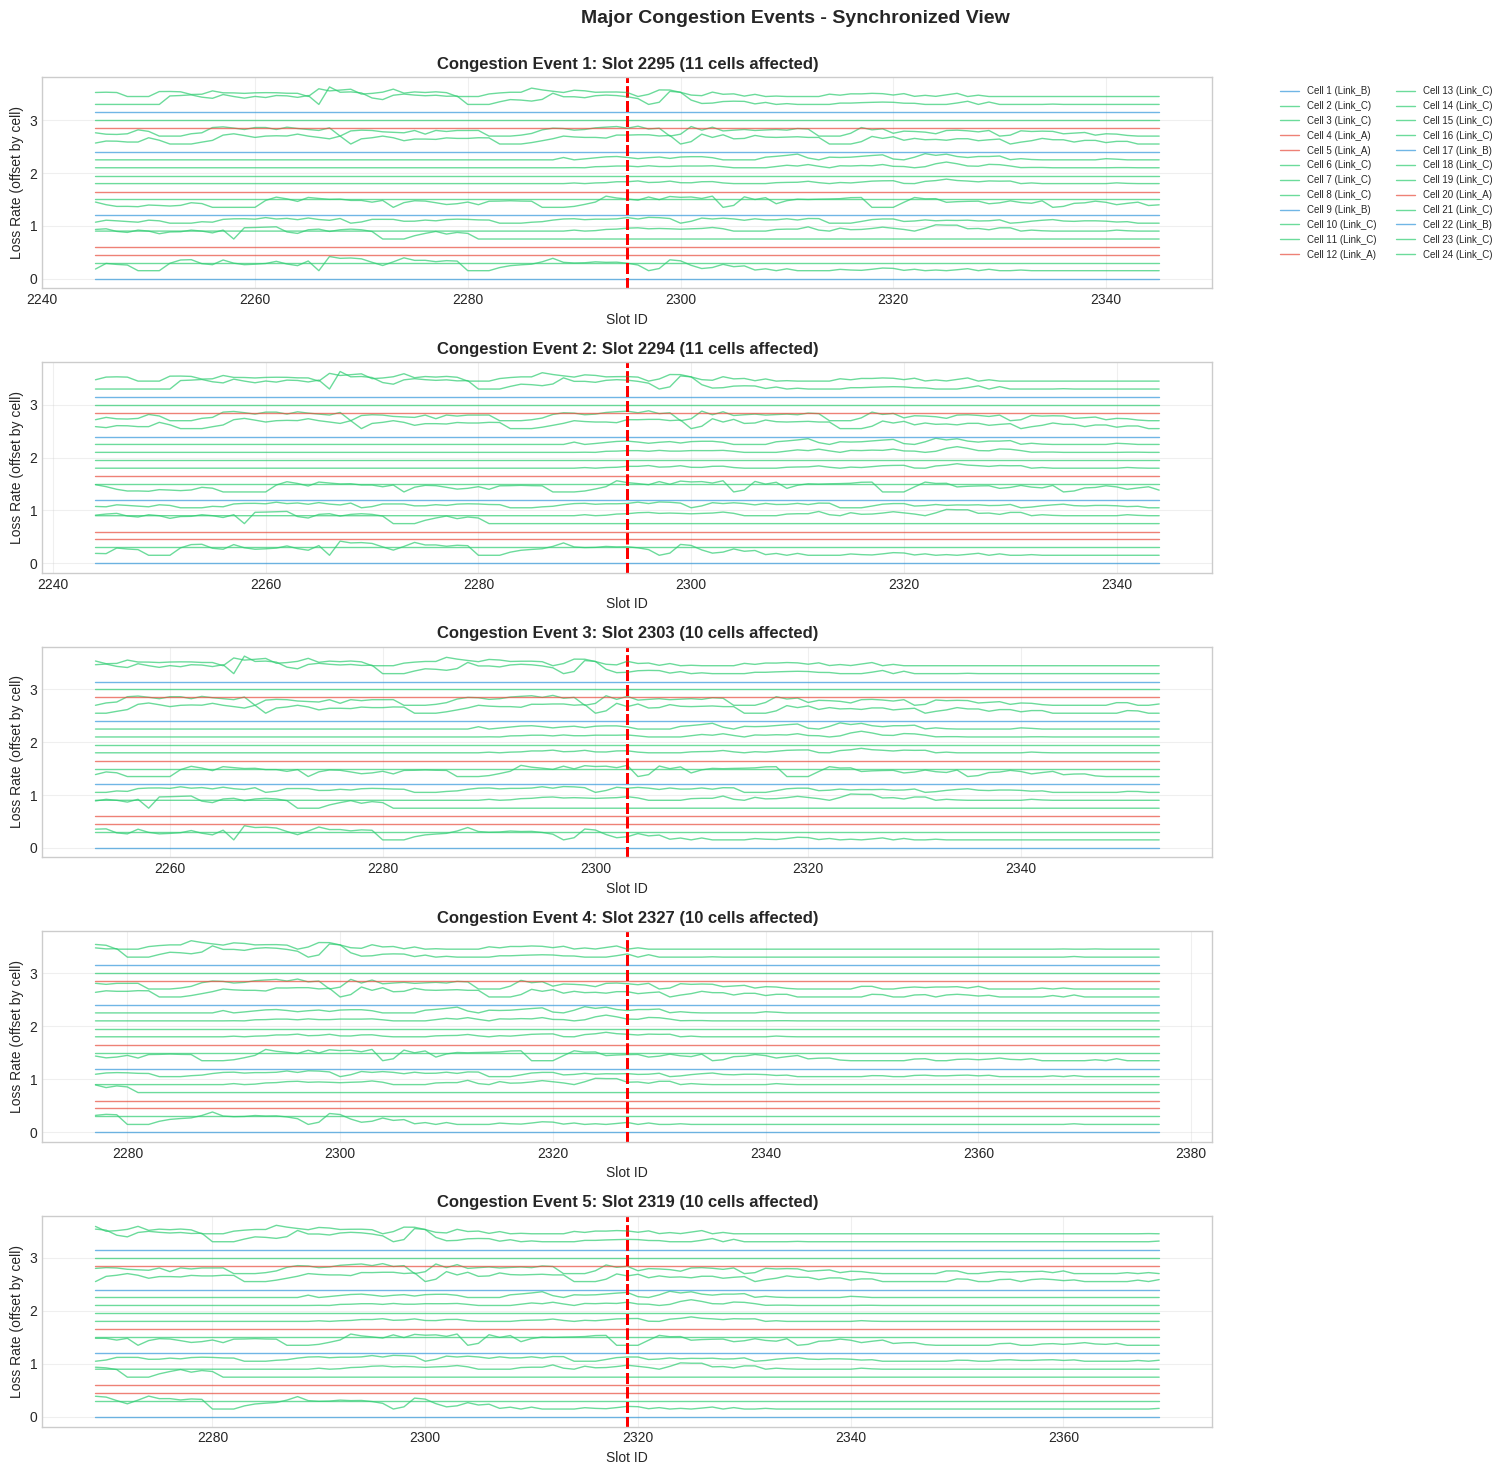

✅ Synchronized events visualization saved (showing 5 major events)


In [24]:
def plot_synchronized_loss_events(df: pd.DataFrame, topology: Dict, output_dir: str):
    """Plot synchronized view showing correlated loss events"""

    slot_col = 'slot_id_aligned' if 'slot_id_aligned' in df.columns else 'slot_id'

    # Find major congestion periods (when multiple cells have loss)
    loss_counts = df[df['loss_binary'] == 1].groupby(slot_col).size()
    major_events = loss_counts[loss_counts >= 3].sort_values(ascending=False).head(5)

    if len(major_events) == 0:
        print("⚠️  No major congestion events found")
        return

    fig, axes = plt.subplots(len(major_events), 1, figsize=(16, 3 * len(major_events)))

    if len(major_events) == 1:
        axes = [axes]

    link_colors = {'Link_A': '#e74c3c', 'Link_B': '#3498db', 'Link_C': '#2ecc71'}

    # Create cell-to-link mapping
    cell_to_link = {}
    for link_name, link_data in topology.items():
        for cell_id in link_data['cells']:
            cell_to_link[cell_id] = link_name

    for event_idx, (event_slot, n_cells_affected) in enumerate(major_events.items()):
        ax = axes[event_idx]

        # Get window around event
        window_start = max(0, event_slot - 50)
        window_end = event_slot + 50

        window_data = df[(df[slot_col] >= window_start) & (df[slot_col] <= window_end)]

        # Plot each cell
        cells = sorted(window_data['cell_id'].unique())

        for i, cell_id in enumerate(cells):
            cell_data = window_data[window_data['cell_id'] == cell_id].sort_values(slot_col)

            link_name = cell_to_link.get(cell_id, 'Unknown')
            color = link_colors.get(link_name, 'gray')

            # Offset each cell vertically for clarity
            offset = i * 0.15

            ax.plot(cell_data[slot_col], cell_data['loss_rate'] + offset,
                   color=color, linewidth=1, alpha=0.7, label=f'Cell {int(cell_id)} ({link_name})')

            # Mark the specific event slot
            ax.axvline(x=event_slot, color='red', linestyle='--', linewidth=2, alpha=0.5)

        ax.set_xlabel('Slot ID', fontsize=10)
        ax.set_ylabel('Loss Rate (offset by cell)', fontsize=10)
        ax.set_title(f'Congestion Event {event_idx + 1}: Slot {int(event_slot)} '
                    f'({int(n_cells_affected)} cells affected)',
                    fontsize=12, weight='bold')
        ax.grid(True, alpha=0.3)

        # Add legend only for first plot
        if event_idx == 0:
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=7, ncol=2)

    plt.suptitle('Major Congestion Events - Synchronized View',
                fontsize=14, weight='bold')
    plt.tight_layout(rect=[0, 0, 0.95, 0.98])
    plt.savefig(f'{output_dir}/07_synchronized_events.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"✅ Synchronized events visualization saved (showing {len(major_events)} major events)")

# Generate synchronized events plot
plot_synchronized_loss_events(df_aligned, topology, config.OUTPUT_DIR)

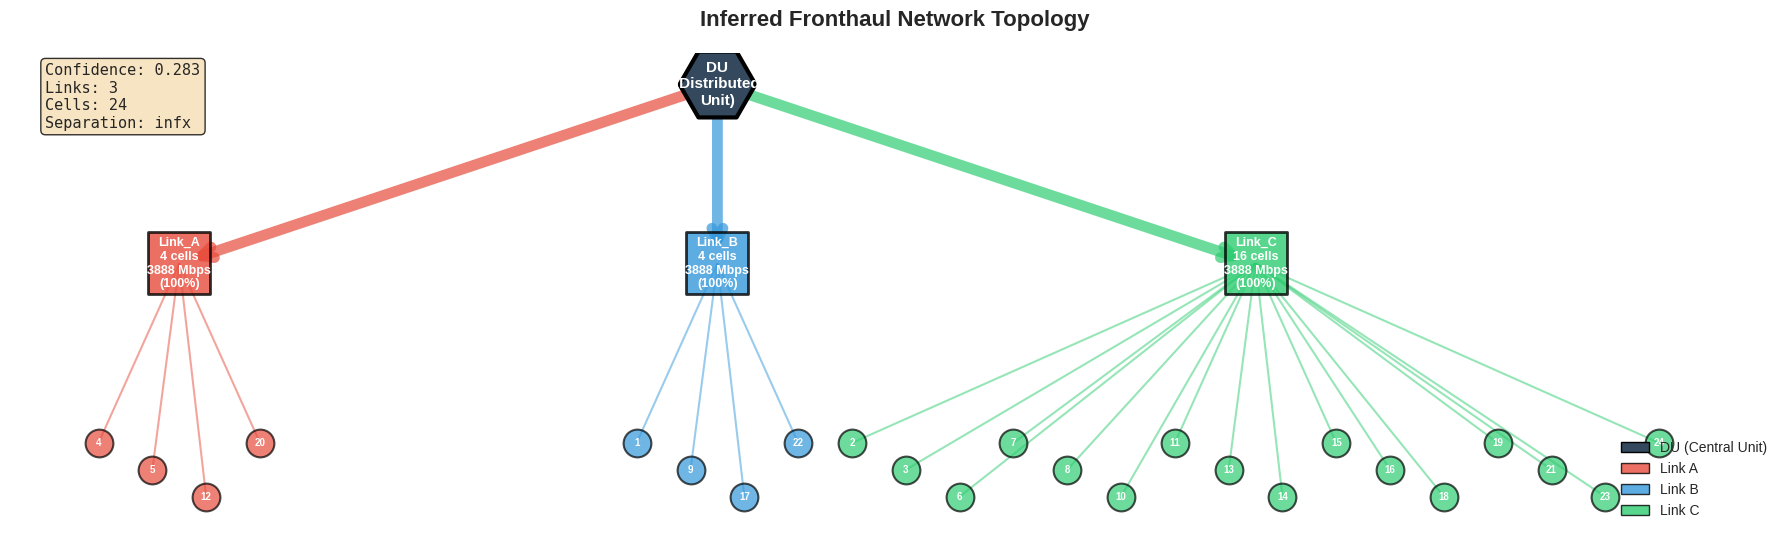

✅ Network topology graph saved


In [25]:
def plot_network_topology_graph(topology: Dict, quality_metrics: Dict, output_dir: str):
    """Create network topology graph using NetworkX"""

    # Create graph
    G = nx.Graph()

    # Add DU node (central)
    G.add_node('DU', node_type='du')

    # Add link nodes and edges
    link_colors = {'Link_A': '#e74c3c', 'Link_B': '#3498db', 'Link_C': '#2ecc71'}

    for link_name, link_data in topology.items():
        # Add link node
        G.add_node(link_name, node_type='link',
                  cells=link_data['cells'],
                  utilization=link_data.get('estimated_utilization', 0))

        # Connect link to DU
        throughput = link_data.get('peak_throughput_mbps', 0)
        width = max(2, throughput / 500)  # Scale width by throughput
        color = link_colors.get(link_name, 'gray')
        G.add_edge('DU', link_name, weight=throughput, edge_type='link_to_du', color=color, width=width)

        # Add cell nodes and connect to link
        for cell_id in link_data['cells']:
            cell_node = f'Cell_{cell_id}'
            G.add_node(cell_node, node_type='cell', cell_id=cell_id)
            G.add_edge(link_name, cell_node, edge_type='cell_to_link')

    # Create layout
    pos = {}

    # Position DU at top center
    pos['DU'] = (0, 2)

    # Position links in middle row
    link_names = sorted([k for k in topology.keys()])
    n_links = len(link_names)
    link_spacing = 3

    for i, link_name in enumerate(link_names):
        x_pos = (i - (n_links - 1) / 2) * link_spacing
        pos[link_name] = (x_pos, 1)

    # Position cells at bottom
    for link_idx, link_name in enumerate(link_names):
        cells = topology[link_name]['cells']
        n_cells = len(cells)

        x_center = (link_idx - (n_links - 1) / 2) * link_spacing

        for cell_idx, cell_id in enumerate(cells):
            x_offset = (cell_idx - (n_cells - 1) / 2) * 0.3
            y_pos = 0 - (cell_idx % 3) * 0.15  # Stagger vertically if many cells
            pos[f'Cell_{cell_id}'] = (x_center + x_offset, y_pos)

    # Create figure
    fig, ax = plt.subplots(figsize=(18, 12))

    # Draw edges
    # DU to Links (thick lines)
    for u, v, data in G.edges(data=True):
        if data.get('edge_type') == 'link_to_du':
            nx.draw_networkx_edges(G, pos, edgelist=[(u,v)], width=data['width'], alpha=0.7,
                                 edge_color=data['color'], ax=ax, arrows=True,
                                 arrowsize=20, arrowstyle='->')

    # Links to Cells (thin lines)
    cell_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('edge_type') == 'cell_to_link']
    for link_name in link_names:
        link_cell_edges = [e for e in cell_edges if e[0] == link_name]
        color = link_colors.get(link_name, 'gray')
        nx.draw_networkx_edges(G, pos, link_cell_edges, width=1.5, alpha=0.5,
                             edge_color=color, ax=ax)

    # Draw nodes
    # DU node (large hexagon)
    nx.draw_networkx_nodes(G, pos, ['DU'], node_color='#34495e',
                          node_shape='H', node_size=3000, ax=ax,
                          edgecolors='black', linewidths=3)

    # Link nodes (medium rectangles)
    for link_name in link_names:
        color = link_colors.get(link_name, 'gray')
        nx.draw_networkx_nodes(G, pos, [link_name], node_color=color,
                             node_shape='s', node_size=2000, ax=ax,
                             edgecolors='black', linewidths=2, alpha=0.8)

    # Cell nodes (small circles)
    for link_name in link_names:
        cells = topology[link_name]['cells']
        cell_nodes = [f'Cell_{cid}' for cid in cells]
        color = link_colors.get(link_name, 'gray')
        nx.draw_networkx_nodes(G, pos, cell_nodes, node_color=color,
                             node_shape='o', node_size=400, ax=ax,
                             edgecolors='black', linewidths=1.5, alpha=0.7)

    # Draw labels
    # DU label
    nx.draw_networkx_labels(G, pos, {'DU': 'DU\n(Distributed\nUnit)'},
                           font_size=11, font_weight='bold',
                           font_color='white', ax=ax)

    # Link labels
    link_labels = {}
    for link_name, link_data in topology.items():
        n_cells = link_data['cell_count']
        util = link_data.get('estimated_utilization', 0)
        tput = link_data.get('peak_throughput_mbps', 0)
        link_labels[link_name] = f'{link_name}\n{n_cells} cells\n{tput:.0f} Mbps\n({util:.0%})'

    nx.draw_networkx_labels(G, pos, link_labels,
                           font_size=9, font_weight='bold',
                           font_color='white', ax=ax)

    # Cell labels
    cell_labels = {f'Cell_{cid}': f'{int(cid)}'
                  for link_data in topology.values()
                  for cid in link_data['cells']}

    nx.draw_networkx_labels(G, pos, cell_labels,
                           font_size=7, font_weight='bold',
                           font_color='white', ax=ax)

    # Add title and info
    ax.set_title('Inferred Fronthaul Network Topology',
                fontsize=16, weight='bold', pad=20)

    # Add statistics box
    stats_text = (
        f"Confidence: {quality_metrics['silhouette_score']:.3f}\n"
        f"Links: {len(topology)}\n"
        f"Cells: {sum([link['cell_count'] for link in topology.values()])}\n"
        f"Separation: {quality_metrics['separation_ratio']:.2f}x"
    )

    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
           fontsize=11, verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
           family='monospace')

    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#34495e', label='DU (Central Unit)', edgecolor='black'),
        Patch(facecolor=link_colors['Link_A'], label='Link A', edgecolor='black', alpha=0.8),
        Patch(facecolor=link_colors['Link_B'], label='Link B', edgecolor='black', alpha=0.8),
        Patch(facecolor=link_colors['Link_C'], label='Link C', edgecolor='black', alpha=0.8),
    ]

    ax.legend(handles=legend_elements, loc='lower right', fontsize=10,
             framealpha=0.9, edgecolor='black')

    ax.axis('off')
    ax.set_aspect('equal')

    plt.tight_layout()
    plt.savefig(f'{output_dir}/08_network_topology_graph.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("✅ Network topology graph saved")

# Generate network topology graph
plot_network_topology_graph(topology, final_quality, config.OUTPUT_DIR)

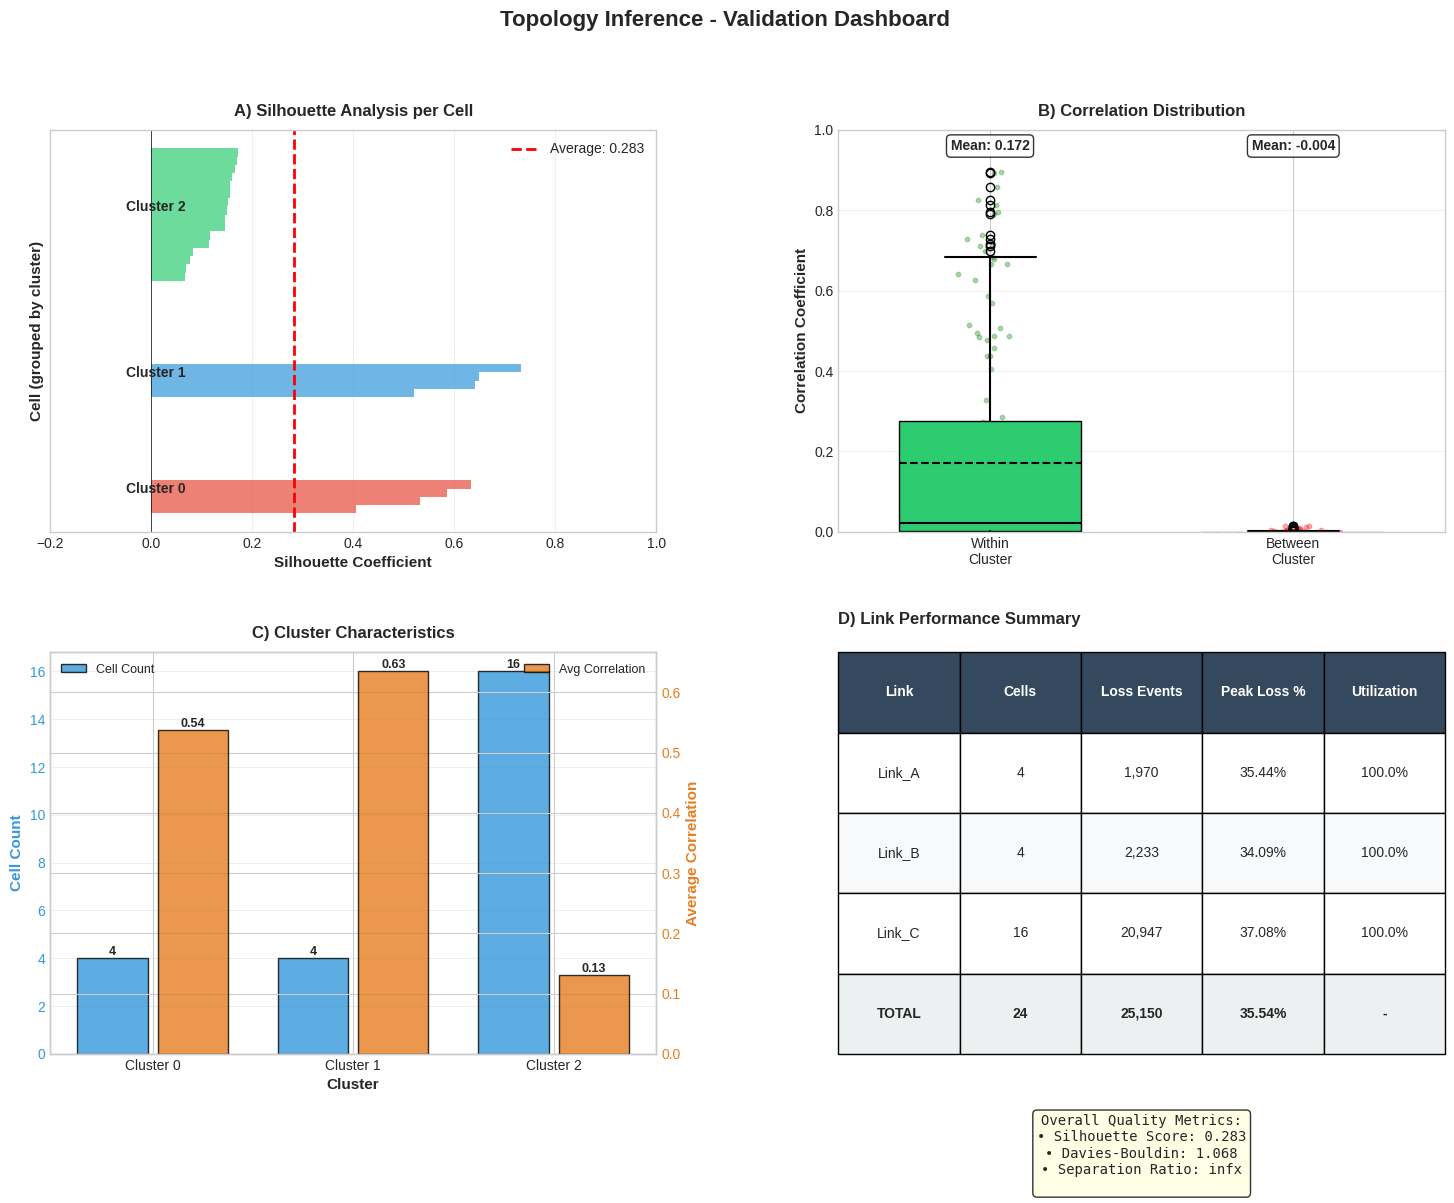

✅ Validation dashboard saved


In [26]:
def plot_validation_dashboard(corr_matrix: np.ndarray, labels: np.ndarray,
                              silhouette_samples_scores: np.ndarray,
                              quality_metrics: Dict, topology: Dict, output_dir: str):
    """Create comprehensive validation dashboard"""

    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

    n_clusters = len(np.unique(labels))
    cluster_colors = ['#e74c3c', '#3498db', '#2ecc71'][:n_clusters]

    # ========================================================================
    # PANEL A: Silhouette Plot
    # ========================================================================
    ax1 = fig.add_subplot(gs[0, 0])

    y_lower = 10

    for cluster_id in range(n_clusters):
        # Get silhouette scores for this cluster
        cluster_silhouette_values = silhouette_samples_scores[labels == cluster_id]
        cluster_silhouette_values.sort()

        cluster_size = len(cluster_silhouette_values)
        y_upper = y_lower + cluster_size

        color = cluster_colors[cluster_id]
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_values,
                height=1.0, edgecolor='none', color=color, alpha=0.7)

        # Label the cluster
        ax1.text(-0.05, y_lower + 0.5 * cluster_size, f'Cluster {cluster_id}',
                fontsize=10, weight='bold')

        y_lower = y_upper + 10

    # Add average silhouette score line
    avg_score = quality_metrics['silhouette_score']
    ax1.axvline(x=avg_score, color='red', linestyle='--', linewidth=2,
               label=f'Average: {avg_score:.3f}')
    ax1.axvline(x=0, color='black', linestyle='-', linewidth=0.5)

    ax1.set_xlabel('Silhouette Coefficient', fontsize=11, weight='bold')
    ax1.set_ylabel('Cell (grouped by cluster)', fontsize=11, weight='bold')
    ax1.set_title('A) Silhouette Analysis per Cell', fontsize=12, weight='bold', pad=10)
    ax1.set_xlim([-0.2, 1.0])
    ax1.set_yticks([])
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3, axis='x')

    # ========================================================================
    # PANEL B: Within vs Between Cluster Correlation
    # ========================================================================
    ax2 = fig.add_subplot(gs[0, 1])

    # Collect within and between cluster correlations
    within_corrs = []
    between_corrs = []

    for i in range(len(labels)):
        for j in range(i + 1, len(labels)):
            if labels[i] == labels[j]:
                within_corrs.append(corr_matrix[i, j])
            else:
                between_corrs.append(corr_matrix[i, j])

    # Create box plots
    bp = ax2.boxplot([within_corrs, between_corrs],
                     labels=['Within\nCluster', 'Between\nCluster'],
                     patch_artist=True, widths=0.6,
                     showmeans=True, meanline=True)

    # Color the boxes
    bp['boxes'][0].set_facecolor('#2ecc71')
    bp['boxes'][1].set_facecolor('#e74c3c')

    for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color='black', linewidth=1.5)

    # Add scatter points
    np.random.seed(42)
    x_within = np.random.normal(1, 0.04, len(within_corrs))
    x_between = np.random.normal(2, 0.04, len(between_corrs))

    ax2.scatter(x_within, within_corrs, alpha=0.3, s=10, color='green')
    ax2.scatter(x_between, between_corrs, alpha=0.3, s=10, color='red')

    # Add mean values as text
    ax2.text(1, 0.95, f'Mean: {np.mean(within_corrs):.3f}',
            transform=ax2.get_xaxis_transform(), ha='center',
            fontsize=10, weight='bold', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    ax2.text(2, 0.95, f'Mean: {np.mean(between_corrs):.3f}',
            transform=ax2.get_xaxis_transform(), ha='center',
            fontsize=10, weight='bold', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    ax2.set_ylabel('Correlation Coefficient', fontsize=11, weight='bold')
    ax2.set_title('B) Correlation Distribution', fontsize=12, weight='bold', pad=10)
    ax2.set_ylim([0, 1])
    ax2.grid(True, alpha=0.3, axis='y')

    # ========================================================================
    # PANEL C: Cluster Size and Quality
    # ========================================================================
    ax3 = fig.add_subplot(gs[1, 0])

    cluster_stats = quality_metrics.get('cluster_stats', {})

    cluster_ids = []
    cluster_sizes = []
    cluster_avg_corrs = []

    for cluster_id in range(n_clusters):
        stats = cluster_stats.get(cluster_id, {})
        cluster_ids.append(f'Cluster {cluster_id}')
        cluster_sizes.append(stats.get('size', 0))
        cluster_avg_corrs.append(stats.get('avg_correlation', 0))

    x_pos = np.arange(len(cluster_ids))

    # Create bars
    bars1 = ax3.bar(x_pos - 0.2, cluster_sizes, 0.35, label='Cell Count',
                   color='#3498db', alpha=0.8, edgecolor='black')

    ax3_twin = ax3.twinx()
    bars2 = ax3_twin.bar(x_pos + 0.2, cluster_avg_corrs, 0.35,
                        label='Avg Correlation', color='#e67e22',
                        alpha=0.8, edgecolor='black')

    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom', fontsize=9, weight='bold')

    for bar in bars2:
        height = bar.get_height()
        ax3_twin.text(bar.get_x() + bar.get_width()/2., height,
                     f'{height:.2f}', ha='center', va='bottom', fontsize=9, weight='bold')

    ax3.set_xlabel('Cluster', fontsize=11, weight='bold')
    ax3.set_ylabel('Cell Count', fontsize=11, weight='bold', color='#3498db')
    ax3_twin.set_ylabel('Average Correlation', fontsize=11, weight='bold', color='#e67e22')
    ax3.set_title('C) Cluster Characteristics', fontsize=12, weight='bold', pad=10)
    ax3.set_xticks(x_pos)
    ax3.set_xticklabels(cluster_ids)
    ax3.tick_params(axis='y', labelcolor='#3498db')
    ax3_twin.tick_params(axis='y', labelcolor='#e67e22')

    # Add legends
    ax3.legend(loc='upper left', fontsize=9)
    ax3_twin.legend(loc='upper right', fontsize=9)
    ax3.grid(True, alpha=0.3, axis='y') # Corrected: Removed `0=` from alpha

    # ========================================================================
    # PANEL D: Link Statistics Table
    # ========================================================================
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.axis('off')

    # Create table data
    table_data = []
    table_data.append(['Link', 'Cells', 'Loss Events', 'Peak Loss %', 'Utilization'])

    for link_name in sorted(topology.keys()):
        link = topology[link_name]
        table_data.append([
            link_name,
            f"{link['cell_count']}",
            f"{link.get('congestion_events', 0):,}",
            f"{link.get('peak_loss_rate', 0)*100:.2f}%",
            f"{link.get('estimated_utilization', 0):.1%}"
        ])

    # Add summary row
    total_cells = sum([link['cell_count'] for link in topology.values()])
    total_events = sum([link.get('congestion_events', 0) for link in topology.values()])
    avg_loss = np.mean([link.get('peak_loss_rate', 0) for link in topology.values()])

    table_data.append(['TOTAL', f'{total_cells}', f'{total_events:,}',
                      f'{avg_loss*100:.2f}%', '-'])

    # Create table
    table = ax4.table(cellText=table_data, cellLoc='center',
                     bbox=[0, 0, 1, 1])

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)

    # Style header row
    for i in range(5):
        cell = table[(0, i)]
        cell.set_facecolor('#34495e')
        cell.set_text_props(weight='bold', color='white')

    # Style data rows with alternating colors
    for i in range(1, len(table_data)):
        for j in range(5):
            cell = table[(i, j)]
            if i == len(table_data) - 1:  # Summary row
                cell.set_facecolor('#ecf0f1')
                cell.set_text_props(weight='bold')
            elif i % 2 == 0:
                cell.set_facecolor('#f8f9fa')
            else:
                cell.set_facecolor('white')

            # Color code by link
            if j == 0 and i < len(table_data) - 1:
                link_name = table_data[i][0]
                if link_name in cluster_colors:
                    idx = sorted(topology.keys()).index(link_name)
                    cell.set_facecolor(cluster_colors[idx])
                    cell.set_text_props(color='white', weight='bold')

    ax4.set_title('D) Link Performance Summary', fontsize=12, weight='bold',
                 pad=20, loc='left')

    # Add overall metrics text
    metrics_text = (
        f"Overall Quality Metrics:\n"
        f"• Silhouette Score: {quality_metrics['silhouette_score']:.3f}\n"
        f"• Davies-Bouldin: {quality_metrics['davies_bouldin_index']:.3f}\n"
        f"• Separation Ratio: {quality_metrics['separation_ratio']:.2f}x\n"
    )

    ax4.text(0.5, -0.15, metrics_text, transform=ax4.transAxes,
            fontsize=10, verticalalignment='top', ha='center',
            bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8),
            family='monospace')

    # ========================================================================
    # Overall title
    # ========================================================================
    fig.suptitle('Topology Inference - Validation Dashboard',
                fontsize=16, weight='bold', y=0.98)

    plt.savefig(f'{output_dir}/09_validation_dashboard.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("✅ Validation dashboard saved")

# Generate validation dashboard
plot_validation_dashboard(
    correlation_matrix,
    final_labels,
    final_clusterer.silhouette_samples,
    final_quality,
    topology,
    config.OUTPUT_DIR
)

In [27]:
def print_final_summary(topology: Dict, quality_metrics: Dict, cells_list: List[int]):
    """Print comprehensive final summary"""

    print("\n" + "="*80)
    print("FINAL TOPOLOGY INFERENCE SUMMARY")
    print("="*80)

    print("\n📊 TOPOLOGY MAPPING:")
    print("-"*80)

    for link_name in sorted(topology.keys()):
        link = topology[link_name]
        cells_str = ", ".join([f"{c}" for c in link['cells']])
        print(f"\n{link_name}:")
        print(f"  └─ Cells: [{cells_str}]")
        print(f"  └─ Count: {link['cell_count']} cells")
        print(f"  └─ Loss Events: {link.get('congestion_events', 0):,}")
        print(f"  └─ Peak Loss Rate: {link.get('peak_loss_rate', 0)*100:.2f}%")
        print(f"  └─ Peak Throughput: {link.get('peak_throughput_mbps', 0):.2f} Mbps")
        print(f"  └─ Utilization: {link.get('estimated_utilization', 0):.1%}")

    print("\n" + "-"*80)
    print("📈 QUALITY METRICS:")
    print("-"*80)

    metrics_display = [
        ("Silhouette Score", quality_metrics['silhouette_score'], "Higher is better (>0.7 excellent)"),
        ("Davies-Bouldin Index", quality_metrics['davies_bouldin_index'], "Lower is better (<1.0 good)"),
        ("Within-Cluster Correlation", quality_metrics['within_cluster_correlation'], "Higher is better"),
        ("Between-Cluster Correlation", quality_metrics['between_cluster_correlation'], "Lower is better"),
        ("Separation Ratio", quality_metrics['separation_ratio'], "Higher is better (>3.0 excellent)"),
    ]

    for name, value, interpretation in metrics_display:
        print(f"{name:<30} {value:>10.3f}  ({interpretation})")

    print("\n" + "-"*80)
    print("✅ CONFIDENCE ASSESSMENT:")
    print("-"*80)

    sil = quality_metrics['silhouette_score']
    sep = quality_metrics['separation_ratio']

    if sil > 0.7 and sep > 3.0:
        confidence = "VERY HIGH ⭐⭐⭐⭐⭐"
        recommendation = "Topology is highly reliable. Proceed with confidence."
    elif sil > 0.6 and sep > 2.5:
        confidence = "HIGH ⭐⭐⭐⭐"
        recommendation = "Topology is reliable. Safe to use for optimization."
    elif sil > 0.5 and sep > 2.0:
        confidence = "MODERATE ⭐⭐⭐"
        recommendation = "Topology is likely correct. Validate with network team."
    else:
        confidence = "LOW ⭐⭐"
        recommendation = "Results need validation. Consider collecting more data."

    print(f"Overall Confidence: {confidence}")
    print(f"Recommendation: {recommendation}")

    print("\n" + "="*80)
    print("📁 OUTPUT FILES GENERATED:")
    print("="*80)

    output_files = [
        "01_exploratory_analysis.png",
        "02_lag_distribution.png",
        "03_correlation_heatmap_initial.png",
        "04_dendrogram.png",
        "05_correlation_heatmap_clustered.png",
        "06_loss_timeline_all_cells.png",
        "07_synchronized_events.png",
        "08_network_topology_graph.png",
        "09_validation_dashboard.png",
        "correlation_matrix.csv",
        "topology.json",
        "topology_report.txt"
    ]

    for filename in output_files:
        filepath = Path(config.OUTPUT_DIR) / filename
        if filepath.exists():
            print(f"  ✓ {filename}")
        else:
            print(f"  ✗ {filename} (not found)")

    print("\n" + "="*80)
    print("🎯 NEXT STEPS (DAY 2):")
    print("="*80)
    print("  1. Implement real-time congestion detection using topology")
    print("  2. Design dynamic traffic routing algorithm")
    print("  3. Create predictive model for congestion forecasting")
    print("  4. Optimize cell power allocation per link")
    print("  5. Develop automated failover mechanism")

    print("\n" + "="*80)
    print("✅ ANALYSIS COMPLETE!")
    print("="*80)
    print()

# Print final summary
print_final_summary(topology, final_quality, cells_list)


FINAL TOPOLOGY INFERENCE SUMMARY

📊 TOPOLOGY MAPPING:
--------------------------------------------------------------------------------

Link_A:
  └─ Cells: [4, 5, 12, 20]
  └─ Count: 4 cells
  └─ Loss Events: 1,970
  └─ Peak Loss Rate: 35.44%
  └─ Peak Throughput: 3888.00 Mbps
  └─ Utilization: 100.0%

Link_B:
  └─ Cells: [1, 9, 17, 22]
  └─ Count: 4 cells
  └─ Loss Events: 2,233
  └─ Peak Loss Rate: 34.09%
  └─ Peak Throughput: 3888.00 Mbps
  └─ Utilization: 100.0%

Link_C:
  └─ Cells: [2, 3, 6, 7, 8, 10, 11, 13, 14, 15, 16, 18, 19, 21, 23, 24]
  └─ Count: 16 cells
  └─ Loss Events: 20,947
  └─ Peak Loss Rate: 37.08%
  └─ Peak Throughput: 3888.00 Mbps
  └─ Utilization: 100.0%

--------------------------------------------------------------------------------
📈 QUALITY METRICS:
--------------------------------------------------------------------------------
Silhouette Score                    0.283  (Higher is better (>0.7 excellent))
Davies-Bouldin Index                1.068  (Lower is

In [28]:
df_aligned.to_csv(f'{config.OUTPUT_DIR}/processed_data.csv', index=False)
print(f"💾 Processed data saved to {config.OUTPUT_DIR}/processed_data.csv")

# Save cluster labels
labels_df = pd.DataFrame({
    'cell_id': cells_list,
    'cluster_id': final_labels,
    'link_name': [f'Link_{chr(65+lbl)}' for lbl in final_labels]
})
labels_df.to_csv(f'{config.OUTPUT_DIR}/cluster_assignments.csv', index=False)
print(f"💾 Cluster assignments saved to {config.OUTPUT_DIR}/cluster_assignments.csv")

print("\n" + "="*80)
print("ALL OUTPUTS SAVED SUCCESSFULLY!")
print("="*80)
print(f"\nCheck the '{config.OUTPUT_DIR}' directory for all results.")
print("\n✅ Nokia Hackathon Day 1 - COMPLETE! 🎉")
print("="*80)


💾 Processed data saved to ./results/processed_data.csv
💾 Cluster assignments saved to ./results/cluster_assignments.csv

ALL OUTPUTS SAVED SUCCESSFULLY!

Check the './results' directory for all results.

✅ Nokia Hackathon Day 1 - COMPLETE! 🎉


In [30]:
import os

print("="*80)
print("VERIFICATION CHECKLIST")
print("="*80)

checks = {
    "Data loaded": df_raw is not None and len(df_raw) > 0,
    "Features engineered": 'loss_binary' in df_processed.columns,
    "Time alignment": 'slot_id_aligned' in df_aligned.columns,
    "Correlation computed": correlation_matrix is not None,
    "Clustering done": final_labels is not None,
    "Topology extracted": topology is not None,
    "Quality metrics": final_quality is not None,
}

for check, passed in checks.items():
    status = "✅" if passed else "❌"
    print(f"{status} {check}")

print("\n" + "="*80)
print("OUTPUT FILES:")
print("="*80)

expected_files = [
    "01_exploratory_analysis.png",
    "02_lag_distribution.png",
    "03_correlation_heatmap_initial.png",
    "04_dendrogram.png",
    "05_correlation_heatmap_clustered.png",
    "06_loss_timeline_all_cells.png",
    "08_network_topology_graph.png",
    "09_validation_dashboard.png",
    "correlation_matrix.csv",
    "topology.json",
    "topology_report.txt"
]

files_found = 0
for filename in expected_files:
    filepath = Path(config.OUTPUT_DIR) / filename
    if filepath.exists():
        size_kb = filepath.stat().st_size / 1024
        print(f"  ✅ {filename:<40} ({size_kb:.1f} KB)")
        files_found += 1
    else:
        print(f"  ❌ {filename:<40} (MISSING)")

print("\n" + "="*80)
print(f"Files generated: {files_found}/{len(expected_files)}")
print("="*80)

if all(checks.values()) and files_found == len(expected_files):
    print("\n🎉 SUCCESS! All checks passed!")
else:
    print("\n⚠️  Some checks failed. Review errors above.")

VERIFICATION CHECKLIST
✅ Data loaded
✅ Features engineered
✅ Time alignment
✅ Correlation computed
✅ Clustering done
✅ Topology extracted
✅ Quality metrics

OUTPUT FILES:
  ✅ 01_exploratory_analysis.png              (665.0 KB)
  ✅ 02_lag_distribution.png                  (182.9 KB)
  ✅ 03_correlation_heatmap_initial.png       (453.3 KB)
  ✅ 04_dendrogram.png                        (222.5 KB)
  ✅ 05_correlation_heatmap_clustered.png     (255.5 KB)
  ✅ 06_loss_timeline_all_cells.png           (631.5 KB)
  ✅ 08_network_topology_graph.png            (501.1 KB)
  ✅ 09_validation_dashboard.png              (487.6 KB)
  ✅ correlation_matrix.csv                   (11.8 KB)
  ✅ topology.json                            (2.2 KB)
  ✅ topology_report.txt                      (3.5 KB)

Files generated: 11/11

🎉 SUCCESS! All checks passed!


In [31]:
link_df = df_raw[df_raw["cell_id"].isin([4, 5, 12, 20])]

print("Overall peak throughput:", link_df["throughput_mbps"].max())
print("Peak throughput during loss events:",
      link_df.loc[link_df["loss_rate"] > 0, "throughput_mbps"].max())

Overall peak throughput: 3888.0000000311043
Peak throughput during loss events: 3888.0000000311043


In [7]:
def plot_eda(df: pd.DataFrame, output_dir: str, loss_threshold: float):
    """Generate exploratory data analysis plots"""

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # --------------------------------------------------
    # 1. Loss rate distribution (non-zero only)
    # --------------------------------------------------
    ax = axes[0, 0]
    loss_rates = df.loc[df["loss_rate"] > 0, "loss_rate"]

    if not loss_rates.empty:
        ax.hist(loss_rates, bins=100, alpha=0.7, edgecolor="black")
        ax.set_yscale("log")
        ax.set_xlabel("Loss Rate")
        ax.set_ylabel("Frequency (log scale)")
        ax.set_title("Distribution of Packet Loss Rates\n(Non-zero values)")
        ax.grid(True, alpha=0.3)

    # --------------------------------------------------
    # 2. Loss rate per cell (mean & max)
    # --------------------------------------------------
    ax = axes[0, 1]

    stats_df = (
        df.groupby("cell_id")
          .agg(
              mean_loss=("loss_rate", "mean"),
              max_loss=("loss_rate", "max"),
              loss_events=("loss_rate", lambda x: (x > loss_threshold).sum())
          )
          .reset_index()
    )

    x_pos = np.arange(len(stats_df))

    ax.bar(x_pos, stats_df["mean_loss"], alpha=0.7, label="Mean Loss Rate")
    ax.scatter(
        x_pos,
        stats_df["max_loss"],
        color="red",
        s=50,
        marker="D",
        label="Max Loss Rate",
        zorder=3
    )

    ax.set_xlabel("Cell ID")
    ax.set_ylabel("Loss Rate")
    ax.set_title("Loss Rate Statistics per Cell")
    ax.set_xticks(x_pos[::2])
    ax.set_xticklabels(stats_df["cell_id"].iloc[::2].astype(int), rotation=45)
    ax.legend()
    ax.grid(True, alpha=0.3, axis="y")

    # --------------------------------------------------
    # 3. Loss events per cell
    # --------------------------------------------------
    ax = axes[0, 2]
    ax.bar(x_pos, stats_df["loss_events"], alpha=0.7)
    ax.set_xlabel("Cell ID")
    ax.set_ylabel("Number of Loss Events")
    ax.set_title(f"Loss Events per Cell\n(Loss Rate > {loss_threshold*100:.1f}%)")
    ax.set_xticks(x_pos[::2])
    ax.set_xticklabels(stats_df["cell_id"].iloc[::2].astype(int), rotation=45)
    ax.grid(True, alpha=0.3, axis="y")

    # --------------------------------------------------
    # 4. Sample loss-rate time series (first 4 cells)
    # --------------------------------------------------
    ax = axes[1, 0]
    sample_cells = stats_df["cell_id"].iloc[:4]
    colors = plt.cm.Set2(np.linspace(0, 1, len(sample_cells)))

    for idx, cell_id in enumerate(sample_cells):
        cell_data = df[df["cell_id"] == cell_id].head(1000)
        ax.plot(
            cell_data["slot_id"],
            cell_data["loss_rate"],
            label=f"Cell {int(cell_id)}",
            linewidth=1,
            alpha=0.8,
            color=colors[idx]
        )

    ax.axhline(
        y=loss_threshold,
        color="red",
        linestyle="--",
        linewidth=1,
        alpha=0.6,
        label="Loss Threshold"
    )

    ax.set_xlabel("Slot ID")
    ax.set_ylabel("Loss Rate")
    ax.set_title("Sample Loss Rate Time Series\n(First 1000 Slots)")
    ax.legend()
    ax.grid(True, alpha=0.3)

    # --------------------------------------------------
    # 5. Throughput distribution (Gbps)
    # --------------------------------------------------
    ax = axes[1, 1]
    throughput_vals = df.loc[df["throughput_gbps"] > 0, "throughput_gbps"]

    if not throughput_vals.empty:
        ax.hist(throughput_vals, bins=50, alpha=0.7, edgecolor="black")
        ax.set_xlabel("Throughput (Gbps)")
        ax.set_ylabel("Frequency")
        ax.set_title("Distribution of Throughput")
        ax.grid(True, alpha=0.3)

    # --------------------------------------------------
    # 6. Throughput vs Loss Rate
    # --------------------------------------------------
    ax = axes[1, 2]
    sample_df = df.sample(min(5000, len(df)), random_state=42)

    scatter = ax.scatter(
        sample_df["throughput_gbps"],
        sample_df["loss_rate"],
        c=sample_df["loss_rate"],
        cmap="YlOrRd",
        s=10,
        alpha=0.3
    )

    ax.set_xlabel("Throughput (Gbps)")
    ax.set_ylabel("Loss Rate")
    ax.set_title("Throughput vs Loss Rate\n(Sample of 5000 points)")
    ax.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax, label="Loss Rate")

    # --------------------------------------------------
    # Save & show
    # --------------------------------------------------
    plt.tight_layout()
    plt.savefig(f"{output_dir}/01_exploratory_analysis.png", dpi=300, bbox_inches="tight")
    plt.show()

    print("✅ EDA plots generated")

    return stats_df


In [ ]:
cell_statistics = plot_eda(
    df_raw,
    config.OUTPUT_DIR,
    config.LOSS_THRESHOLD
)

In [10]:
class SignalPreprocessor:
    """Feature engineering and signal processing"""

    def __init__(self, config: Config):
        self.config = config

    def create_binary_loss_signal(self, df: pd.DataFrame) -> pd.DataFrame:
        """Create binary loss indicator with adaptive threshold"""
        print("\n🔢 Creating binary loss signal...")

        df = df.copy()

        # Calculate adaptive threshold per cell
        thresholds = {}
        for cell_id in df['cell_id'].unique():
            cell_data = df[df['cell_id'] == cell_id]['loss_rate']

            # Adaptive threshold: max of (mean + 2*std) or config threshold
            mean_loss = cell_data.mean()
            std_loss = cell_data.std()

            adaptive_threshold = max(
                mean_loss + 2 * std_loss,
                self.config.LOSS_THRESHOLD
            )

            thresholds[cell_id] = adaptive_threshold

        # Apply thresholds
        df['loss_threshold'] = df['cell_id'].map(thresholds)
        df['loss_binary'] = (df['loss_rate'] > df['loss_threshold']).astype(int)

        # Loss intensity (log scale for better distribution)
        df['loss_intensity'] = np.log10(1 + 1000 * df['loss_rate'])

        # Print statistics
        print(f"\n   Binary loss events per cell:")
        for cell_id in sorted(df['cell_id'].unique()):
            n_events = df[df['cell_id'] == cell_id]['loss_binary'].sum()
            threshold = thresholds[cell_id]
            print(f"      Cell {int(cell_id):2d}: {n_events:5d} events (threshold: {threshold*100:.2f}%)")

        return df

    def engineer_temporal_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """Add temporal context features"""
        print("\n⏰ Engineering temporal features...")

        df = df.sort_values(['cell_id', 'slot_id']).reset_index(drop=True)

        feature_dfs = []

        for cell_id in tqdm(sorted(df['cell_id'].unique()), desc="Processing cells"):
            cell_df = df[df['cell_id'] == cell_id].copy().reset_index(drop=True)

            # Lagged features
            cell_df['loss_lag1'] = cell_df['loss_binary'].shift(1).fillna(0)
            cell_df['loss_lag2'] = cell_df['loss_binary'].shift(2).fillna(0)
            cell_df['loss_lead1'] = cell_df['loss_binary'].shift(-1).fillna(0)
            cell_df['loss_lead2'] = cell_df['loss_binary'].shift(-2).fillna(0)

            # Rolling statistics (10-slot window)
            window_size = 10
            cell_df['loss_rolling_mean'] = cell_df['loss_rate'].rolling(
                window=window_size, center=True, min_periods=1
            ).mean()

            cell_df['loss_rolling_max'] = cell_df['loss_rate'].rolling(
                window=window_size, center=True, min_periods=1
            ).max()

            cell_df['loss_rolling_std'] = cell_df['loss_rate'].rolling(
                window=window_size, center=True, min_periods=1
            ).std().fillna(0)

            # Burst duration (consecutive loss slots)
            cell_df['burst_duration'] = 0
            current_burst = 0

            for idx in range(len(cell_df)):
                if cell_df.iloc[idx]['loss_binary'] == 1:
                    current_burst += 1
                    cell_df.iloc[idx, cell_df.columns.get_loc('burst_duration')] = current_burst
                else:
                    current_burst = 0

            feature_dfs.append(cell_df)

        df_featured = pd.concat(feature_dfs, ignore_index=True)

        new_features = [c for c in df_featured.columns if c not in df.columns]
        print(f"✅ Added {len(new_features)} new features: {new_features}")

        return df_featured

In [ ]:
preprocessor = SignalPreprocessor(config)

# Create binary loss signal
df_processed = preprocessor.create_binary_loss_signal(df_raw.copy())

# Engineer temporal features
df_processed = preprocessor.engineer_temporal_features(df_processed)

print(f"\n📊 Processed data shape: {df_processed.shape}")
print(f"📊 Columns: {df_processed.columns.tolist()}")

In [12]:
class TimeSeriesAligner:
    """Handles timing offsets between cells"""

    def __init__(self, config: Config):
        self.config = config
        self.lag_matrix = None

    def compute_cross_correlation(
        self,
        signal_a: np.ndarray,
        signal_b: np.ndarray,
        max_lag: int
    ) -> Tuple[int, float]:
        """Compute cross-correlation and find optimal lag"""

        # Normalize signals
        mean_a = np.mean(signal_a)
        std_a = np.std(signal_a)
        mean_b = np.mean(signal_b)
        std_b = np.std(signal_b)

        if std_a == 0 or std_b == 0:
            return 0, 0.0

        signal_a_norm = (signal_a - mean_a) / std_a
        signal_b_norm = (signal_b - mean_b) / std_b

        # Compute cross-correlation for each lag
        correlations = []
        lags = range(-max_lag, max_lag + 1)

        for lag in lags:
            if lag < 0:
                # Shift signal_b left
                overlap_a = signal_a_norm[:lag]
                overlap_b = signal_b_norm[-lag:]
            elif lag > 0:
                # Shift signal_b right
                overlap_a = signal_a_norm[lag:]
                overlap_b = signal_b_norm[:-lag]
            else:
                # No shift
                overlap_a = signal_a_norm
                overlap_b = signal_b_norm

            if len(overlap_a) > 0:
                corr = np.corrcoef(overlap_a, overlap_b)[0, 1]
                correlations.append(corr if not np.isnan(corr) else 0)
            else:
                correlations.append(0)

        # Find lag with maximum correlation
        max_corr_idx = np.argmax(correlations)
        optimal_lag = list(lags)[max_corr_idx]
        max_corr = correlations[max_corr_idx]

        return optimal_lag, max_corr

    def align_all_cells(self, df: pd.DataFrame) -> Tuple[pd.DataFrame, np.ndarray]:
        """Align all cells to reference (first cell)"""
        print("\n⏱️  Aligning time series across cells...")

        cells = sorted(df['cell_id'].unique())
        n_cells = len(cells)

        # Initialize lag matrix
        self.lag_matrix = np.zeros((n_cells, n_cells), dtype=int)

        # Pivot data to wide format
        print("   Creating loss signal matrix...")
        loss_pivot = df.pivot_table(
            index='slot_id',
            columns='cell_id',
            values='loss_binary',
            fill_value=0
        )

        # Ensure all cells are present
        for cell in cells:
            if cell not in loss_pivot.columns:
                loss_pivot[cell] = 0

        loss_pivot = loss_pivot[cells]  # Reorder columns

        # Compute pairwise lags
        print("   Computing optimal lags between cell pairs...")

        for i in tqdm(range(n_cells), desc="Cells"):
            for j in range(i + 1, n_cells):
                signal_i = loss_pivot.iloc[:, i].values
                signal_j = loss_pivot.iloc[:, j].values

                lag, corr = self.compute_cross_correlation(
                    signal_i, signal_j, self.config.MAX_ALIGNMENT_LAG
                )

                self.lag_matrix[i, j] = lag
                self.lag_matrix[j, i] = -lag

        # Use first cell as reference
        reference_idx = 0
        reference_cell = cells[reference_idx]

        lags_to_reference = self.lag_matrix[reference_idx, :]

        print(f"\n   Lags relative to Cell {int(reference_cell)} (reference):")
        for i, cell_id in enumerate(cells):
            lag = lags_to_reference[i]
            print(f"      Cell {int(cell_id):2d}: {lag:+3d} slots")

        # Apply alignment
        print("\n   Applying time alignment...")
        df_aligned = df.copy()

        for i, cell_id in enumerate(cells):
            lag = lags_to_reference[i]
            if lag != 0:
                mask = df_aligned['cell_id'] == cell_id
                df_aligned.loc[mask, 'slot_id_aligned'] = df_aligned.loc[mask, 'slot_id'] - lag
            else:
                mask = df_aligned['cell_id'] == cell_id
                df_aligned.loc[mask, 'slot_id_aligned'] = df_aligned.loc[mask, 'slot_id']

        print(f"✅ Alignment complete")

        return df_aligned, self.lag_matrix

    def plot_lag_distribution(self, cells: List[int], output_dir: str):
        """Plot distribution of optimal lags"""
        if self.lag_matrix is None:
            print("No lag matrix available")
            return

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

        # 1. Histogram of lags
        lags = []
        for i in range(len(cells)):
            for j in range(i+1, len(cells)):
                lags.append(self.lag_matrix[i, j])

        ax1.hist(lags, bins=range(-config.MAX_ALIGNMENT_LAG-1, config.MAX_ALIGNMENT_LAG+2),
                alpha=0.7, edgecolor='black', color='#3498db')
        ax1.set_xlabel('Optimal Lag (slots)')
        ax1.set_ylabel('Frequency')
        ax1.set_title('Distribution of Optimal Time Lags\nBetween Cell Pairs')
        ax1.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero lag')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # 2. Lag matrix heatmap
        im = ax2.imshow(self.lag_matrix, cmap='RdBu_r', aspect='auto',
                       vmin=-config.MAX_ALIGNMENT_LAG, vmax=config.MAX_ALIGNMENT_LAG)
        ax2.set_xticks(range(len(cells)))
        ax2.set_yticks(range(len(cells)))
        ax2.set_xticklabels([f'{int(c)}' for c in cells], fontsize=8)
        ax2.set_yticklabels([f'{int(c)}' for c in cells], fontsize=8)
        ax2.set_xlabel('Cell ID')
        ax2.set_ylabel('Cell ID')
        ax2.set_title('Pairwise Lag Matrix\n(slots)')

        cbar = plt.colorbar(im, ax=ax2)
        cbar.set_label('Lag (slots)', rotation=270, labelpad=15)

        plt.tight_layout()
        plt.savefig(f'{output_dir}/02_lag_distribution.png', dpi=300, bbox_inches='tight')
        plt.show()

        print(f"\n📊 Lag statistics:")
        print(f"   Mean absolute lag: {np.mean(np.abs(lags)):.2f} slots")
        print(f"   Max lag: {np.max(np.abs(lags))} slots")
        print(f"   Std dev of lags: {np.std(lags):.2f} slots")

In [ ]:
aligner = TimeSeriesAligner(config)
df_aligned, lag_matrix = aligner.align_all_cells(df_processed)

# Plot lag distribution
cells_list = sorted(df_aligned['cell_id'].unique())
aligner.plot_lag_distribution(cells_list, config.OUTPUT_DIR)

In [14]:
class CorrelationAnalyzer:
    """Multi-metric correlation computation"""

    def __init__(self, config: Config):
        self.config = config
        self.pearson_matrix = None
        self.spearman_matrix = None
        self.jaccard_matrix = None
        self.ensemble_matrix = None
        self.pvalues_matrix = None

    def create_loss_matrix(self, df: pd.DataFrame, use_aligned: bool = True) -> Tuple[pd.DataFrame, List[int]]:
        """Create cell x slot matrix of loss signals"""

        slot_col = 'slot_id_aligned' if use_aligned and 'slot_id_aligned' in df.columns else 'slot_id'

        # Pivot to wide format
        loss_matrix = df.pivot_table(
            index=slot_col,
            columns='cell_id',
            values='loss_binary',
            fill_value=0
        )

        cells = sorted(loss_matrix.columns.tolist())

        return loss_matrix, cells

    def compute_pearson(self, df: pd.DataFrame) -> np.ndarray:
        """Compute Pearson correlation matrix"""
        print("📊 Computing Pearson correlation...")

        slot_col = 'slot_id_aligned' if 'slot_id_aligned' in df.columns else 'slot_id'

        # Use loss_intensity for Pearson (continuous values)
        intensity_matrix = df.pivot_table(
            index=slot_col,
            columns='cell_id',
            values='loss_intensity',
            fill_value=0
        )

        # Compute correlation
        corr_matrix = intensity_matrix.corr(method='pearson').values

        # Handle NaN values
        corr_matrix = np.nan_to_num(corr_matrix, nan=0.0)

        return corr_matrix

    def compute_spearman(self, df: pd.DataFrame) -> np.ndarray:
        """Compute Spearman correlation matrix"""
        print("📊 Computing Spearman correlation...")

        slot_col = 'slot_id_aligned' if 'slot_id_aligned' in df.columns else 'slot_id'

        # Use loss_rate for Spearman
        rate_matrix = df.pivot_table(
            index=slot_col,
            columns='cell_id',
            values='loss_rate',
            fill_value=0
        )

        # Compute correlation
        corr_matrix = rate_matrix.corr(method='spearman').values

        # Handle NaN values
        corr_matrix = np.nan_to_num(corr_matrix, nan=0.0)

        return corr_matrix

    def compute_jaccard(self, df: pd.DataFrame) -> np.ndarray:
        """Compute Jaccard similarity matrix"""
        print("📊 Computing Jaccard similarity...")

        loss_matrix, cells = self.create_loss_matrix(df)
        loss_array = loss_matrix.values.T  # Transpose to cells x slots

        n_cells = len(cells)
        jaccard_matrix = np.zeros((n_cells, n_cells))

        for i in range(n_cells):
            for j in range(i, n_cells):
                # Get binary loss events
                loss_i = loss_array[i] > 0
                loss_j = loss_array[j] > 0

                # Compute Jaccard similarity
                intersection = np.sum(loss_i & loss_j)
                union = np.sum(loss_i | loss_j)

                if union > 0:
                    jaccard = intersection / union
                else:
                    jaccard = 0.0

                jaccard_matrix[i, j] = jaccard
                jaccard_matrix[j, i] = jaccard

        return jaccard_matrix

    def compute_ensemble(self) -> np.ndarray:
        """Compute weighted ensemble correlation"""
        print("📊 Computing ensemble correlation...")

        weights = self.config.CORRELATION_WEIGHTS

        ensemble = (
            weights['pearson'] * self.pearson_matrix +
            weights['spearman'] * self.spearman_matrix +
            weights['jaccard'] * self.jaccard_matrix
        )

        # Ensure diagonal is 1.0
        np.fill_diagonal(ensemble, 1.0)

        return ensemble

    def compute_significance(self, df: pd.DataFrame, corr_matrix: np.ndarray) -> np.ndarray:
        """Compute p-values for correlations"""
        print("📊 Computing statistical significance...")

        cells = sorted(df['cell_id'].unique())
        n_cells = len(cells)

        slot_col = 'slot_id_aligned' if 'slot_id_aligned' in df.columns else 'slot_id'
        n_samples = df[slot_col].nunique()

        pvalues = np.ones((n_cells, n_cells))

        for i in range(n_cells):
            for j in range(i+1, n_cells):
                r = corr_matrix[i, j]

                # Avoid division by zero
                if abs(r) >= 0.9999:
                    pvalues[i, j] = 0.0
                    pvalues[j, i] = 0.0
                    continue

                # t-statistic for correlation
                t_stat = r * np.sqrt((n_samples - 2) / (1 - r**2 + 1e-10))

                # Two-tailed p-value
                p_value = 2 * (1 - stats.t.cdf(abs(t_stat), n_samples - 2))

                pvalues[i, j] = p_value
                pvalues[j, i] = p_value

        # Bonferroni correction
        n_tests = n_cells * (n_cells - 1) / 2
        bonferroni_threshold = 0.01 / n_tests

        n_significant = np.sum(pvalues < bonferroni_threshold)

        print(f"   Bonferroni threshold: {bonferroni_threshold:.2e}")
        print(f"   Significant correlations: {n_significant} out of {int(n_tests)}")

        return pvalues

    def analyze_all(self, df: pd.DataFrame) -> np.ndarray:
        """Compute all correlation metrics"""
        print("\n🔬 Performing comprehensive correlation analysis...")

        self.pearson_matrix = self.compute_pearson(df)
        self.spearman_matrix = self.compute_spearman(df)
        self.jaccard_matrix = self.compute_jaccard(df)
        self.ensemble_matrix = self.compute_ensemble()
        self.pvalues_matrix = self.compute_significance(df, self.ensemble_matrix)

        print("\n✅ Correlation analysis complete")
        print(f"\n   Metric Statistics:")
        print(f"   {'Metric':<15} {'Min':<10} {'Max':<10} {'Mean':<10} {'Std':<10}")
        print(f"   {'-'*55}")

        for name, matrix in [('Pearson', self.pearson_matrix),
                            ('Spearman', self.spearman_matrix),
                            ('Jaccard', self.jaccard_matrix),
                            ('Ensemble', self.ensemble_matrix)]:
            # Exclude diagonal for stats
            off_diag = matrix[~np.eye(matrix.shape[0], dtype=bool)]
            print(f"   {name:<15} {off_diag.min():<10.3f} {off_diag.max():<10.3f} "
                  f"{off_diag.mean():<10.3f} {off_diag.std():<10.3f}")

        return self.ensemble_matrix


In [ ]:
correlator = CorrelationAnalyzer(config)
correlation_matrix = correlator.analyze_all(df_aligned)

# Save correlation matrix
corr_df = pd.DataFrame(
    correlation_matrix,
    index=[int(c) for c in cells_list],
    columns=[int(c) for c in cells_list]
)
corr_df.to_csv(f'{config.OUTPUT_DIR}/correlation_matrix.csv')
print(f"\n💾 Correlation matrix saved to {config.OUTPUT_DIR}/correlation_matrix.csv")

In [ ]:
def plot_correlation_heatmap_initial(corr_matrix: np.ndarray, cells: List[int], output_dir: str):
    """Plot correlation heatmap without clustering reorder"""

    fig, ax = plt.subplots(figsize=(14, 12))

    # Create heatmap
    im = ax.imshow(corr_matrix, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)

    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Correlation Coefficient', rotation=270, labelpad=20, fontsize=12)

    # Set ticks
    n_cells = len(cells)
    tick_positions = np.arange(n_cells)
    ax.set_xticks(tick_positions)
    ax.set_yticks(tick_positions)
    ax.set_xticklabels([f'{int(c)}' for c in cells], fontsize=8)
    ax.set_yticklabels([f'{int(c)}' for c in cells], fontsize=8)

    # Rotate x labels
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Add minor grid
    ax.set_xticks(tick_positions - 0.5, minor=True)
    ax.set_yticks(tick_positions - 0.5, minor=True)
    ax.grid(which="minor", color="gray", linestyle='-', linewidth=0.5, alpha=0.3)

    # Annotate cells with values (only non-diagonal)
    for i in range(n_cells):
        for j in range(n_cells):
            if i != j:
                val = corr_matrix[i, j]
                color = "black" if 0.3 < val < 0.7 else "white"
                ax.text(j, i, f'{val:.2f}', ha="center", va="center",
                       color=color, fontsize=5, weight='bold')

    ax.set_title('Cell-to-Cell Packet Loss Correlation Matrix\n(Before Clustering Reorder)',
                fontsize=14, pad=20, weight='bold')
    ax.set_xlabel('Cell ID', fontsize=12)
    ax.set_ylabel('Cell ID', fontsize=12)

    plt.tight_layout()
    plt.savefig(f'{output_dir}/03_correlation_heatmap_initial.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("✅ Initial correlation heatmap saved")

plot_correlation_heatmap_initial(correlation_matrix, cells_list, config.OUTPUT_DIR)


In [17]:
class TopologyClusterer:
    """Clustering algorithms for link identification"""

    def __init__(self, config: Config):
        self.config = config
        self.linkage_matrix = None
        self.cluster_labels = None
        self.silhouette_score = None
        self.silhouette_samples = None

    def hierarchical_clustering(
        self,
        corr_matrix: np.ndarray,
        n_clusters: int = 3
    ) -> Tuple[np.ndarray, object]:
        """Perform hierarchical clustering"""
        print(f"\n🌳 Performing hierarchical clustering...")
        print(f"   Method: {self.config.LINKAGE_TYPE}")
        print(f"   Target clusters: {n_clusters}")

        # Convert correlation to distance
        distance_matrix = 1 - corr_matrix

        # Ensure valid distance matrix
        distance_matrix = np.clip(distance_matrix, 0, 2)
        np.fill_diagonal(distance_matrix, 0)

        # Make symmetric
        distance_matrix = (distance_matrix + distance_matrix.T) / 2

        # Convert to condensed form
        condensed_dist = squareform(distance_matrix, checks=False)

        # Perform hierarchical clustering
        linkage_matrix = linkage(condensed_dist, method=self.config.LINKAGE_TYPE)

        # Cut tree to get clusters
        cluster_labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust')

        # Convert to 0-indexed
        cluster_labels = cluster_labels - 1

        self.linkage_matrix = linkage_matrix
        self.cluster_labels = cluster_labels

        print(f"✅ Clustering complete")
        print(f"\n   Cluster distribution:")
        for cluster_id in range(n_clusters):
            count = np.sum(cluster_labels == cluster_id)
            print(f"      Cluster {cluster_id}: {count} cells")

        return cluster_labels, linkage_matrix

    def spectral_clustering(
        self,
        corr_matrix: np.ndarray,
        n_clusters: int = 3
    ) -> np.ndarray:
        """Perform spectral clustering"""
        print(f"\n🔮 Performing spectral clustering...")

        # Use correlation as affinity matrix
        affinity_matrix = np.clip(corr_matrix, 0, 1)

        # Spectral clustering
        clusterer = SpectralClustering(
            n_clusters=n_clusters,
            affinity='precomputed',
            random_state=self.config.RANDOM_SEED,
            assign_labels='kmeans'
        )

        cluster_labels = clusterer.fit_predict(affinity_matrix)

        print(f"✅ Clustering complete")
        print(f"\n   Cluster distribution:")
        for cluster_id in range(n_clusters):
            count = np.sum(cluster_labels == cluster_id)
            print(f"      Cluster {cluster_id}: {count} cells")

        return cluster_labels

    def compute_silhouette(self, corr_matrix: np.ndarray, labels: np.ndarray) -> float:
        """Compute silhouette score"""
        # Convert correlation to distance
        distance_matrix = 1 - corr_matrix
        distance_matrix = np.clip(distance_matrix, 0, 2)

        # Compute silhouette score
        score = silhouette_score(distance_matrix, labels, metric='precomputed')
        self.silhouette_score = score

        # Compute per-sample silhouette scores
        self.silhouette_samples = silhouette_samples(distance_matrix, labels, metric='precomputed')

        return score

    def compute_cluster_quality(self, corr_matrix: np.ndarray, labels: np.ndarray) -> Dict:
        """Compute all quality metrics"""
        print("\n📊 Computing cluster quality metrics...")

        n_clusters = len(np.unique(labels))

        # Silhouette score
        silhouette = self.compute_silhouette(corr_matrix, labels)

        # Within-cluster and between-cluster correlation
        within_corrs = []
        between_corrs = []

        for i in range(len(labels)):
            for j in range(i+1, len(labels)):
                if labels[i] == labels[j]:
                    within_corrs.append(corr_matrix[i, j])
                else:
                    between_corrs.append(corr_matrix[i, j])

        within_mean = np.mean(within_corrs) if within_corrs else 0
        within_std = np.std(within_corrs) if within_corrs else 0
        between_mean = np.mean(between_corrs) if between_corrs else 0
        between_std = np.std(between_corrs) if between_corrs else 0

        # Davies-Bouldin index
        distance_matrix = 1 - corr_matrix
        try:
            db_score = davies_bouldin_score(distance_matrix, labels)
        except:
            db_score = float('inf')

        # Per-cluster statistics
        cluster_stats = {}
        for cluster_id in range(n_clusters):
            mask = labels == cluster_id
            cluster_indices = np.where(mask)[0]

            if len(cluster_indices) > 1:
                cluster_corrs = []
                for i in cluster_indices:
                    for j in cluster_indices:
                        if i < j:
                            cluster_corrs.append(corr_matrix[i, j])

                cluster_stats[cluster_id] = {
                    'size': len(cluster_indices),
                    'avg_correlation': np.mean(cluster_corrs) if cluster_corrs else 0,
                    'min_correlation': np.min(cluster_corrs) if cluster_corrs else 0,
                    'max_correlation': np.max(cluster_corrs) if cluster_corrs else 0,
                    'std_correlation': np.std(cluster_corrs) if cluster_corrs else 0,
                }
            else:
                cluster_stats[cluster_id] = {
                    'size': len(cluster_indices),
                    'avg_correlation': 0,
                    'min_correlation': 0,
                    'max_correlation': 0,
                    'std_correlation': 0,
                }

        metrics = {
            'silhouette_score': silhouette,
            'davies_bouldin_index': db_score,
            'within_cluster_correlation': within_mean,
            'within_cluster_std': within_std,
            'between_cluster_correlation': between_mean,
            'between_cluster_std': between_std,
            'separation_ratio': within_mean / between_mean if between_mean > 0 else float('inf'),
            'cluster_stats': cluster_stats
        }

        # Print results
        print(f"\n   Quality Metrics:")
        print(f"   {'Metric':<35} {'Value':<15}")
        print(f"   {'-'*50}")
        print(f"   {'Silhouette Score':<35} {silhouette:<15.3f}")
        print(f"   {'Davies-Bouldin Index':<35} {db_score:<15.3f}")
        print(f"   {'Within-Cluster Correlation':<35} {within_mean:<15.3f}")
        print(f"   {'Between-Cluster Correlation':<35} {between_mean:<15.3f}")
        print(f"   {'Separation Ratio':<35} {metrics["separation_ratio"]:<15.2f}")

        print(f"\n   Per-Cluster Statistics:")
        print(f"   {'Cluster':<10} {'Size':<10} {'Avg Corr':<15} {'Min Corr':<15} {'Max Corr':<15}")
        print(f"   {'-'*65}")
        for cid, stats in cluster_stats.items():
            print(f"   {cid:<10} {stats['size']:<10} {stats['avg_correlation']:<15.3f} "
                  f"{stats['min_correlation']:<15.3f} {stats['max_correlation']:<15.3f}")

        return metrics

In [ ]:
clusterer = TopologyClusterer(config)

# Try hierarchical clustering
labels_hier, linkage_matrix = clusterer.hierarchical_clustering(
    correlation_matrix,
    n_clusters=config.N_EXPECTED_LINKS
)

# Try spectral clustering
labels_spectral = clusterer.spectral_clustering(
    correlation_matrix,
    n_clusters=config.N_EXPECTED_LINKS
)

# Compare methods
print("\n" + "="*80)
print("COMPARING CLUSTERING METHODS")
print("="*80)

quality_hier = clusterer.compute_cluster_quality(correlation_matrix, labels_hier)

print("\n" + "-"*80)

clusterer_spectral = TopologyClusterer(config)
quality_spectral = clusterer_spectral.compute_cluster_quality(correlation_matrix, labels_spectral)

print("\n" + "="*80)
print("METHOD COMPARISON SUMMARY")
print("="*80)
print(f"Hierarchical Silhouette Score: {quality_hier['silhouette_score']:.3f}")
print(f"Spectral Silhouette Score:     {quality_spectral['silhouette_score']:.3f}")

# Choose best method
if quality_hier['silhouette_score'] >= quality_spectral['silhouette_score']:
    print("\n✅ SELECTED METHOD: Hierarchical Clustering")
    final_labels = labels_hier
    final_quality = quality_hier
    final_clusterer = clusterer
else:
    print("\n✅ SELECTED METHOD: Spectral Clustering")
    final_labels = labels_spectral
    final_quality = quality_spectral
    final_clusterer = clusterer_spectral

print("="*80)

In [ ]:
# ============================================================================
# CELL 12: Dendrogram Visualization (CORRECTED)
# ============================================================================

def plot_dendrogram(linkage_matrix: np.ndarray, cells: List[int], labels: np.ndarray, output_dir: str):
    """Plot hierarchical clustering dendrogram with proper ordering"""

    fig, ax = plt.subplots(figsize=(20, 10))

    # Get number of clusters
    n_clusters = len(np.unique(labels))

    # Calculate color threshold to get desired number of clusters
    # The threshold should be between the (n_clusters-1)th and (n_clusters)th merge
    if linkage_matrix.shape[0] >= n_clusters - 1:
        # Get the merge distance for creating n_clusters
        cut_height = linkage_matrix[-(n_clusters-1), 2]
        color_threshold = cut_height + 0.001  # Slightly above cut height
    else:
        color_threshold = None

    # Create dendrogram with proper color threshold
    dendro = dendrogram(
        linkage_matrix,
        labels=[f'{int(c)}' for c in cells],
        ax=ax,
        color_threshold=color_threshold,
        above_threshold_color='#808080',
        leaf_font_size=10
    )

    # Get the order of leaves as they appear in the dendrogram
    leaf_order = dendro['leaves']

    # Create a mapping from dendrogram position to cluster color
    n_clusters = len(np.unique(labels))
    cluster_colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6', '#1abc9c'][:n_clusters]

    # Color the leaf labels by their actual cluster assignment
    xlbls = ax.get_xmajorticklabels()
    for i, lbl in enumerate(xlbls):
        try:
            cell_id = int(lbl.get_text())
            cell_idx = cells.index(cell_id)
            cluster_id = labels[cell_idx]
            lbl.set_color(cluster_colors[cluster_id])
            lbl.set_weight('bold')
            lbl.set_fontsize(9)
        except (ValueError, IndexError):
            pass

    # Rotate labels for better readability
    plt.setp(ax.get_xticklabels(), rotation=0, ha='center')

    ax.set_xlabel('Cell ID', fontsize=14, weight='bold', labelpad=10)
    ax.set_ylabel('Distance (1 - Correlation)', fontsize=14, weight='bold', labelpad=10)
    ax.set_title('Hierarchical Clustering Dendrogram\n(Leaf labels colored by cluster assignment)',
                fontsize=16, pad=20, weight='bold')
    ax.grid(True, axis='y', alpha=0.3, linestyle='--')

    # Add cut line
    if linkage_matrix.shape[0] >= n_clusters - 1:
        cut_height = linkage_matrix[-(n_clusters-1), 2]
        ax.axhline(y=cut_height, color='red', linestyle='--', linewidth=2.5,
                  label=f'Cut threshold = {cut_height:.3f}', alpha=0.8, zorder=10)

    # Add legend for clusters
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=cluster_colors[i], label=f'Cluster {i}')
                      for i in range(n_clusters)]
    legend_elements.append(plt.Line2D([0], [0], color='red', linewidth=2.5,
                                     linestyle='--', label='Cut Threshold'))

    ax.legend(handles=legend_elements, fontsize=11, loc='upper right',
             framealpha=0.9, edgecolor='black')

    # Set y-axis limits with some padding
    ymin, ymax = ax.get_ylim()
    ax.set_ylim(0, ymax * 1.1)

    plt.tight_layout()
    plt.savefig(f'{output_dir}/04_dendrogram.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("✅ Dendrogram saved")

    # Print cluster composition in dendrogram order
    print("\n📊 Cluster composition (in dendrogram order):")
    for cluster_id in range(n_clusters):
        cluster_cells = [int(cells[i]) for i, lbl in enumerate(labels) if lbl == cluster_id]
        print(f"   Cluster {cluster_id}: {cluster_cells}")

# Plot dendrogram
if linkage_matrix is not None:
    plot_dendrogram(linkage_matrix, cells_list, final_labels, config.OUTPUT_DIR)
else:
    print("⚠️  No linkage matrix available - skipping dendrogram")


# ============================================================================
# ALTERNATIVE: Side-by-side Dendrogram with Heatmap
# ============================================================================

def plot_dendrogram_with_heatmap(linkage_matrix: np.ndarray, corr_matrix: np.ndarray,
                                  cells: List[int], labels: np.ndarray, output_dir: str):
    """Plot dendrogram alongside correlation heatmap"""

    from scipy.cluster.hierarchy import dendrogram, leaves_list

    fig = plt.figure(figsize=(20, 10))

    # Create grid
    gs = fig.add_gridspec(1, 2, width_ratios=[2, 1], wspace=0.3)

    # LEFT: Dendrogram
    ax_dendro = fig.add_subplot(gs[0, 0])

    n_clusters = len(np.unique(labels))

    if linkage_matrix.shape[0] >= n_clusters - 1:
        cut_height = linkage_matrix[-(n_clusters-1), 2]
        color_threshold = cut_height + 0.001
    else:
        color_threshold = None

    dendro = dendrogram(
        linkage_matrix,
        labels=[f'{int(c)}' for c in cells],
        ax=ax_dendro,
        color_threshold=color_threshold,
        above_threshold_color='#808080',
        leaf_font_size=9,
        orientation='right'  # Horizontal dendrogram
    )

    # Color labels
    cluster_colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6'][:n_clusters]
    ylbls = ax_dendro.get_ymajorticklabels()

    for lbl in ylbls:
        try:
            cell_id = int(lbl.get_text())
            cell_idx = cells.index(cell_id)
            cluster_id = labels[cell_idx]
            lbl.set_color(cluster_colors[cluster_id])
            lbl.set_weight('bold')
        except (ValueError, IndexError):
            pass

    ax_dendro.set_xlabel('Distance (1 - Correlation)', fontsize=12, weight='bold')
    ax_dendro.set_ylabel('Cell ID', fontsize=12, weight='bold')
    ax_dendro.set_title('Hierarchical Clustering Dendrogram', fontsize=14, weight='bold', pad=15)
    ax_dendro.grid(True, axis='x', alpha=0.3)

    if linkage_matrix.shape[0] >= n_clusters - 1:
        ax_dendro.axvline(x=cut_height, color='red', linestyle='--', linewidth=2.5,
                         label=f'Cut = {cut_height:.3f}', alpha=0.8)
        ax_dendro.legend(fontsize=10)

    # RIGHT: Reordered correlation matrix
    ax_heatmap = fig.add_subplot(gs[0, 1])

    # Get dendrogram leaf order
    leaf_order = dendro['leaves']

    # Reorder correlation matrix
    corr_reordered = corr_matrix[leaf_order, :][:, leaf_order]
    cells_reordered = [cells[i] for i in leaf_order]

    # Plot heatmap
    im = ax_heatmap.imshow(corr_reordered, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)

    n_cells = len(cells_reordered)
    tick_positions = np.arange(n_cells)

    ax_heatmap.set_xticks(tick_positions[::2])
    ax_heatmap.set_yticks(tick_positions)
    ax_heatmap.set_xticklabels([f'{int(cells_reordered[i])}' for i in range(0, n_cells, 2)],
                               fontsize=8, rotation=45)
    ax_heatmap.set_yticklabels([f'{int(c)}' for c in cells_reordered], fontsize=8)

    ax_heatmap.set_title('Correlation Matrix\n(Reordered)', fontsize=14, weight='bold', pad=15)

    # Colorbar
    cbar = plt.colorbar(im, ax=ax_heatmap, fraction=0.046, pad=0.04)
    cbar.set_label('Correlation', rotation=270, labelpad=15, fontsize=11)

    plt.suptitle('Topology Clustering Analysis', fontsize=16, weight='bold', y=0.98)

    plt.savefig(f'{output_dir}/05_correlation_heatmap_clustered.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("✅ Combined dendrogram and heatmap saved")

# Plot combined visualization
if linkage_matrix is not None:
    plot_dendrogram_with_heatmap(linkage_matrix, correlation_matrix,
                                  cells_list, final_labels, config.OUTPUT_DIR)

In [21]:
class TopologyExtractor:
    """Convert clusters to network topology"""

    def __init__(self, config: Config):
        self.config = config
        self.topology = None

    def assign_link_ids(self, cluster_labels: np.ndarray, cells: List[int]) -> Dict:
        """Map cluster numbers to Link IDs"""
        print("\n🗺️  Extracting network topology...")

        # Group cells by cluster
        clusters = {}
        for cluster_id in range(config.N_EXPECTED_LINKS):
            mask = cluster_labels == cluster_id
            cluster_cells = [int(cells[i]) for i, m in enumerate(mask) if m]
            clusters[cluster_id] = sorted(cluster_cells)

        # Assign link names
        link_names = ['Link_A', 'Link_B', 'Link_C']

        topology = {}
        for cluster_id, link_name in enumerate(link_names[:len(clusters)]):
            topology[link_name] = {
                'cells': clusters.get(cluster_id, []),
                'cell_count': len(clusters.get(cluster_id, []))
            }

        # Print topology
        print("\n   Inferred Topology:")
        for link_name in sorted(topology.keys()):
            cells_str = ", ".join([f"{c}" for c in topology[link_name]['cells']])
            print(f"   {link_name}: [{cells_str}]")

        return topology

    def compute_link_statistics(self, df: pd.DataFrame, topology: Dict) -> Dict:
        """Compute per-link statistics"""
        print("\n📊 Computing link statistics...")

        for link_name, link_data in topology.items():
            cell_list = link_data['cells']

            if len(cell_list) == 0:
                continue

            # Filter data for this link
            link_df = df[df['cell_id'].isin(cell_list)]

            # Compute statistics
            total_packets_lost = link_df['packets_lost'].sum() if 'packets_lost' in link_df.columns else 0

            stats = {
                'total_packets_lost': int(total_packets_lost),
                'avg_loss_rate': float(link_df['loss_rate'].mean()),
                'peak_loss_rate': float(link_df['loss_rate'].max()),
                'congestion_events': int(link_df.groupby('cell_id')['loss_binary'].sum().sum()),
                'avg_throughput_gbps': float(link_df['throughput_gbps'].mean()),
                'peak_throughput_gbps': float(link_df['throughput_gbps'].max()),
                'avg_throughput_mbps': float(link_df['throughput_mbps'].mean()),
                'peak_throughput_mbps': float(link_df['throughput_mbps'].max()),
            }

            link_data.update(stats)

        # Estimate utilization (normalized)
        max_throughput_value = max([link.get('peak_throughput_mbps', 0) for link in topology.values()] + [1])

        for link_name, link_data in topology.items():
            if max_throughput_value > 0:
                link_data['estimated_utilization'] = link_data.get('peak_throughput_mbps', 0) / max_throughput_value
            else:
                link_data['estimated_utilization'] = 0.0

        return topology

    def generate_text_report(self, topology: Dict, quality_metrics: Dict) -> str:
        """Generate human-readable report"""

        report = []
        report.append("=" * 80)
        report.append("FRONTHAUL NETWORK TOPOLOGY INFERENCE REPORT")
        report.append("=" * 80)
        report.append("")
        report.append(f"Analysis Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}")
        report.append(f"Number of Cells Analyzed: {sum([len(link['cells']) for link in topology.values()])}")
        report.append(f"Number of Links Identified: {len(topology)}")
        report.append("")

        report.append("METHODOLOGY")
        report.append("-" * 80)
        report.append("1. Data Loading:")
        report.append("   - Loaded throughput and packet statistics for all cells")
        report.append("   - Processed symbol-level throughput data")
        report.append("   - Calculated packet loss from RU-side statistics")
        report.append("")
        report.append("2. Signal Processing:")
        report.append("   - Created binary loss indicators with adaptive thresholds")
        report.append("   - Engineered temporal features (lags, rolling statistics)")
        report.append("   - Applied time-series alignment using cross-correlation")
        report.append("")
        report.append("3. Correlation Analysis:")
        report.append("   - Computed Pearson correlation (linear relationships)")
        report.append("   - Computed Spearman correlation (rank-based, robust)")
        report.append("   - Computed Jaccard similarity (event overlap)")
        report.append("   - Created ensemble metric with weighted combination")
        report.append("")
        report.append("4. Topology Clustering:")
        report.append("   - Applied hierarchical agglomerative clustering")
        report.append(f"   - Linkage method: {config.LINKAGE_TYPE}")
        report.append(f"   - Distance metric: 1 - correlation")
        report.append("")
        report.append("5. Validation:")
        report.append("   - Statistical significance testing with Bonferroni correction")
        report.append("   - Silhouette analysis for cluster quality")
        report.append("   - Within vs between cluster correlation comparison")
        report.append("")

        report.append("INFERRED TOPOLOGY")
        report.append("-" * 80)

        for link_name in sorted(topology.keys()):
            link = topology[link_name]
            report.append(f"\n{link_name}:")
            report.append(f"  Cells: {link['cells']}")
            report.append(f"  Cell Count: {link['cell_count']}")
            report.append(f"  Total Packets Lost: {link.get('total_packets_lost', 0):,}")
            report.append(f"  Average Loss Rate: {link.get('avg_loss_rate', 0):.4f} ({link.get('avg_loss_rate', 0)*100:.2f}%)")
            report.append(f"  Peak Loss Rate: {link.get('peak_loss_rate', 0):.4f} ({link.get('peak_loss_rate', 0)*100:.2f}%)")
            report.append(f"  Congestion Events Detected: {link.get('congestion_events', 0):,}")
            report.append(f"  Average Throughput: {link.get('avg_throughput_mbps', 0):.2f} mbps")
            report.append(f"  Peak Throughput: {link.get('peak_throughput_mbps', 0):.2f} mbps")
            report.append(f"  Estimated Utilization: {link.get('estimated_utilization', 0):.2%}")

        report.append("")
        report.append("VALIDATION METRICS")
        report.append("-" * 80)
        report.append(f"Silhouette Score: {quality_metrics['silhouette_score']:.3f}")
        report.append(f"  Interpretation: {self._interpret_silhouette(quality_metrics['silhouette_score'])}")
        report.append("")
        report.append(f"Davies-Bouldin Index: {quality_metrics['davies_bouldin_index']:.3f}")
        report.append(f"  Interpretation: {self._interpret_db_index(quality_metrics['davies_bouldin_index'])}")
        report.append("")
        report.append(f"Within-Cluster Correlation: {quality_metrics['within_cluster_correlation']:.3f} ± {quality_metrics.get('within_cluster_std', 0):.3f}")
        report.append(f"Between-Cluster Correlation: {quality_metrics['between_cluster_correlation']:.3f} ± {quality_metrics.get('between_cluster_std', 0):.3f}")
        report.append(f"Separation Ratio: {quality_metrics['separation_ratio']:.2f}x")
        report.append("")

        report.append("Per-Cluster Quality:")
        for cluster_id, stats in quality_metrics.get('cluster_stats', {}).items():
            report.append(f"  Cluster {cluster_id}: size={stats['size']}, avg_corr={stats['avg_correlation']:.3f}")
        report.append("")

        report.append("CONFIDENCE ASSESSMENT")
        report.append("-" * 80)
        confidence, explanation = self._assess_confidence(quality_metrics)
        report.append(f"Overall Confidence: {confidence}")
        report.append(f"Rationale: {explanation}")
        report.append("")

        report.append("RECOMMENDATIONS")
        report.append("-" * 80)

        # Find most congested link
        links_by_util = sorted(topology.items(),
                              key=lambda x: x[1].get('estimated_utilization', 0),
                              reverse=True)

        if links_by_util:
            max_util_link = links_by_util[0]
            report.append(f"1. PRIORITY: Monitor {max_util_link[0]} - highest utilization "
                         f"({max_util_link[1].get('estimated_utilization', 0):.1%})")

        # Find link with most loss
        links_by_loss = sorted(topology.items(),
                              key=lambda x: x[1].get('peak_loss_rate', 0),
                              reverse=True)

        if links_by_loss:
            max_loss_link = links_by_loss[0]
            report.append(f"2. CAPACITY: Consider upgrade for {max_loss_link[0]} - "
                         f"peak loss rate {max_loss_link[1].get('peak_loss_rate', 0):.2%}")

        report.append("3. OPTIMIZATION: Implement congestion-aware load balancing")
        report.append("4. MONITORING: Set up real-time alerts for loss events")
        report.append("5. NEXT STEPS: Use topology for Day 2 dynamic traffic optimization")

        report.append("")
        report.append("=" * 80)
        report.append("END OF REPORT")
        report.append("=" * 80)

        return "\n".join(report)

    def _interpret_silhouette(self, score: float) -> str:
        if score > 0.7:
            return "Excellent - very distinct clusters"
        elif score > 0.5:
            return "Good - reasonable cluster separation"
        elif score > 0.3:
            return "Fair - some cluster overlap"
        else:
            return "Poor - significant cluster overlap"

    def _interpret_db_index(self, score: float) -> str:
        if score < 0.5:
            return "Excellent - very compact and well-separated clusters"
        elif score < 1.0:
            return "Good - compact clusters with reasonable separation"
        elif score < 2.0:
            return "Fair - moderate cluster quality"
        else:
            return "Poor - clusters are not well-defined"

    def _assess_confidence(self, metrics: Dict) -> Tuple[str, str]:
        sil = metrics['silhouette_score']
        sep_ratio = metrics['separation_ratio']

        if sil > 0.7 and sep_ratio > 3.0:
            return "VERY HIGH", "Strong cluster separation with high within-cluster similarity"
        elif sil > 0.6 and sep_ratio > 2.5:
            return "HIGH", "Good cluster quality with clear separation"
        elif sil > 0.5 and sep_ratio > 2.0:
            return "MODERATE", "Acceptable cluster quality, topology likely correct"
        elif sil > 0.4:
            return "MODERATE-LOW", "Some uncertainty in cluster assignments"
        else:
            return "LOW", "Significant overlap between clusters, results should be validated"

    def export_to_json(self, topology: Dict, quality_metrics: Dict, output_path: str):
        """Export topology to JSON"""

        export_data = {
            'topology_version': '1.0',
            'inference_method': 'correlation_based_clustering',
            'inference_timestamp': pd.Timestamp.now().isoformat(),
            'n_cells': sum([len(link['cells']) for link in topology.values()]),
            'n_links': len(topology),
            'quality_metrics': {
                k: float(v) if isinstance(v, (int, float, np.number)) else v
                for k, v in quality_metrics.items()
                if k != 'cluster_stats'
            },
            'links': {}
        }

        for link_name, link_data in topology.items():
            export_data['links'][link_name] = {
                k: (int(v) if isinstance(v, (np.integer, np.int64)) else
                   float(v) if isinstance(v, (np.floating, np.float64)) else
                   [int(x) for x in v] if isinstance(v, list) else v)
                for k, v in link_data.items()
            }

        with open(output_path, 'w') as f:
            json.dump(export_data, f, indent=2)

        print(f"💾 Topology JSON saved to {output_path}")

In [ ]:
extractor = TopologyExtractor(config)
topology = extractor.assign_link_ids(final_labels, cells_list)
topology = extractor.compute_link_statistics(df_aligned, topology)

# Generate report
report_text = extractor.generate_text_report(topology, final_quality)
print("\n" + report_text)

# Save outputs
with open(f'{config.OUTPUT_DIR}/topology_report.txt', 'w') as f:
    f.write(report_text)
print(f"\n💾 Report saved to {config.OUTPUT_DIR}/topology_report.txt")

extractor.export_to_json(topology, final_quality, f'{config.OUTPUT_DIR}/topology.json')

In [ ]:
def plot_loss_timeline_all_cells(df: pd.DataFrame, topology: Dict, output_dir: str):
    """Plot time series of loss rates for all cells, colored by cluster"""

    cells = sorted(df['cell_id'].unique())
    n_cells = len(cells)

    # Create cell-to-link mapping
    cell_to_link = {}
    link_colors = {'Link_A': '#e74c3c', 'Link_B': '#3498db', 'Link_C': '#2ecc71'}

    for link_name, link_data in topology.items():
        for cell_id in link_data['cells']:
            cell_to_link[cell_id] = link_name

    # Create figure with subplots
    n_cols = 6
    n_rows = int(np.ceil(n_cells / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 2.5))
    axes = axes.flatten()

    # Get time range (use first 2000 slots for clarity)
    slot_col = 'slot_id_aligned' if 'slot_id_aligned' in df.columns else 'slot_id'
    max_slots = min(2000, df[slot_col].max())

    for idx, cell_id in enumerate(cells):
        ax = axes[idx]

        # Get data for this cell
        cell_data = df[df['cell_id'] == cell_id].copy()
        cell_data = cell_data[cell_data[slot_col] <= max_slots].sort_values(slot_col)

        # Get link and color
        link_name = cell_to_link.get(cell_id, 'Unknown')
        color = link_colors.get(link_name, 'gray')

        # Plot loss rate
        ax.plot(cell_data[slot_col], cell_data['loss_rate'],
               color=color, linewidth=0.8, alpha=0.7)

        # Highlight congestion events (loss > threshold)
        congestion_mask = cell_data['loss_rate'] > config.LOSS_THRESHOLD
        if congestion_mask.any():
            ax.fill_between(cell_data[slot_col], 0, cell_data['loss_rate'],
                           where=congestion_mask, alpha=0.3, color=color)

        # Formatting
        ax.set_title(f'Cell {int(cell_id)}\n{link_name}',
                    fontsize=9, weight='bold', color=color)
        ax.set_ylim(0, cell_data['loss_rate'].max() * 1.1 if cell_data['loss_rate'].max() > 0 else 0.1)
        ax.grid(True, alpha=0.3, linewidth=0.5)
        ax.tick_params(labelsize=7)

        # Only show labels on edge subplots
        if idx >= n_cells - n_cols:  # Bottom row
            ax.set_xlabel('Slot', fontsize=8)
        else:
            ax.set_xticklabels([])

        if idx % n_cols == 0:  # Left column
            ax.set_ylabel('Loss Rate', fontsize=8)
        else:
            ax.set_yticklabels([])

        # Add congestion event count
        n_events = congestion_mask.sum()
        ax.text(0.98, 0.95, f'{n_events} events',
               transform=ax.transAxes, fontsize=7,
               ha='right', va='top',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

    # Hide unused subplots
    for idx in range(n_cells, len(axes)):
        axes[idx].axis('off')

    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=link_colors[link], label=link)
                      for link in sorted(topology.keys())]

    fig.legend(handles=legend_elements, loc='upper center',
              ncol=len(topology), fontsize=11, frameon=True,
              bbox_to_anchor=(0.5, 0.98))

    plt.suptitle('Packet Loss Rate Timeline - All Cells\n(First 2000 slots, colored by inferred link)',
                fontsize=14, weight='bold', y=0.995)

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.savefig(f'{output_dir}/06_loss_timeline_all_cells.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("✅ Loss timeline visualization saved")

# Generate loss timeline
plot_loss_timeline_all_cells(df_aligned, topology, config.OUTPUT_DIR)

In [ ]:
def plot_synchronized_loss_events(df: pd.DataFrame, topology: Dict, output_dir: str):
    """Plot synchronized view showing correlated loss events"""

    slot_col = 'slot_id_aligned' if 'slot_id_aligned' in df.columns else 'slot_id'

    # Find major congestion periods (when multiple cells have loss)
    loss_counts = df[df['loss_binary'] == 1].groupby(slot_col).size()
    major_events = loss_counts[loss_counts >= 3].sort_values(ascending=False).head(5)

    if len(major_events) == 0:
        print("⚠️  No major congestion events found")
        return

    fig, axes = plt.subplots(len(major_events), 1, figsize=(16, 3 * len(major_events)))

    if len(major_events) == 1:
        axes = [axes]

    link_colors = {'Link_A': '#e74c3c', 'Link_B': '#3498db', 'Link_C': '#2ecc71'}

    # Create cell-to-link mapping
    cell_to_link = {}
    for link_name, link_data in topology.items():
        for cell_id in link_data['cells']:
            cell_to_link[cell_id] = link_name

    for event_idx, (event_slot, n_cells_affected) in enumerate(major_events.items()):
        ax = axes[event_idx]

        # Get window around event
        window_start = max(0, event_slot - 50)
        window_end = event_slot + 50

        window_data = df[(df[slot_col] >= window_start) & (df[slot_col] <= window_end)]

        # Plot each cell
        cells = sorted(window_data['cell_id'].unique())

        for i, cell_id in enumerate(cells):
            cell_data = window_data[window_data['cell_id'] == cell_id].sort_values(slot_col)

            link_name = cell_to_link.get(cell_id, 'Unknown')
            color = link_colors.get(link_name, 'gray')

            # Offset each cell vertically for clarity
            offset = i * 0.15

            ax.plot(cell_data[slot_col], cell_data['loss_rate'] + offset,
                   color=color, linewidth=1, alpha=0.7, label=f'Cell {int(cell_id)} ({link_name})')

            # Mark the specific event slot
            ax.axvline(x=event_slot, color='red', linestyle='--', linewidth=2, alpha=0.5)

        ax.set_xlabel('Slot ID', fontsize=10)
        ax.set_ylabel('Loss Rate (offset by cell)', fontsize=10)
        ax.set_title(f'Congestion Event {event_idx + 1}: Slot {int(event_slot)} '
                    f'({int(n_cells_affected)} cells affected)',
                    fontsize=12, weight='bold')
        ax.grid(True, alpha=0.3)

        # Add legend only for first plot
        if event_idx == 0:
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=7, ncol=2)

    plt.suptitle('Major Congestion Events - Synchronized View',
                fontsize=14, weight='bold')
    plt.tight_layout(rect=[0, 0, 0.95, 0.98])
    plt.savefig(f'{output_dir}/07_synchronized_events.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"✅ Synchronized events visualization saved (showing {len(major_events)} major events)")

# Generate synchronized events plot
plot_synchronized_loss_events(df_aligned, topology, config.OUTPUT_DIR)

In [ ]:
def plot_network_topology_graph(topology: Dict, quality_metrics: Dict, output_dir: str):
    """Create network topology graph using NetworkX"""

    # Create graph
    G = nx.Graph()

    # Add DU node (central)
    G.add_node('DU', node_type='du')

    # Add link nodes and edges
    link_colors = {'Link_A': '#e74c3c', 'Link_B': '#3498db', 'Link_C': '#2ecc71'}

    for link_name, link_data in topology.items():
        # Add link node
        G.add_node(link_name, node_type='link',
                  cells=link_data['cells'],
                  utilization=link_data.get('estimated_utilization', 0))

        # Connect link to DU
        throughput = link_data.get('peak_throughput_mbps', 0)
        G.add_edge('DU', link_name, weight=throughput, edge_type='link_to_du')

        # Add cell nodes and connect to link
        for cell_id in link_data['cells']:
            cell_node = f'Cell_{cell_id}'
            G.add_node(cell_node, node_type='cell', cell_id=cell_id)
            G.add_edge(link_name, cell_node, edge_type='cell_to_link')

    # Create layout
    pos = {}

    # Position DU at top center
    pos['DU'] = (0, 2)

    # Position links in middle row
    link_names = sorted([k for k in topology.keys()])
    n_links = len(link_names)
    link_spacing = 3

    for i, link_name in enumerate(link_names):
        x_pos = (i - (n_links - 1) / 2) * link_spacing
        pos[link_name] = (x_pos, 1)

    # Position cells at bottom
    for link_idx, link_name in enumerate(link_names):
        cells = topology[link_name]['cells']
        n_cells = len(cells)

        x_center = (link_idx - (n_links - 1) / 2) * link_spacing

        for cell_idx, cell_id in enumerate(cells):
            x_offset = (cell_idx - (n_cells - 1) / 2) * 0.3
            y_pos = 0 - (cell_idx % 3) * 0.15  # Stagger vertically if many cells
            pos[f'Cell_{cell_id}'] = (x_center + x_offset, y_pos)

    # Create figure
    fig, ax = plt.subplots(figsize=(18, 12))

    # Draw edges
    # DU to Links (thick lines)
    du_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('edge_type') == 'link_to_du']
    for link_name in link_names:
        edge = ('DU', link_name)
        throughput = G.edges[edge]['weight']
        width = max(2, throughput / 500)  # Scale width by throughput
        color = link_colors.get(link_name, 'gray')

        nx.draw_networkx_edges(G, pos, [edge], width=width, alpha=0.7,
                             edge_color=color, ax=ax, arrows=True,
                             arrowsize=20, arrowstyle='->')

    # Links to Cells (thin lines)
    cell_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('edge_type') == 'cell_to_link']

    for link_name in link_names:
        link_cell_edges = [e for e in cell_edges if e[0] == link_name]
        color = link_colors.get(link_name, 'gray')
        nx.draw_networkx_edges(G, pos, link_cell_edges, width=1.5, alpha=0.5,
                             edge_color=color, ax=ax)

    # Draw nodes
    # DU node (large hexagon)
    nx.draw_networkx_nodes(G, pos, ['DU'], node_color='#34495e',
                          node_shape='H', node_size=3000, ax=ax,
                          edgecolors='black', linewidths=3)

    # Link nodes (medium rectangles)
    for link_name in link_names:
        color = link_colors.get(link_name, 'gray')
        nx.draw_networkx_nodes(G, pos, [link_name], node_color=color,
                             node_shape='s', node_size=2000, ax=ax,
                             edgecolors='black', linewidths=2, alpha=0.8)

    # Cell nodes (small circles)
    for link_name in link_names:
        cells = topology[link_name]['cells']
        cell_nodes = [f'Cell_{cid}' for cid in cells]
        color = link_colors.get(link_name, 'gray')
        nx.draw_networkx_nodes(G, pos, cell_nodes, node_color=color,
                             node_shape='o', node_size=400, ax=ax,
                             edgecolors='black', linewidths=1.5, alpha=0.7)

    # Draw labels
    # DU label
    nx.draw_networkx_labels(G, pos, {'DU': 'DU\n(Distributed\nUnit)'},
                           font_size=11, font_weight='bold',
                           font_color='white', ax=ax)

    # Link labels
    link_labels = {}
    for link_name, link_data in topology.items():
        n_cells = link_data['cell_count']
        util = link_data.get('estimated_utilization', 0)
        tput = link_data.get('peak_throughput_mbps', 0)
        link_labels[link_name] = f'{link_name}\n{n_cells} cells\n{tput:.0f} Mbps\n({util:.0%})'

    nx.draw_networkx_labels(G, pos, link_labels,
                           font_size=9, font_weight='bold',
                           font_color='white', ax=ax)

    # Cell labels
    cell_labels = {f'Cell_{cid}': f'{int(cid)}'
                  for link_data in topology.values()
                  for cid in link_data['cells']}

    nx.draw_networkx_labels(G, pos, cell_labels,
                           font_size=7, font_weight='bold',
                           font_color='white', ax=ax)

    # Add title and info
    ax.set_title('Inferred Fronthaul Network Topology',
                fontsize=16, weight='bold', pad=20)

    # Add statistics box
    stats_text = (
        f"Confidence: {quality_metrics['silhouette_score']:.3f}\n"
        f"Links: {len(topology)}\n"
        f"Cells: {sum([link['cell_count'] for link in topology.values()])}\n"
        f"Separation: {quality_metrics['separation_ratio']:.2f}x"
    )

    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
           fontsize=11, verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
           family='monospace')

    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#34495e', label='DU (Central Unit)', edgecolor='black'),
        Patch(facecolor=link_colors['Link_A'], label='Link A', edgecolor='black', alpha=0.8),
        Patch(facecolor=link_colors['Link_B'], label='Link B', edgecolor='black', alpha=0.8),
        Patch(facecolor=link_colors['Link_C'], label='Link C', edgecolor='black', alpha=0.8),
    ]

    ax.legend(handles=legend_elements, loc='lower right', fontsize=10,
             framealpha=0.9, edgecolor='black')

    ax.axis('off')
    ax.set_aspect('equal')

    plt.tight_layout()
    plt.savefig(f'{output_dir}/08_network_topology_graph.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("✅ Network topology graph saved")

# Generate network topology graph
plot_network_topology_graph(topology, final_quality, config.OUTPUT_DIR)

In [ ]:
def plot_validation_dashboard(corr_matrix: np.ndarray, labels: np.ndarray,
                              silhouette_samples_scores: np.ndarray,
                              quality_metrics: Dict, topology: Dict, output_dir: str):
    """Create comprehensive validation dashboard"""

    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

    n_clusters = len(np.unique(labels))
    cluster_colors = ['#e74c3c', '#3498db', '#2ecc71'][:n_clusters]

    # ========================================================================
    # PANEL A: Silhouette Plot
    # ========================================================================
    ax1 = fig.add_subplot(gs[0, 0])

    y_lower = 10

    for cluster_id in range(n_clusters):
        # Get silhouette scores for this cluster
        cluster_silhouette_values = silhouette_samples_scores[labels == cluster_id]
        cluster_silhouette_values.sort()

        cluster_size = len(cluster_silhouette_values)
        y_upper = y_lower + cluster_size

        color = cluster_colors[cluster_id]
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_values,
                height=1.0, edgecolor='none', color=color, alpha=0.7)

        # Label the cluster
        ax1.text(-0.05, y_lower + 0.5 * cluster_size, f'Cluster {cluster_id}',
                fontsize=10, weight='bold')

        y_lower = y_upper + 10

    # Add average silhouette score line
    avg_score = quality_metrics['silhouette_score']
    ax1.axvline(x=avg_score, color='red', linestyle='--', linewidth=2,
               label=f'Average: {avg_score:.3f}')
    ax1.axvline(x=0, color='black', linestyle='-', linewidth=0.5)

    ax1.set_xlabel('Silhouette Coefficient', fontsize=11, weight='bold')
    ax1.set_ylabel('Cell (grouped by cluster)', fontsize=11, weight='bold')
    ax1.set_title('A) Silhouette Analysis per Cell', fontsize=12, weight='bold', pad=10)
    ax1.set_xlim([-0.2, 1.0])
    ax1.set_yticks([])
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3, axis='x')

    # ========================================================================
    # PANEL B: Within vs Between Cluster Correlation
    # ========================================================================
    ax2 = fig.add_subplot(gs[0, 1])

    # Collect within and between cluster correlations
    within_corrs = []
    between_corrs = []

    for i in range(len(labels)):
        for j in range(i + 1, len(labels)):
            if labels[i] == labels[j]:
                within_corrs.append(corr_matrix[i, j])
            else:
                between_corrs.append(corr_matrix[i, j])

    # Create box plots
    bp = ax2.boxplot([within_corrs, between_corrs],
                     labels=['Within\nCluster', 'Between\nCluster'],
                     patch_artist=True, widths=0.6,
                     showmeans=True, meanline=True)

    # Color the boxes
    bp['boxes'][0].set_facecolor('#2ecc71')
    bp['boxes'][1].set_facecolor('#e74c3c')

    for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color='black', linewidth=1.5)

    # Add scatter points
    np.random.seed(42)
    x_within = np.random.normal(1, 0.04, len(within_corrs))
    x_between = np.random.normal(2, 0.04, len(between_corrs))

    ax2.scatter(x_within, within_corrs, alpha=0.3, s=10, color='green')
    ax2.scatter(x_between, between_corrs, alpha=0.3, s=10, color='red')

    # Add mean values as text
    ax2.text(1, 0.95, f'Mean: {np.mean(within_corrs):.3f}',
            transform=ax2.get_xaxis_transform(), ha='center',
            fontsize=10, weight='bold', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    ax2.text(2, 0.95, f'Mean: {np.mean(between_corrs):.3f}',
            transform=ax2.get_xaxis_transform(), ha='center',
            fontsize=10, weight='bold', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    ax2.set_ylabel('Correlation Coefficient', fontsize=11, weight='bold')
    ax2.set_title('B) Correlation Distribution', fontsize=12, weight='bold', pad=10)
    ax2.set_ylim([0, 1])
    ax2.grid(True, alpha=0.3, axis='y')

    # ========================================================================
    # PANEL C: Cluster Size and Quality
    # ========================================================================
    ax3 = fig.add_subplot(gs[1, 0])

    cluster_stats = quality_metrics.get('cluster_stats', {})

    cluster_ids = []
    cluster_sizes = []
    cluster_avg_corrs = []

    for cluster_id in range(n_clusters):
        stats = cluster_stats.get(cluster_id, {})
        cluster_ids.append(f'Cluster {cluster_id}')
        cluster_sizes.append(stats.get('size', 0))
        cluster_avg_corrs.append(stats.get('avg_correlation', 0))

    x_pos = np.arange(len(cluster_ids))

    # Create bars
    bars1 = ax3.bar(x_pos - 0.2, cluster_sizes, 0.35, label='Cell Count',
                   color='#3498db', alpha=0.8, edgecolor='black')

    ax3_twin = ax3.twinx()
    bars2 = ax3_twin.bar(x_pos + 0.2, cluster_avg_corrs, 0.35,
                        label='Avg Correlation', color='#e67e22',
                        alpha=0.8, edgecolor='black')

    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom', fontsize=9, weight='bold')

    for bar in bars2:
        height = bar.get_height()
        ax3_twin.text(bar.get_x() + bar.get_width()/2., height,
                     f'{height:.2f}', ha='center', va='bottom', fontsize=9, weight='bold')

    ax3.set_xlabel('Cluster', fontsize=11, weight='bold')
    ax3.set_ylabel('Cell Count', fontsize=11, weight='bold', color='#3498db')
    ax3_twin.set_ylabel('Average Correlation', fontsize=11, weight='bold', color='#e67e22')
    ax3.set_title('C) Cluster Characteristics', fontsize=12, weight='bold', pad=10)
    ax3.set_xticks(x_pos)
    ax3.set_xticklabels(cluster_ids)
    ax3.tick_params(axis='y', labelcolor='#3498db')
    ax3_twin.tick_params(axis='y', labelcolor='#e67e22')

    # Add legends
    ax3.legend(loc='upper left', fontsize=9)
    ax3_twin.legend(loc='upper right', fontsize=9)
    ax3.grid(True, alpha=0.3, axis='y')

    # ========================================================================
    # PANEL D: Link Statistics Table
    # ========================================================================
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.axis('off')

    # Create table data
    table_data = []
    table_data.append(['Link', 'Cells', 'Loss Events', 'Peak Loss %', 'Utilization'])

    for link_name in sorted(topology.keys()):
        link = topology[link_name]
        table_data.append([
            link_name,
            f"{link['cell_count']}",
            f"{link.get('congestion_events', 0):,}",
            f"{link.get('peak_loss_rate', 0)*100:.2f}%",
            f"{link.get('estimated_utilization', 0):.1%}"
        ])

    # Add summary row
    total_cells = sum([link['cell_count'] for link in topology.values()])
    total_events = sum([link.get('congestion_events', 0) for link in topology.values()])
    avg_loss = np.mean([link.get('peak_loss_rate', 0) for link in topology.values()])

    table_data.append(['TOTAL', f'{total_cells}', f'{total_events:,}',
                      f'{avg_loss*100:.2f}%', '-'])

    # Create table
    table = ax4.table(cellText=table_data, cellLoc='center',
                     bbox=[0, 0, 1, 1])

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)

    # Style header row
    for i in range(5):
        cell = table[(0, i)]
        cell.set_facecolor('#34495e')
        cell.set_text_props(weight='bold', color='white')

    # Style data rows with alternating colors
    for i in range(1, len(table_data)):
        for j in range(5):
            cell = table[(i, j)]
            if i == len(table_data) - 1:  # Summary row
                cell.set_facecolor('#ecf0f1')
                cell.set_text_props(weight='bold')
            elif i % 2 == 0:
                cell.set_facecolor('#f8f9fa')
            else:
                cell.set_facecolor('white')

            # Color code by link
            if j == 0 and i < len(table_data) - 1:
                link_name = table_data[i][0]
                if link_name in cluster_colors:
                    idx = sorted(topology.keys()).index(link_name)
                    cell.set_facecolor(cluster_colors[idx])
                    cell.set_text_props(color='white', weight='bold')

    ax4.set_title('D) Link Performance Summary', fontsize=12, weight='bold',
                 pad=20, loc='left')

    # Add overall metrics text
    metrics_text = (
        f"Overall Quality Metrics:\n"
        f"• Silhouette Score: {quality_metrics['silhouette_score']:.3f}\n"
        f"• Davies-Bouldin: {quality_metrics['davies_bouldin_index']:.3f}\n"
        f"• Separation Ratio: {quality_metrics['separation_ratio']:.2f}x\n"
    )

    ax4.text(0.5, -0.15, metrics_text, transform=ax4.transAxes,
            fontsize=10, verticalalignment='top', ha='center',
            bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8),
            family='monospace')

    # ========================================================================
    # Overall title
    # ========================================================================
    fig.suptitle('Topology Inference - Validation Dashboard',
                fontsize=16, weight='bold', y=0.98)

    plt.savefig(f'{output_dir}/09_validation_dashboard.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("✅ Validation dashboard saved")

# Generate validation dashboard
plot_validation_dashboard(
    correlation_matrix,
    final_labels,
    final_clusterer.silhouette_samples,
    final_quality,
    topology,
    config.OUTPUT_DIR
)

In [ ]:
def print_final_summary(topology: Dict, quality_metrics: Dict, cells_list: List[int]):
    """Print comprehensive final summary"""

    print("\n" + "="*80)
    print("FINAL TOPOLOGY INFERENCE SUMMARY")
    print("="*80)

    print("\n📊 TOPOLOGY MAPPING:")
    print("-"*80)

    for link_name in sorted(topology.keys()):
        link = topology[link_name]
        cells_str = ", ".join([f"{c}" for c in link['cells']])
        print(f"\n{link_name}:")
        print(f"  └─ Cells: [{cells_str}]")
        print(f"  └─ Count: {link['cell_count']} cells")
        print(f"  └─ Loss Events: {link.get('congestion_events', 0):,}")
        print(f"  └─ Peak Loss Rate: {link.get('peak_loss_rate', 0)*100:.2f}%")
        print(f"  └─ Peak Throughput: {link.get('peak_throughput_mbps', 0):.2f} Mbps")
        print(f"  └─ Utilization: {link.get('estimated_utilization', 0):.1%}")

    print("\n" + "-"*80)
    print("📈 QUALITY METRICS:")
    print("-"*80)

    metrics_display = [
        ("Silhouette Score", quality_metrics['silhouette_score'], "Higher is better (>0.7 excellent)"),
        ("Davies-Bouldin Index", quality_metrics['davies_bouldin_index'], "Lower is better (<1.0 good)"),
        ("Within-Cluster Correlation", quality_metrics['within_cluster_correlation'], "Higher is better"),
        ("Between-Cluster Correlation", quality_metrics['between_cluster_correlation'], "Lower is better"),
        ("Separation Ratio", quality_metrics['separation_ratio'], "Higher is better (>3.0 excellent)"),
    ]

    for name, value, interpretation in metrics_display:
        print(f"{name:<30} {value:>10.3f}  ({interpretation})")

    print("\n" + "-"*80)
    print("✅ CONFIDENCE ASSESSMENT:")
    print("-"*80)

    sil = quality_metrics['silhouette_score']
    sep = quality_metrics['separation_ratio']

    if sil > 0.7 and sep > 3.0:
        confidence = "VERY HIGH ⭐⭐⭐⭐⭐"
        recommendation = "Topology is highly reliable. Proceed with confidence."
    elif sil > 0.6 and sep > 2.5:
        confidence = "HIGH ⭐⭐⭐⭐"
        recommendation = "Topology is reliable. Safe to use for optimization."
    elif sil > 0.5 and sep > 2.0:
        confidence = "MODERATE ⭐⭐⭐"
        recommendation = "Topology is likely correct. Validate with network team."
    else:
        confidence = "LOW ⭐⭐"
        recommendation = "Results need validation. Consider collecting more data."

    print(f"Overall Confidence: {confidence}")
    print(f"Recommendation: {recommendation}")

    print("\n" + "="*80)
    print("📁 OUTPUT FILES GENERATED:")
    print("="*80)

    output_files = [
        "01_exploratory_analysis.png",
        "02_lag_distribution.png",
        "03_correlation_heatmap_initial.png",
        "04_dendrogram.png",
        "05_correlation_heatmap_clustered.png",
        "06_loss_timeline_all_cells.png",
        "07_synchronized_events.png",
        "08_network_topology_graph.png",
        "09_validation_dashboard.png",
        "correlation_matrix.csv",
        "topology.json",
        "topology_report.txt"
    ]

    for filename in output_files:
        filepath = Path(config.OUTPUT_DIR) / filename
        if filepath.exists():
            print(f"  ✓ {filename}")
        else:
            print(f"  ✗ {filename} (not found)")

    print("\n" + "="*80)
    print("🎯 NEXT STEPS (DAY 2):")
    print("="*80)
    print("  1. Implement real-time congestion detection using topology")
    print("  2. Design dynamic traffic routing algorithm")
    print("  3. Create predictive model for congestion forecasting")
    print("  4. Optimize cell power allocation per link")
    print("  5. Develop automated failover mechanism")

    print("\n" + "="*80)
    print("✅ ANALYSIS COMPLETE!")
    print("="*80)
    print()

# Print final summary
print_final_summary(topology, final_quality, cells_list)

In [ ]:
import os

print("="*80)
print("VERIFICATION CHECKLIST")
print("="*80)

checks = {
    "Data loaded": df_raw is not None and len(df_raw) > 0,
    "Features engineered": 'loss_binary' in df_processed.columns,
    "Time alignment": 'slot_id_aligned' in df_aligned.columns,
    "Correlation computed": correlation_matrix is not None,
    "Clustering done": final_labels is not None,
    "Topology extracted": topology is not None,
    "Quality metrics": final_quality is not None,
}

for check, passed in checks.items():
    status = "✅" if passed else "❌"
    print(f"{status} {check}")

print("\n" + "="*80)
print("OUTPUT FILES:")
print("="*80)

expected_files = [
    "01_exploratory_analysis.png",
    "02_lag_distribution.png",
    "03_correlation_heatmap_initial.png",
    "04_dendrogram.png",
    "05_correlation_heatmap_clustered.png",
    "06_loss_timeline_all_cells.png",
    "08_network_topology_graph.png",
    "09_validation_dashboard.png",
    "correlation_matrix.csv",
    "topology.json",
    "topology_report.txt"
]

files_found = 0
for filename in expected_files:
    filepath = Path(config.OUTPUT_DIR) / filename
    if filepath.exists():
        size_kb = filepath.stat().st_size / 1024
        print(f"  ✅ {filename:<40} ({size_kb:.1f} KB)")
        files_found += 1
    else:
        print(f"  ❌ {filename:<40} (MISSING)")

print("\n" + "="*80)
print(f"Files generated: {files_found}/{len(expected_files)}")
print("="*80)

if all(checks.values()) and files_found == len(expected_files):
    print("\n🎉 SUCCESS! All checks passed!")
else:
    print("\n⚠️  Some checks failed. Review errors above.")

In [32]:
import json, os
import numpy  as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot    as plt
import matplotlib.ticker    as mticker

# ── plot style ────────────────────────────────────────────────────────────
mpl.rcParams.update({
    "figure.dpi":        150,
    "figure.figsize":    (13, 5),
    "axes.titlesize":    14,
    "axes.labelsize":    12,
    "xtick.labelsize":   10,
    "ytick.labelsize":   10,
    "legend.fontsize":   10,
    "axes.grid":         True,
    "grid.alpha":        0.35,
    "axes.spines.top":   False,
    "axes.spines.right": False,
})

# ── file paths ────────────────────────────────────────────────────────────
PATH_TIMESERIES = "/content/results/processed_data.csv"   # .parquet also works
PATH_TOPOLOGY   = "/content/results/topology.json"
OUT_DIR         = "artifacts"
os.makedirs(OUT_DIR, exist_ok=True)

# ── domain constants ──────────────────────────────────────────────────────
SLOT_DURATION_S   = 5e-4       # 500 µs
ANALYSIS_WINDOW_S = 60.0       # 60 seconds  →  120 000 slots
BUFFER_DURATION_S = 143e-6     # 143 µs  (4 OFDM symbols)
MAX_LOSS_FRAC     = 0.01       # 1 %

print("✔  Constants & imports loaded.")


✔  Constants & imports loaded.


In [34]:
def load_day1_artifacts():
    """Load cell time-series and topology from Day-1 output files."""

    # ── topology ──────────────────────────────────────────────────────────
    with open(PATH_TOPOLOGY) as fh:
        topology = json.load(fh)

    print("▸ Topology loaded:")
    for link, value in topology.get("links", {}).items():
        print(f"    {link}  →  {value['cells']}")

    # ── time-series ───────────────────────────────────────────────────────
    if PATH_TIMESERIES.endswith(".parquet"):
        df = pd.read_parquet(PATH_TIMESERIES)
    else:
        df = pd.read_csv(PATH_TIMESERIES)

    print("\n▸ Raw columns:", df.columns.tolist())

    # ── schema normalization (Day-1 → Day-2) ─────────────────────────────
    df = df.rename(columns={
        "slot_id": "time_slot",
        "timestamp_s": "time_seconds",
        "packets_lost": "packet_loss",
        "throughput_gbps": "throughput_gbps"
    })

    # Create throughput_bits if required
    if "throughput_bits" not in df.columns:
        df["throughput_bits"] = df["throughput_gbps"] * 1e9

    # Enforce dtypes
    df["time_slot"]       = df["time_slot"].astype(int)
    df["time_seconds"]    = df["time_seconds"].astype(float)
    df["cell_id"]         = df["cell_id"].astype(str)
    df["throughput_bits"] = df["throughput_bits"].astype(float)
    df["packet_loss"]     = df["packet_loss"].astype(int)

    # Trim to analysis window
    df = df[df["time_seconds"] <= ANALYSIS_WINDOW_S].copy()

    print(
        f"\n▸ Time-series → {len(df):,} rows | "
        f"{df['cell_id'].nunique()} cells | "
        f"window 0 … {df['time_seconds'].max():.2f} s"
    )

    return df, topology


df, topology = load_day1_artifacts()

▸ Topology loaded:
    Link_A  →  [4, 5, 12, 20]
    Link_B  →  [1, 9, 17, 22]
    Link_C  →  [2, 3, 6, 7, 8, 10, 11, 13, 14, 15, 16, 18, 19, 21, 23, 24]

▸ Raw columns: ['timestamp_s', 'tx_packets', 'rx_packets', 'too_late_packets', 'slot_id', 'packets_received_valid', 'packets_lost', 'loss_rate', 'throughput_gbps', 'total_kilobits', 'throughput_mbps', 'cell_id', 'loss_threshold', 'loss_binary', 'loss_intensity', 'loss_lag1', 'loss_lag2', 'loss_lead1', 'loss_lead2', 'loss_rolling_mean', 'loss_rolling_max', 'loss_rolling_std', 'burst_duration', 'slot_id_aligned']

▸ Time-series → 2,194,824 rows | 24 cells | window 0 … 60.00 s


In [36]:
def bits_per_slot_to_gbps(bits: float) -> float:
    """bits / slot  →  Gbps."""
    return bits / SLOT_DURATION_S / 1e9


def aggregate_per_link(df: pd.DataFrame, topology: dict) -> pd.DataFrame:
    """
    Sum throughput across member cells per slot for each link.
    Returns DataFrame: time_seconds | link_id | aggregated_gbps
    """
    frames = []

    # 👇 ONLY iterate over inferred links
    for link_id, link_info in topology["links"].items():
        member_cells = link_info["cells"]

        # Ensure consistent type
        member_cells = [str(c) for c in member_cells]

        # Filter by topology
        link_df = df.loc[df["cell_id"].isin(member_cells)]

        # Sum throughput per slot
        agg = (
            link_df
            .groupby(["time_slot", "time_seconds"], as_index=False)["throughput_bits"]
            .sum()
        )

        agg["aggregated_gbps"] = agg["throughput_bits"].apply(bits_per_slot_to_gbps)
        agg["link_id"] = link_id

        frames.append(
            agg[["time_seconds", "link_id", "aggregated_gbps"]]
        )

    return (
        pd.concat(frames, ignore_index=True)
        .sort_values(["link_id", "time_seconds"])
        .reset_index(drop=True)
    )


link_traffic = aggregate_per_link(df, topology)
print(f"✔  Aggregated traffic  →  {len(link_traffic):,} rows, "
      f"{link_traffic['link_id'].nunique()} links")
link_traffic.head(10)

✔  Aggregated traffic  →  274,353 rows, 3 links


,time_seconds,link_id,aggregated_gbps
0,1.00001,Link_A,0.0
1,1.00023,Link_A,0.0
2,1.00065,Link_A,0.0
3,1.00115,Link_A,0.0
4,1.00215,Link_A,0.0
5,1.00265,Link_A,0.0
6,1.00315,Link_A,0.0
7,1.00365,Link_A,0.0
8,1.00465,Link_A,0.0
9,1.00515,Link_A,0.0


In [38]:
link_traffic.to_csv(
    os.path.join(OUT_DIR, "link_traffic_timeseries.csv"), index=False
)
print("✔  artifacts/link_traffic_timeseries.csv saved")

✔  artifacts/link_traffic_timeseries.csv saved


In [41]:
def capacity_no_buffer(series: pd.Series) -> float:
    """Required capacity when no buffer is present = peak traffic."""
    return float(series.max())


print("Required capacity per link (no buffer):")

for link_id in topology["links"].keys():
    s = link_traffic.loc[
        link_traffic["link_id"] == link_id,
        "aggregated_gbps"
    ]

    peak = capacity_no_buffer(s)

    print(f"  {link_id:<8} peak = {peak:.4f} Gbps")

Required capacity per link (no buffer):
  Link_A   peak = 21600.0000 Gbps
  Link_B   peak = 24192.0000 Gbps
  Link_C   peak = 63072.0000 Gbps


In [43]:
def _compute_overflow_fraction(aggregated_gbps: np.ndarray,
                               candidate_cap_gbps: float) -> float:
    """
    Simulate a token-bucket buffer.
    Returns fraction of slots that overflowed.
    """

    n = len(aggregated_gbps)
    if n == 0:
        return 0.0   # no traffic → no overflow

    B_gb = candidate_cap_gbps * BUFFER_DURATION_S
    excess = np.maximum(aggregated_gbps - candidate_cap_gbps, 0.0)

    overflow_cnt = 0
    buf = 0.0

    for e in excess:
        buf += e
        if buf > B_gb:
            overflow_cnt += 1
            buf = 0.0

    return overflow_cnt / n



def capacity_with_buffer(series: pd.Series, tol: float = 1e-6) -> float:
    """
    Binary-search for the smallest capacity C such that
    overflow_fraction(C) ≤ MAX_LOSS_FRAC.

    Search range : [mean, peak]
    Termination  : |hi − lo| < tol  or  60 bisections
    """
    arr = series.values.astype(np.float64)
    lo  = float(series.mean())
    hi  = float(series.max())

    if _compute_overflow_fraction(arr, lo) <= MAX_LOSS_FRAC:
        return lo                                # mean already safe

    for _ in range(60):
        mid = (lo + hi) / 2.0
        if hi - lo < tol:
            break
        if _compute_overflow_fraction(arr, mid) <= MAX_LOSS_FRAC:
            hi = mid                             # feasible → try lower
        else:
            lo = mid                             # too lossy → raise

    return hi                                    # smallest feasible capacity

# preview
print("Capacity with buffer per link:")

for link_id in topology["links"].keys():
    s = link_traffic.loc[
        link_traffic["link_id"] == link_id,
        "aggregated_gbps"
    ]

    cap = capacity_with_buffer(s)

    print(f"  {link_id:<8} capacity_with_buffer = {cap:.4f} Gbps")


Capacity with buffer per link:
  Link_A   capacity_with_buffer = 13823.7529 Gbps
  Link_B   capacity_with_buffer = 17279.1764 Gbps
  Link_C   capacity_with_buffer = 41469.0350 Gbps


In [45]:
def build_capacity_summary(link_traffic: pd.DataFrame,
                           topology: dict) -> pd.DataFrame:
    """One row per link with all required statistics."""

    rows = []

    # ✅ iterate ONLY over inferred links
    for link_id in topology["links"].keys():

        s = link_traffic.loc[
            link_traffic["link_id"] == link_id,
            "aggregated_gbps"
        ]

        # defensive check
        if s.empty:
            print(f"⚠️  No traffic data for {link_id}, skipping")
            continue

        rows.append({
            "link_id": link_id,
            "avg_gbps": round(s.mean(), 4),
            "peak_gbps": round(s.max(), 4),
            "p95_gbps": round(s.quantile(0.95), 4),
            "capacity_no_buffer_gbps": round(capacity_no_buffer(s), 4),
            "capacity_with_buffer_gbps": round(capacity_with_buffer(s), 4),
        })

    return pd.DataFrame(rows)

summary = build_capacity_summary(link_traffic, topology)
summary.to_csv(os.path.join(OUT_DIR, "link_capacity_summary.csv"), index=False)

print("✔  artifacts/link_capacity_summary.csv saved\n")
summary

✔  artifacts/link_capacity_summary.csv saved



,link_id,avg_gbps,peak_gbps,p95_gbps,capacity_no_buffer_gbps,capacity_with_buffer_gbps
0,Link_A,4245.3066,21600.0,10368.0,21600.0,13823.7529
1,Link_B,4256.6856,24192.0,13824.0,24192.0,17279.1764
2,Link_C,14411.8932,63072.0,31968.0,63072.0,41469.0350


✔  Saved artifacts/link_a_traffic.png


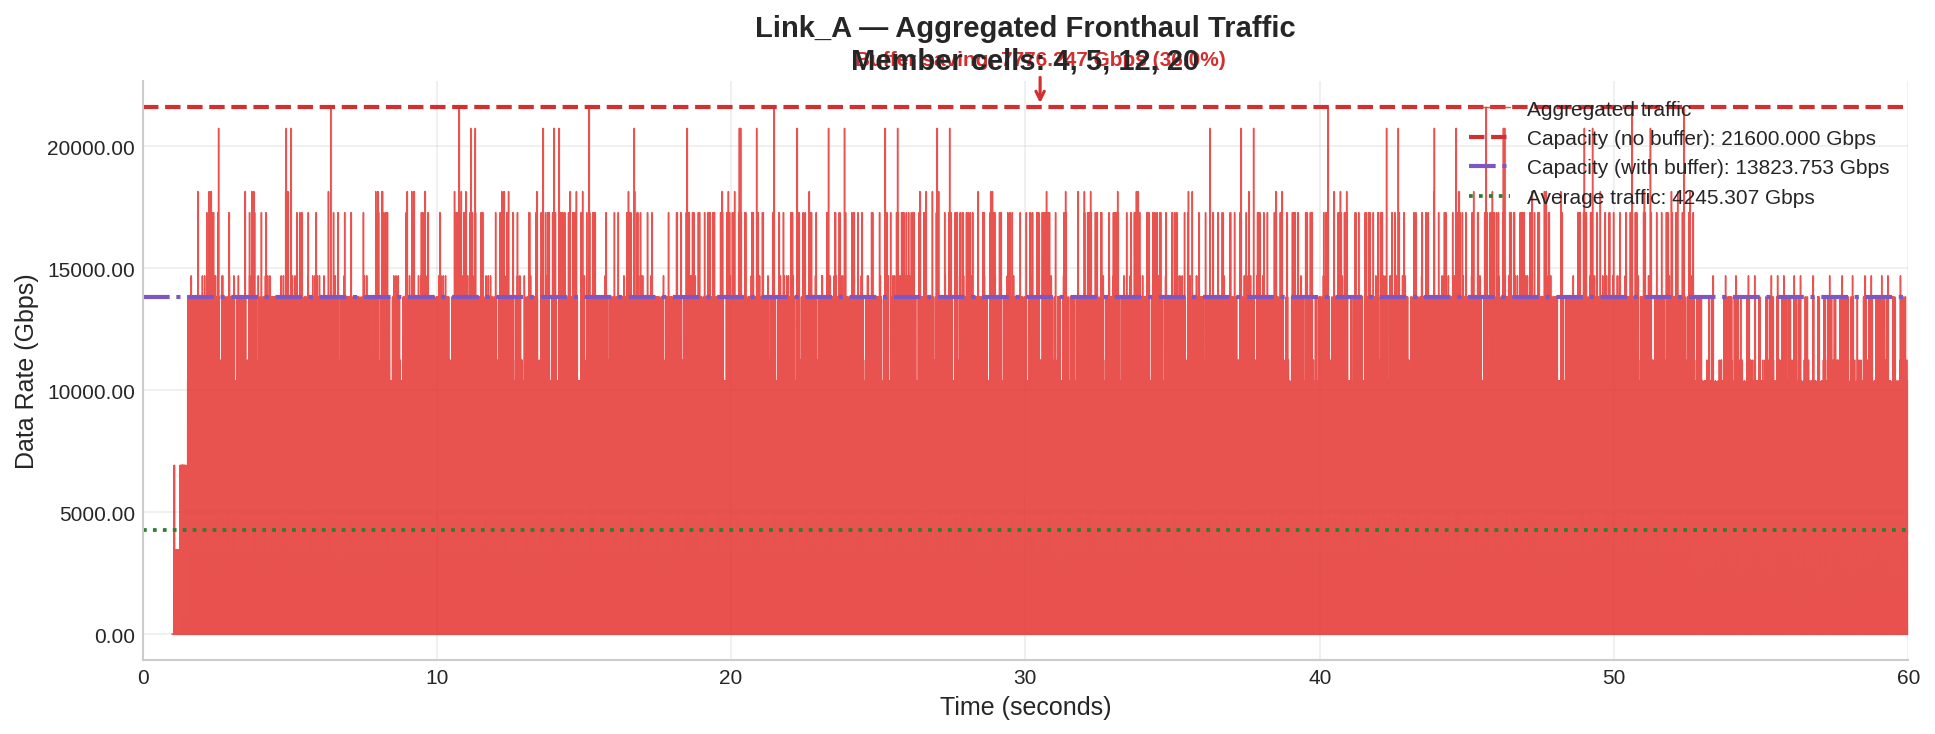

✔  Saved artifacts/link_b_traffic.png


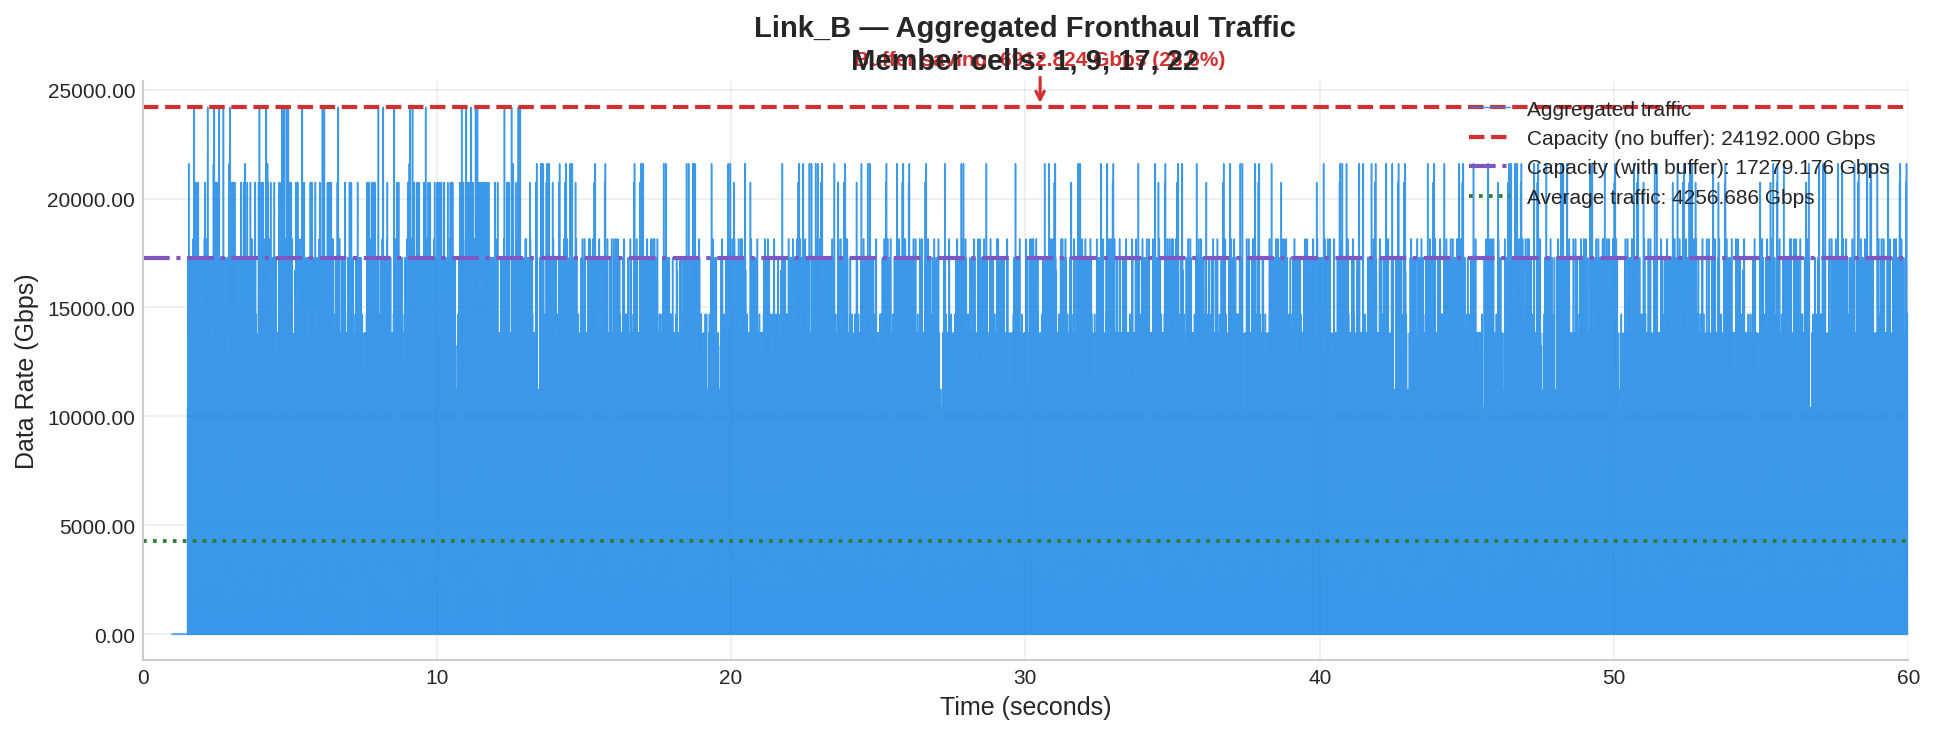

✔  Saved artifacts/link_c_traffic.png


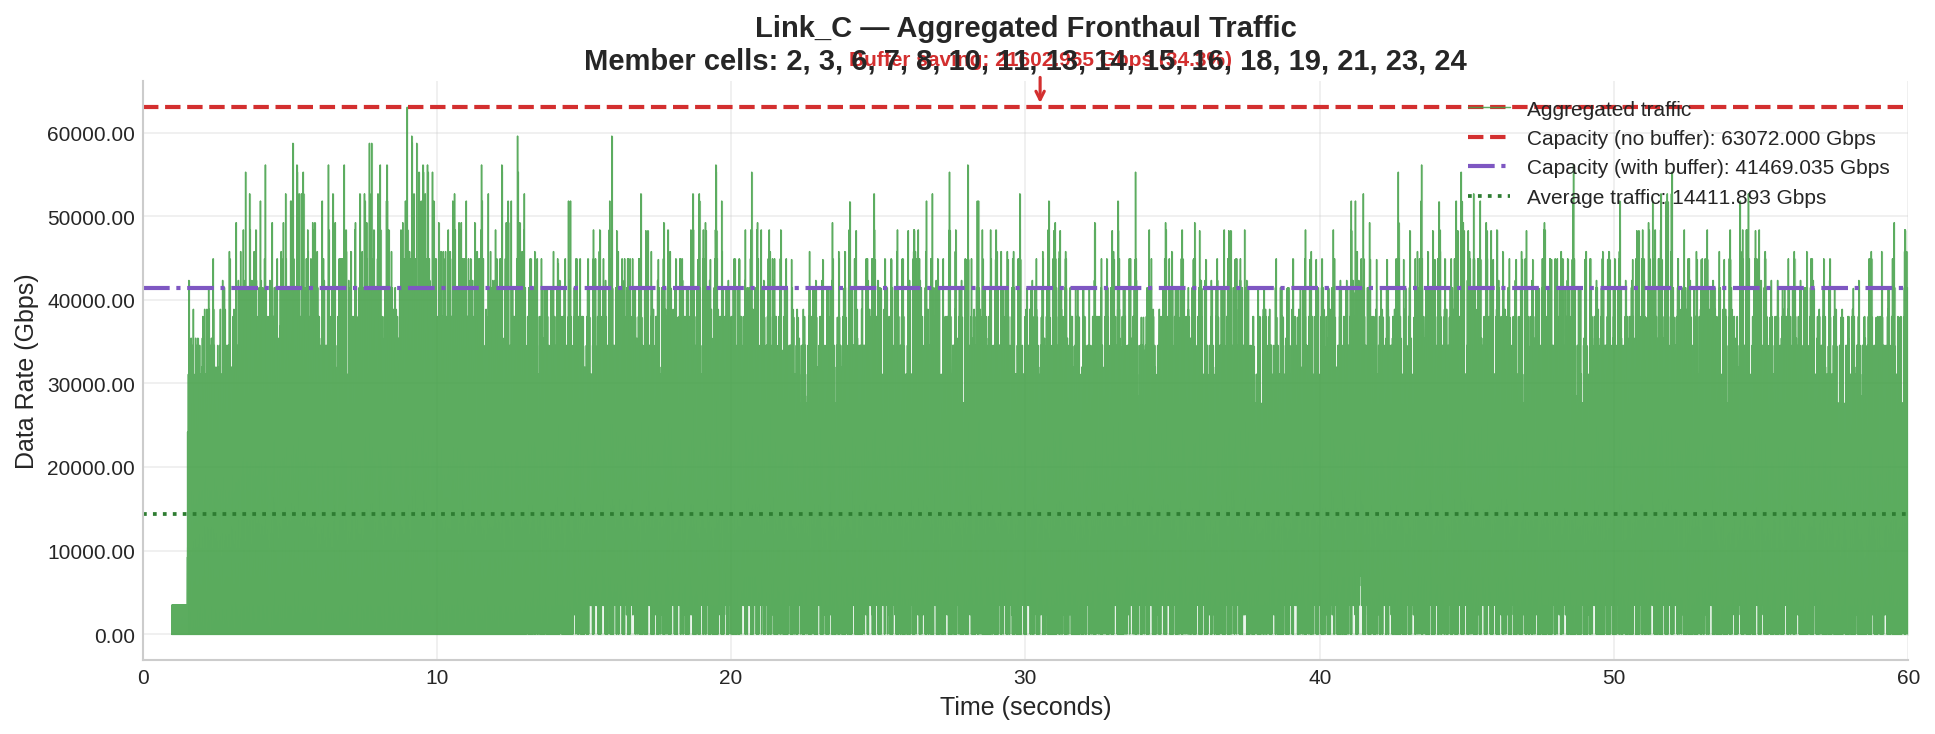

In [47]:
def plot_link_traffic(link_traffic: pd.DataFrame,
                      summary:      pd.DataFrame,
                      topology:     dict):
    """Generate and save one presentation-quality plot per link."""

    colours = {
        "Link_A": "#E53935",
        "Link_B": "#1E88E5",
        "Link_C": "#43A047",
    }

    for link_id in topology["links"].keys():

        # ── traffic data ───────────────────────────────────────────────
        sub = (
            link_traffic[link_traffic["link_id"] == link_id]
            .sort_values("time_seconds")
        )

        if sub.empty:
            print(f"⚠️  No traffic data for {link_id}, skipping plot")
            continue

        # ── summary row ────────────────────────────────────────────────
        row_df = summary[summary["link_id"] == link_id]
        if row_df.empty:
            print(f"⚠️  No summary row for {link_id}, skipping plot")
            continue

        row = row_df.iloc[0]

        # ── figure ─────────────────────────────────────────────────────
        fig, ax = plt.subplots(figsize=(13, 5))

        t = sub["time_seconds"].values
        y = sub["aggregated_gbps"].values
        c = colours.get(link_id, "#607D8B")

        # ── traffic trace ──────────────────────────────────────────────
        ax.plot(t, y, color=c, linewidth=0.7, alpha=0.85,
                label="Aggregated traffic")
        ax.fill_between(t, y, color=c, alpha=0.10)

        # ── capacity & average ─────────────────────────────────────────
        cap_nb  = row["capacity_no_buffer_gbps"]
        cap_wb  = row["capacity_with_buffer_gbps"]
        avg_val = row["avg_gbps"]

        ax.axhline(cap_nb, color="#D32F2F", linestyle="--", linewidth=2.0,
                   label=f"Capacity (no buffer): {cap_nb:.3f} Gbps")
        ax.axhline(cap_wb, color="#7E57C2", linestyle="-.", linewidth=2.0,
                   label=f"Capacity (with buffer): {cap_wb:.3f} Gbps")
        ax.axhline(avg_val, color="#2E7D32", linestyle=":", linewidth=1.8,
                   label=f"Average traffic: {avg_val:.3f} Gbps")

        # ── buffer saving annotation ───────────────────────────────────
        saving     = cap_nb - cap_wb
        saving_pct = saving / cap_nb * 100 if cap_nb > 0 else 0.0

        ax.annotate(
            f"Buffer saving: {saving:.3f} Gbps ({saving_pct:.1f}%)",
            xy=(t[len(t)//2], cap_nb),
            xytext=(t[len(t)//2], cap_nb * 1.08),
            ha="center",
            fontsize=10,
            color="#D32F2F",
            fontweight="bold",
            arrowprops=dict(arrowstyle="->", color="#D32F2F", lw=1.5),
        )

        # ── labels & title ─────────────────────────────────────────────
        cells_str = ", ".join(
            str(c) for c in topology["links"][link_id]["cells"]
        )

        ax.set_title(
            f"{link_id} — Aggregated Fronthaul Traffic\n"
            f"Member cells: {cells_str}",
            fontweight="bold"
        )

        ax.set_xlabel("Time (seconds)")
        ax.set_ylabel("Data Rate (Gbps)")
        ax.set_xlim(0, ANALYSIS_WINDOW_S)
        ax.yaxis.set_major_formatter(mticker.FormatStrFormatter("%.2f"))
        ax.legend(loc="upper right", framealpha=0.95)

        plt.tight_layout()

        fname = os.path.join(OUT_DIR, f"{link_id.lower()}_traffic.png")
        fig.savefig(fname, dpi=300, bbox_inches="tight")
        print(f"✔  Saved {fname}")

        plt.show()

plot_link_traffic(link_traffic, summary, topology)

In [48]:
SKU_THRESHOLDS = [(1, "1 GbE"), (10, "10 GbE"), (25, "25 GbE"),
                  (40, "40 GbE"), (100, "100 GbE")]

def recommend_sku(capacity_gbps: float) -> str:
    """Return the smallest standard SKU that covers the capacity."""
    for thr, name in SKU_THRESHOLDS:
        if capacity_gbps <= thr:
            return name
    return "100 GbE"   # fallback


# ── print summary table ──────────────────────────────────────────────────────
print("=" * 72)
print("  FINAL CAPACITY RECOMMENDATION SUMMARY")
print("=" * 72)

header = (f"\n  {'Link':<8} {'Avg':>9} {'Peak':>9} {'P95':>9} "
          f"{'No-Buf':>9} {'Buf':>9} {'Saving':>8} {'SKU':>8}")
print(header)
print("  " + "─" * (len(header) - 2))

for _, r in summary.iterrows():
    saving_pct = (r["capacity_no_buffer_gbps"] - r["capacity_with_buffer_gbps"]) \
                 / r["capacity_no_buffer_gbps"] * 100
    sku = recommend_sku(r["capacity_with_buffer_gbps"])
    print(f"  {r['link_id']:<8} "
          f"{r['avg_gbps']:>8.3f}  "
          f"{r['peak_gbps']:>8.3f}  "
          f"{r['p95_gbps']:>8.3f}  "
          f"{r['capacity_no_buffer_gbps']:>8.3f}  "
          f"{r['capacity_with_buffer_gbps']:>8.3f}  "
          f"{saving_pct:>6.1f}%  "
          f"{sku:>8}")

# ── domain constraint checklist ──────────────────────────────────────────────
print("\n  ── Domain-constraint checklist ─────────────────────────────")
print(f"    Slot resolution      : {SLOT_DURATION_S*1e6:>6.0f} µs           ✔")
print(f"    Analysis window      : {ANALYSIS_WINDOW_S:>6.0f} s            ✔")
print(f"    Buffer duration      : {BUFFER_DURATION_S*1e6:>6.0f} µs  (4 symbols)  ✔")
print(f"    Max allowed loss     : {MAX_LOSS_FRAC*100:>5.0f} %            ✔")
print("=" * 72)
print("  Day-2 pipeline completed successfully.")
print("=" * 72)

  FINAL CAPACITY RECOMMENDATION SUMMARY

  Link           Avg      Peak       P95    No-Buf       Buf   Saving      SKU
  ─────────────────────────────────────────────────────────────────────────────
  Link_A   4245.307  21600.000  10368.000  21600.000  13823.753    36.0%   100 GbE
  Link_B   4256.686  24192.000  13824.000  24192.000  17279.176    28.6%   100 GbE
  Link_C   14411.893  63072.000  31968.000  63072.000  41469.035    34.3%   100 GbE

  ── Domain-constraint checklist ─────────────────────────────
    Slot resolution      :    500 µs           ✔
    Analysis window      :     60 s            ✔
    Buffer duration      :    143 µs  (4 symbols)  ✔
    Max allowed loss     :     1 %            ✔
  Day-2 pipeline completed successfully.


In [52]:
!zip -r artifacts.zip /content/artifacts


  adding: content/artifacts/ (stored 0%)
  adding: content/artifacts/link_b_traffic.png (deflated 9%)
  adding: content/artifacts/link_capacity_summary.csv (deflated 38%)
  adding: content/artifacts/link_c_traffic.png (deflated 8%)
  adding: content/artifacts/link_a_traffic.png (deflated 10%)
  adding: content/artifacts/link_traffic_timeseries.csv (deflated 89%)


In [53]:
!zip -r results.zip /content/results


  adding: content/results/ (stored 0%)
  adding: content/results/topology.json (deflated 69%)
  adding: content/results/06_loss_timeline_all_cells.png (deflated 12%)
  adding: content/results/correlation_matrix.csv (deflated 69%)
  adding: content/results/09_validation_dashboard.png (deflated 19%)
  adding: content/results/08_network_topology_graph.png (deflated 11%)
  adding: content/results/topology_report.txt (deflated 61%)
  adding: content/results/03_correlation_heatmap_initial.png (deflated 17%)
  adding: content/results/cluster_assignments.csv (deflated 64%)
  adding: content/results/02_lag_distribution.png (deflated 20%)
  adding: content/results/07_synchronized_events.png (deflated 10%)
  adding: content/results/04_dendrogram.png (deflated 37%)
  adding: content/results/processed_data.csv (deflated 91%)
  adding: content/results/01_exploratory_analysis.png (deflated 17%)
  adding: content/results/.ipynb_checkpoints/ (stored 0%)
  adding: content/results/05_correlation_heatmap_

In [54]:
from google.colab import files
files.download('artifacts.zip')
files.download('results.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>